# Project Overview

The project is organised in the following manner: 
##### 1. Dataset Overview: At first, I aim to understand the dataset and all the variables in it. Are there outliers?
##### 2 and 3 EDA and Visualization: Once I have a clean dataset, I want to know how: are the variables connected to each other? Are there salient segments or patterns? What can I learn from the data alone, and then in connection to conversion? The initial analyses serve as ground truth. 
##### 4. PCAs: I am doing three PCAs: one-component PCA, two-component PCA to see whether there is a delienation of converted and non-converted users, and the elbow method PCA to see how many principal components capture a significant proportion of the variance, and whether we can reduce dimensionality
##### 5. Classification Models: Once I have some sense of the relationships in the dataset, I try to use models to see whether they can pick up some feature importance I am not seeing. I am looking at an XGBoost classifier and a logistic regression classifier

## Executive Summary

1. Women seem to convert more than men. 
2. Women who convert have higher initial fee levels than men who convert.
3. For women, having a credit account doesn't seem to matter much, since they convert with or without an account. However, there is a high number of men who don't have a credit account and they don't convert
4. Men from Helsinki don't convert.
5. Men that belong to segment 13 don't convert
6. Women aged 30-39 who pay initial fees of 100+ convert much more than men in the same cohort.
7. The one-component PCA shows positive weights of over 0.4 for credit_account_id, gender_female, and initial_fee_levels, suggesting some importance, not necessarily for conversion. However, credit_account_id is empty for about 80% of users, so it's unclear what this means.
8. The two-component PCA shows a certain level of demarcation for converted and non-converted users.
9. An XGBoost classifier found gender_female and customer_segment to be important features. However, customer_segment probably denotes some other characteristics that are not known in the dataset. It's unclear how and when the segmentation is done and what it means, so the usefullness of this feature here is limited.
10. Most initial fees are below 20. However, there is a high number of men with initial fees below 20 that do not convert.
11. People younger than 15 have a higher number of related customers but do not convert.
12. Age groups and fee groups do not seem to perform better than using the continuous features age and initial fee

##### Personal Notes:
I understand this exercise serves a purpose - to demonstrate my technical abilities, but I can't help<br>
treating it like a real project :) So, I'd like to briefly mention a few things:

* 1. I am reluctant to call gender_female and initial fee levels __p r e d i c t o r s__ of conversion. While  I think age, gender, and initial fee have some connection to conversion, that is, these features probably signal higher likelyhood to convert, I can forsee two issues with calling them predictors:
  * 1.1. So what? As in, how is the business going to benefit from knowing that women that initially have higher fees convert more often? I was trying to think about what the insights from this data and analysis might mean to a stakeholder, but I can't help but thinking more data might be needed to make these insigts actionable. For example, most people don't have another person that is using the services (related_customers), and they have no other family members, but these things might serve as features to do segmentation, which wasn't really the task for this use case.
  * 1.2. I would expect young men/women to have different goals from middle-aged people, and from elderly people, and their motivation/discipline/commitment might be different. But the way I see it, the data from the csv snapshot doesn't measure sufficiently the intent or inclination of the users, just some characteristics
* 2. I don't have enough information about some features:
  * 2.1. initial fee level - is this the product/service that the user sees when they choose a coach? Does an individual coach decide what to price their specific services? When does a user see this fee? This matters because most of the fees are between 10-20, yet, most of the conversions happen when the initial fees are higher. And this makes sense logically, because when a user is ready to pay more, they are already signaling more commitment/desire/motivation than someone who pays lower prices. Or maybe they know the coach? Unclear
  * 2.2. age - the minimum age is 0.4, is this correct? Can children use the services? Since age might logically be one of the leading signals for interest if not conversion, age as a column is confusing. 
  * 2.3. related_customers - when is this column populated and by whom? Are coaches adding this in their CRM?
  * 2.4. family_size - same as related_customers. Are coaches populating these, or key account managers, or users? Is it the family size of the person in general, or is it related to related_customers in some way?
  * 2.5. credit_account_id - I treat this as a binary column in the dataset, meaning empty or not. But, when do users get credit accounts? Can they do the same things with and without an account? When does having an account matter? It seems like there aren't conclusive evidence that having an account matters, from this snapshot data.
  * 2.6 People younger than 15 have a higher number of related customers, and this age group does not convert often. If these are parents, can this age group be confounding conversion? Is the conversion expected for this age group or their related customers, or both?

### 1. Dataset Overview
Here I want to see whether there are outliers, empty cells, something suspicious, how data is spread across variables, in general, I'm trying to see how healthy and reliable the data in the dataset is and whether I can see some obvious faults in it

##### Import most frequent libraries

In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [156]:
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", None)

In [157]:
## Define the look of the Seaborn plots
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,8)})
sns.set(font_scale = 1.5)

In [158]:
df = pd.read_csv("customer_data_sample.csv")

In [159]:
### are there empty cells?
df.isnull().sum()

customer_id            0
converted              0
customer_segment       0
gender                 0
age                  177
related_customers      0
family_size            0
initial_fee_level      0
credit_account_id      0
branch                 2
dtype: int64

In [160]:
len(df)

891

In [161]:
### it looks like age would either need to be computed or dealt with somehow. Since about 20% of the rows
### in the dataset don't have a value in age, we can't delete these rows safely. There are only two empty cells 
### in the branch column, so we can either delete them or put "NA" for the value 

In [162]:
### Since it is not immediately clear what to impute for the missing age values, I'm going to do some analysis 
### on 3 different datasets and see how the results differ: 1. mean_age_df, where the age is calculated using the mean,
### 2. median_age_df, where the age is calculated using the median age, and 3. regression_age_df, where the age is
### predicted using a linear regression model.

In [163]:
df.age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

In [164]:
## A minimum age of 0.4 is a bit suspicious. Since we need to impute the age, minimum values can influence 
## the mean and median. Let's do a sanity check on age

In [165]:
age_check_dict = {"Less than 1 year": len(df[df['age'] < 1]),
                  "Between 1 and 4": len(df[(df['age'] >= 1) & (df['age'] < 5)]),
                  "Between 5 and 9": len(df[(df['age'] >= 5) & (df['age'] < 10)]),
                  "Between 10 and 14": len(df[(df['age'] >= 10) & (df['age'] < 15)]),
                  "Between 15 and 18": len(df[(df['age'] >= 15) & (df['age'] < 19)]),
                  "Between 19 and 29": len(df[(df['age'] >= 19) & (df['age'] < 30)]),
                  "Between 30 and 39": len(df[(df['age'] >= 30) & (df['age'] < 40)]),
                  "Between 40 and 49": len(df[(df['age'] >= 40) & (df['age'] < 50)]),
                  "Between 50 and 59": len(df[(df['age'] >= 50) & (df['age'] < 60)]),
                  "Over 60": len(df[df['age'] >= 60])
}

age_check_dict

{'Less than 1 year': 7,
 'Between 1 and 4': 33,
 'Between 5 and 9': 22,
 'Between 10 and 14': 16,
 'Between 15 and 18': 61,
 'Between 19 and 29': 245,
 'Between 30 and 39': 167,
 'Between 40 and 49': 89,
 'Between 50 and 59': 48,
 'Over 60': 26}

In [166]:
len(df[df['age'] < 18])

113

In [167]:
### I am not sure what the minimum age is for clients, but if babies/toddlers can't convert, 
### it may dilude both the age calculation and the conversion analysis

In [168]:
### Since we are calculating age with a mean, let's see if the mean is different for men and women

In [169]:
df[df['gender'] == 'male'].age.describe()

count    453.000000
mean      30.726645
std       14.678201
min        0.420000
25%       21.000000
50%       29.000000
75%       39.000000
max       80.000000
Name: age, dtype: float64

In [170]:
df[df['gender'] == 'female'].age.describe()

count    261.000000
mean      27.915709
std       14.110146
min        0.750000
25%       18.000000
50%       27.000000
75%       37.000000
max       63.000000
Name: age, dtype: float64

In [171]:
### Let's do the same check for the median

In [172]:
df[df['gender'] == 'male'].age.median()

29.0

In [173]:
df[df['gender'] == 'female'].age.median()

27.0

In [174]:
### We don't have to group by gender when we impute the age (mean and median). What about branches? We don't know
### the customer_segment or whether they converted yet, so we can't use these for the age impute check

In [175]:
df['branch'].value_counts()

Helsinki    644
Tampere     168
Turku        77
Name: branch, dtype: int64

In [176]:
df[df['branch'] == 'Helsinki'].age.describe()

count    554.000000
mean      29.445397
std       14.143192
min        0.670000
25%       21.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

In [177]:
df[df['branch'] == 'Tampere'].age.describe()

count    130.000000
mean      30.814769
std       15.434860
min        0.420000
25%       21.250000
50%       29.000000
75%       40.000000
max       71.000000
Name: age, dtype: float64

In [178]:
df[df['branch'] == 'Turku'].age.describe()

count    28.000000
mean     28.089286
std      16.915396
min       2.000000
25%      17.500000
50%      27.000000
75%      34.500000
max      70.500000
Name: age, dtype: float64

In [179]:
### Mean age per branch isn't that far off either, so we can go ahead and impute mean age in general, 
### and not group by anything

In [180]:
## let's change the credit_account_id feature to be a binary flag, 
## where "9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0" is 0 and all the others are 1,
## to signify 0 = no account and 1 = has account
df['credit_account_id'] = df['credit_account_id'].apply(lambda x: 0 if x == '9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0' else 1)

In [181]:
### check that it worked
df.credit_account_id.value_counts()

0    687
1    204
Name: credit_account_id, dtype: int64

## 1. 2 Age Missing Value Imputation EDA

### 1.2.1. Mean Age DF Eda

In [182]:
## first, get the mean age for the dataset
mean_age = df['age'].mean()

In [183]:
## then, replace the empty age cells with the mean_age value, but create a new df and don't alter 
## the original df

In [184]:
mean_age_df = df.copy()

In [185]:
mean_age_df['age'].fillna(mean_age, inplace=True)

In [186]:
### check to see whether it worked
mean_age_df.isnull().sum()

customer_id          0
converted            0
customer_segment     0
gender               0
age                  0
related_customers    0
family_size          0
initial_fee_level    0
credit_account_id    0
branch               2
dtype: int64

In [187]:
mean_age_df['branch'].fillna("NA", inplace=True)

#### Can we visually spot differences in conversion for the variables?

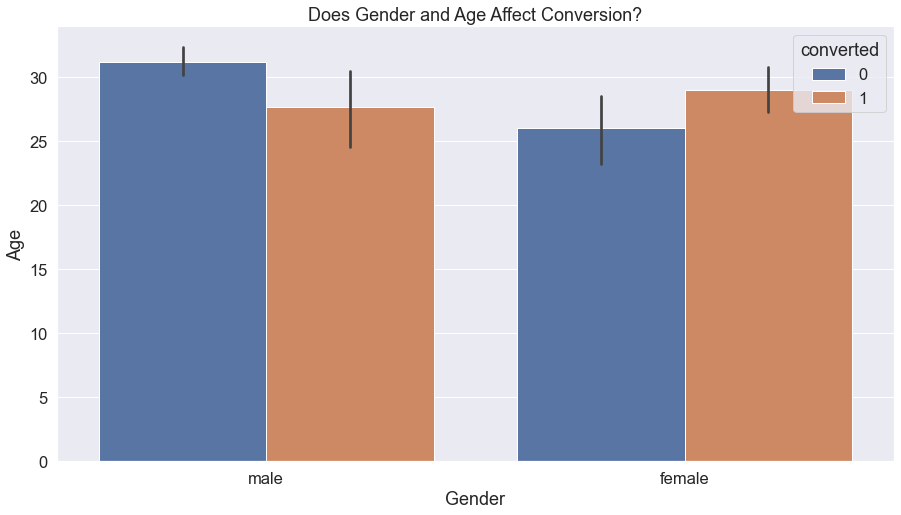

In [188]:
sns.barplot(x=mean_age_df.gender, y=mean_age_df.age, hue=mean_age_df.converted)
plt.xlabel("Gender")
plt.ylabel("Age")
plt.title("Does Gender and Age Affect Conversion?")

# Show the plot
plt.show()

In [189]:
## Men and women convert similarly and they are close in age

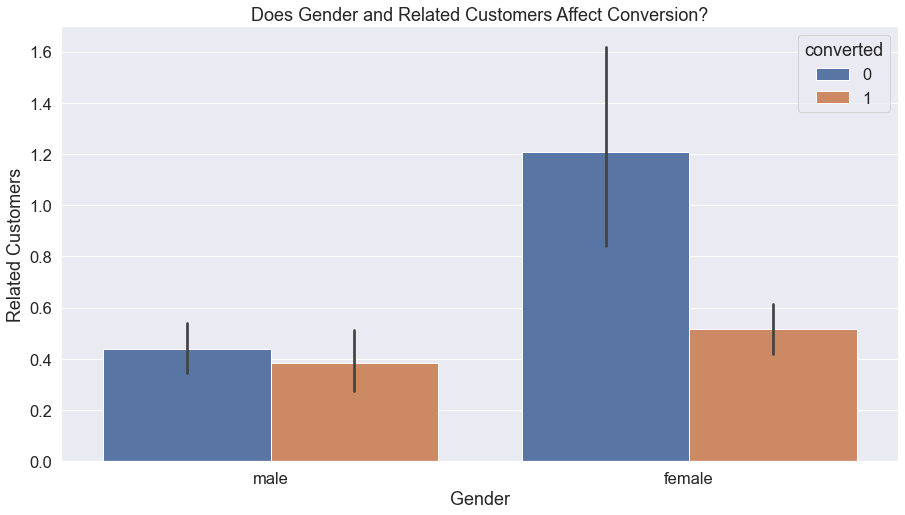

In [190]:
sns.barplot(x=mean_age_df.gender, y=mean_age_df.related_customers, hue=mean_age_df.converted)
plt.xlabel("Gender")
plt.ylabel("Related Customers")
plt.title("Does Gender and Related Customers Affect Conversion?")

# Show the plot
plt.show()

In [191]:
## Men and women have similar related customers when they convert, however, men that don't convert
## seem to have slightly higher number of related customers.

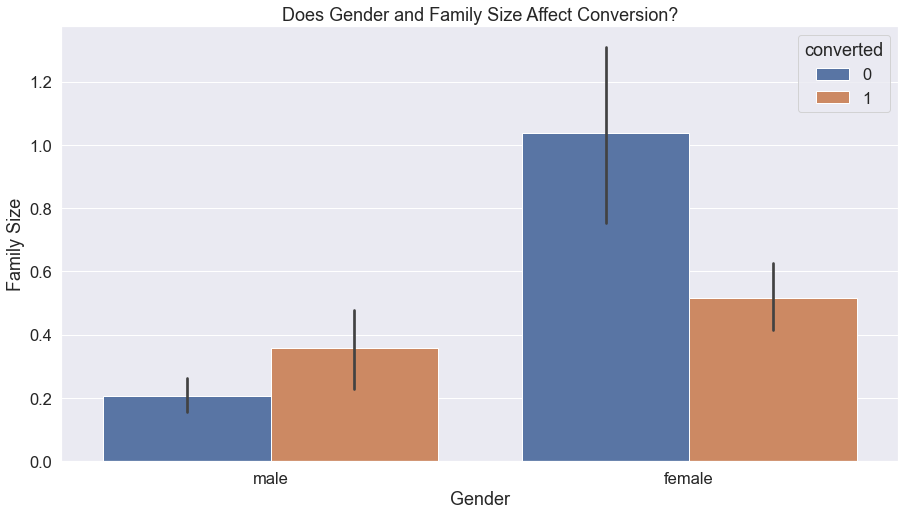

In [192]:
sns.barplot(x=mean_age_df.gender, y=mean_age_df.family_size, hue=mean_age_df.converted)
plt.xlabel("Gender")
plt.ylabel("Family Size")
plt.title("Does Gender and Family Size Affect Conversion?")

# Show the plot
plt.show()

In [193]:
### Similar to related_customers, men who don't convert have a slightly increased family size

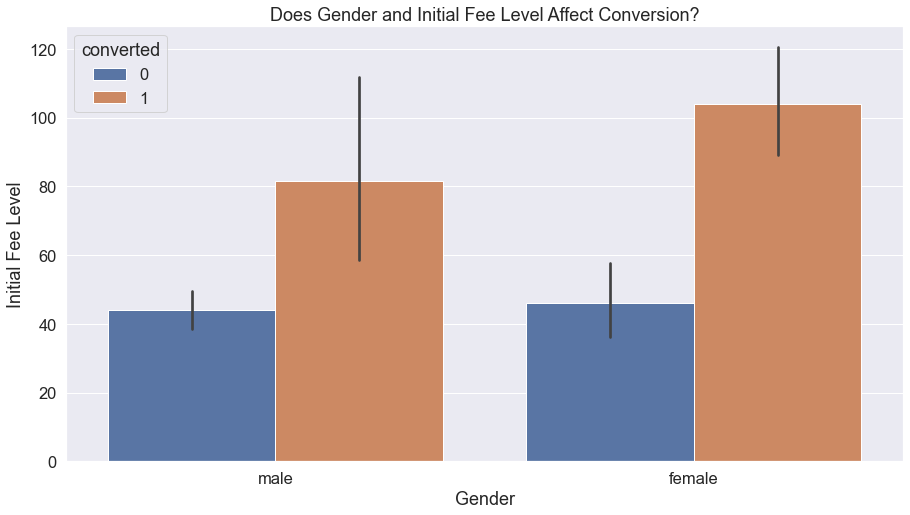

In [194]:
sns.barplot(x=mean_age_df.gender, y=mean_age_df.initial_fee_level, hue=mean_age_df.converted)
plt.xlabel("Gender")
plt.ylabel("Initial Fee Level")
plt.title("Does Gender and Initial Fee Level Affect Conversion?")

# Show the plot
plt.show()

In [195]:
### While both men and women that convert have a higher initial fee level, women who convert have much higher
### initial fees than men

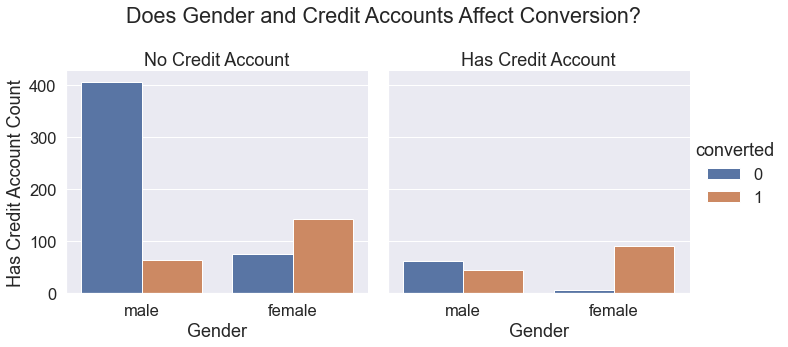

In [196]:
plot = sns.catplot(x='gender', col='credit_account_id', hue='converted', data=mean_age_df, kind='count')

# Set custom titles for each subplot
titles = ["No Credit Account", "Has Credit Account"]
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title)

plot.set_axis_labels("Gender", "Has Credit Account Count")
# Set an overall title
plt.subplots_adjust(top=0.8)
plot.fig.suptitle("Does Gender and Credit Accounts Affect Conversion?")

# Show the plot
plt.show()

In [197]:
### Women convert more often than men. Both men and women convert more when they don't have a credit account

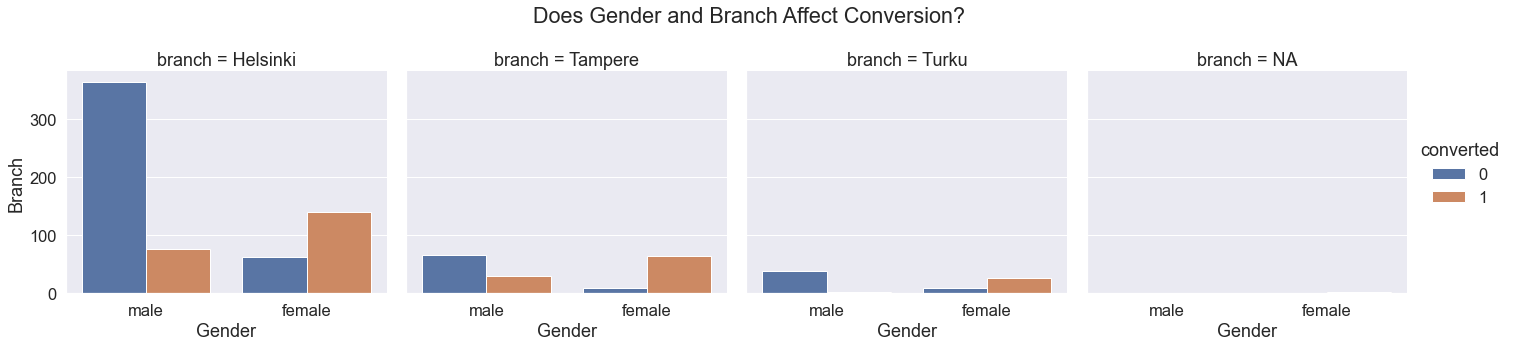

In [198]:
plot = sns.catplot(x='gender', col='branch', hue='converted', data=mean_age_df, kind='count')

plot.set_axis_labels("Gender", "Branch")
plt.subplots_adjust(top=0.8)
plot.fig.suptitle("Does Gender and Branch Affect Conversion?")

# Show the plot
plt.show()

In [199]:
## Women convert more than men in all branches, but there seems to be a very high number of non-converted men
## from the Helsinki branch. This should be investigated further, as finding ways to see why this cohort 
## doesn't convert could increase conversion and change the predictors

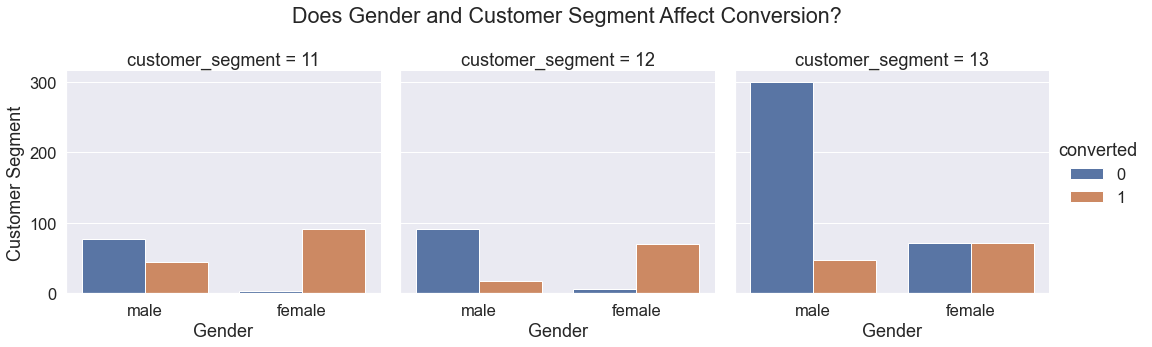

In [200]:
plot = sns.catplot(x='gender', col='customer_segment', hue='converted', data=mean_age_df, kind='count')

plot.set_axis_labels("Gender", "Customer Segment")
# Set an overall title
plt.subplots_adjust(top=0.8)
plot.fig.suptitle("Does Gender and Customer Segment Affect Conversion?")

# Show the plot
plt.show()

In [201]:
### Women from all segments convert more than men, however, there is a very high number of men in segment 13
### that doesn't convert. Similar to men from Helsinki, this should be investigated.

### 1.2.2. Median Age DF Eda

In [202]:
## first, get the median age for the dataset
median_age = df['age'].median()

In [203]:
## then, replace the empty age cells with the median_age value, but create a new df and don't alter 
## the original df

In [204]:
median_age_df = df.copy()

In [205]:
median_age_df['age'].fillna(median_age, inplace=True)

In [206]:
### check to see whether it worked
median_age_df.isnull().sum()

customer_id          0
converted            0
customer_segment     0
gender               0
age                  0
related_customers    0
family_size          0
initial_fee_level    0
credit_account_id    0
branch               2
dtype: int64

In [207]:
median_age_df['branch'].fillna("NA", inplace=True)

#### Can we visually spot differences in conversion for the variables?

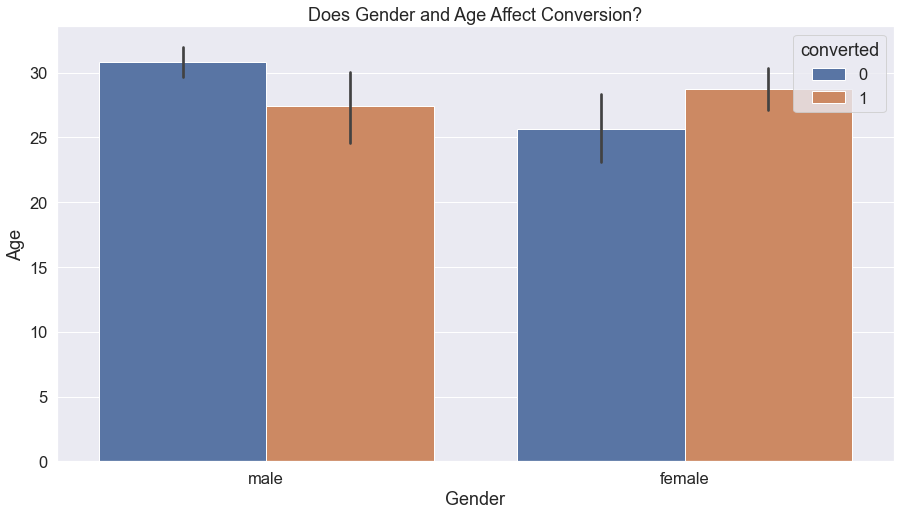

In [208]:
sns.barplot(x=median_age_df.gender, y=median_age_df.age, hue=median_age_df.converted)
plt.xlabel("Gender")
plt.ylabel("Age")
plt.title("Does Gender and Age Affect Conversion?")

# Show the plot
plt.show()

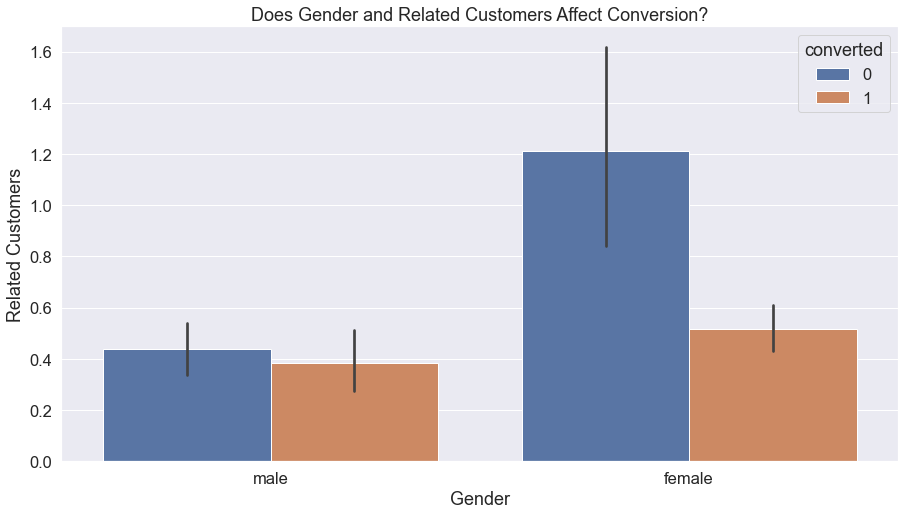

In [209]:
sns.barplot(x=median_age_df.gender, y=median_age_df.related_customers, hue=median_age_df.converted)
plt.xlabel("Gender")
plt.ylabel("Related Customers")
plt.title("Does Gender and Related Customers Affect Conversion?")

# Show the plot
plt.show()

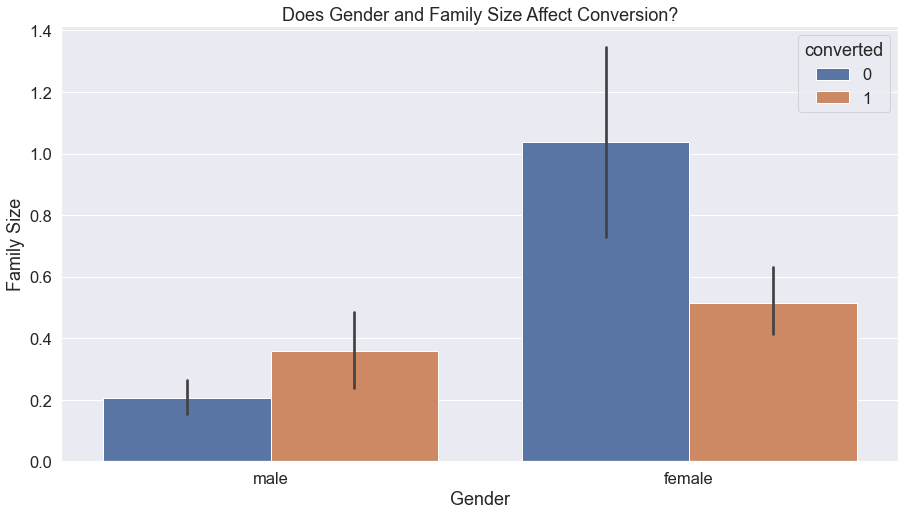

In [210]:
sns.barplot(x=mean_age_df.gender, y=mean_age_df.family_size, hue=median_age_df.converted)
plt.xlabel("Gender")
plt.ylabel("Family Size")
plt.title("Does Gender and Family Size Affect Conversion?")

# Show the plot
plt.show()

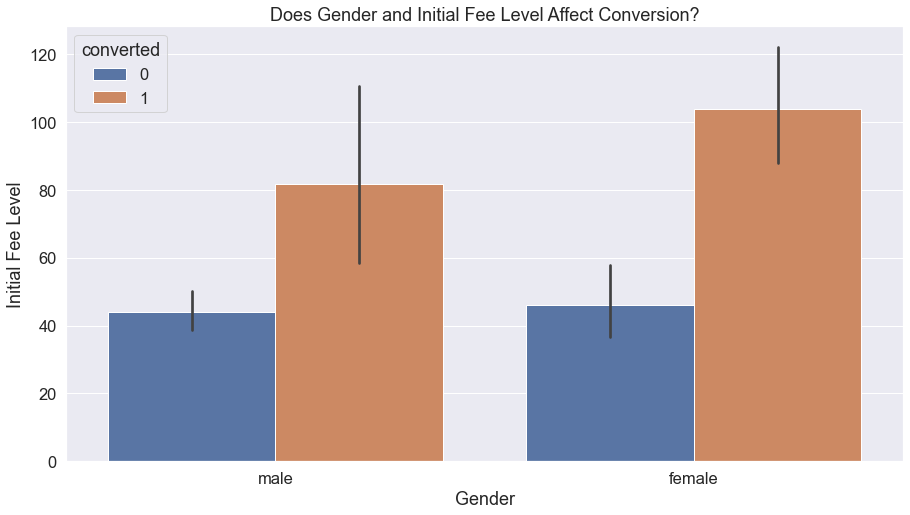

In [211]:
sns.barplot(x=mean_age_df.gender, y=mean_age_df.initial_fee_level, hue=median_age_df.converted)
plt.xlabel("Gender")
plt.ylabel("Initial Fee Level")
plt.title("Does Gender and Initial Fee Level Affect Conversion?")

# Show the plot
plt.show()

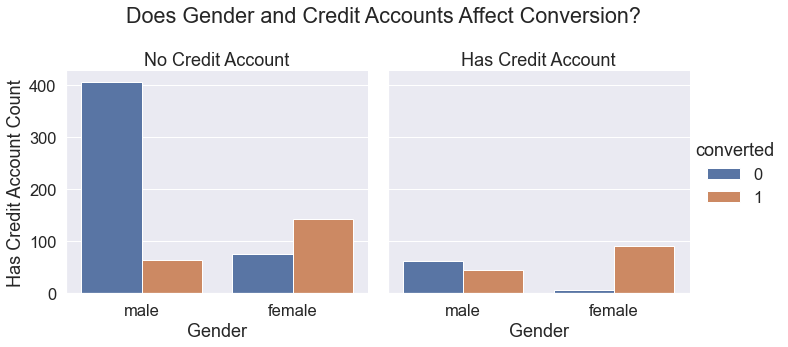

In [212]:
plot = sns.catplot(x='gender', col='credit_account_id', hue='converted', data=median_age_df, kind='count')

# Set custom titles for each subplot
titles = ["No Credit Account", "Has Credit Account"]
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title)

plot.set_axis_labels("Gender", "Has Credit Account Count")
# Set an overall title
plt.subplots_adjust(top=0.8)
plot.fig.suptitle("Does Gender and Credit Accounts Affect Conversion?")

# Show the plot
plt.show()

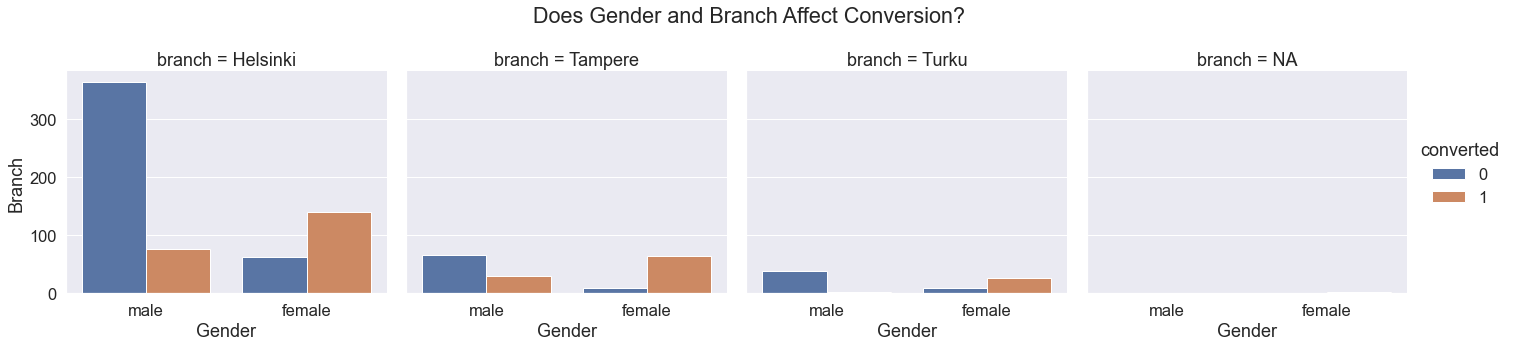

In [213]:
plot = sns.catplot(x='gender', col='branch', hue='converted', data=median_age_df, kind='count')

plot.set_axis_labels("Gender", "Branch")
# Set an overall title
plt.subplots_adjust(top=0.8)
plot.fig.suptitle("Does Gender and Branch Affect Conversion?")
# Show the plot
plt.show()

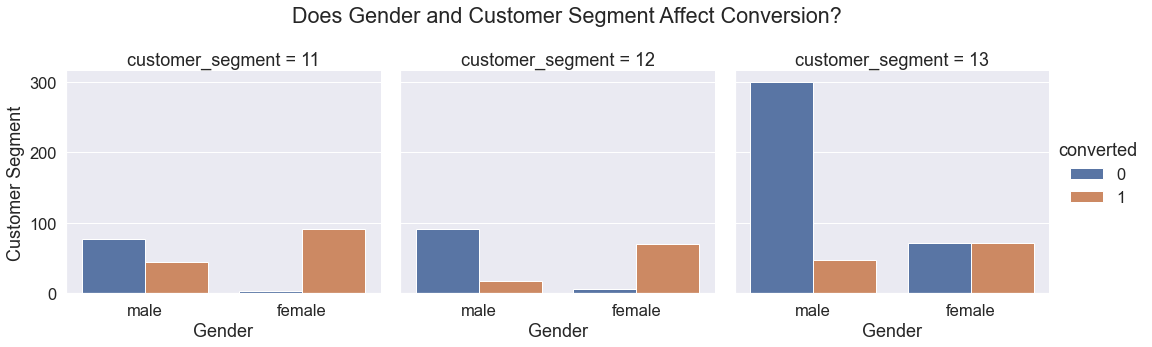

In [214]:
plot = sns.catplot(x='gender', col='customer_segment', hue='converted', data=median_age_df, kind='count')

plot.set_axis_labels("Gender", "Customer Segment")
# Set an overall title
plt.subplots_adjust(top=0.8)
plot.fig.suptitle("Does Gender and Customer Segment Affect Conversion?")

# Show the plot
plt.show()

### 1.2.3. Regression Age DF Eda

In [215]:
### important libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [216]:
regression_age_df = df.copy()

In [217]:
regression_age_df['branch'].fillna("EmptyRow", inplace=True)

#### Encoding of categorical variables
We need to encode the categorical variables we have so we can do the linear regression. 

In [218]:
categorical_columns = ['gender', 'branch']

In [219]:
# Perform one-hot encoding for each categorical column
for col in categorical_columns:
    one_hot_encoded = pd.get_dummies(regression_age_df[col], prefix=col)
    
    # Concatenate the one-hot encoded columns to the original DataFrame
    regression_age_df = pd.concat([regression_age_df, one_hot_encoded], axis=1)

In [220]:
columns_to_drop = ['gender', 'branch', 'customer_id']
regression_age_df = regression_age_df.drop(columns=columns_to_drop)

In [221]:
regression_age_df.head()

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,credit_account_id,gender_female,gender_male,branch_EmptyRow,branch_Helsinki,branch_Tampere,branch_Turku
0,0,13,22.0,1,0,14.5000,0,0,1,0,1,0,0
1,1,11,38.0,1,0,142.5666,1,1,0,0,0,1,0
2,1,13,26.0,0,0,15.8500,0,1,0,0,1,0,0
3,1,11,35.0,1,0,106.2000,1,1,0,0,1,0,0
4,0,13,35.0,0,0,16.1000,0,0,1,0,1,0,0


In [222]:
# Since we are going to do the regression only on those rows that have age values, we need 2 dataframes,
# one to train on (the one that contains age), and one to predict on (the one with age missing)
missing_age_df = regression_age_df[regression_age_df['age'].isnull()]
df_with_age = regression_age_df.dropna(subset=['age'])

In [223]:
missing_age_df.head()

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,credit_account_id,gender_female,gender_male,branch_EmptyRow,branch_Helsinki,branch_Tampere,branch_Turku
5,0,13,NaN,0,0,16.9166,0,0,1,0,0,0,1
17,1,12,NaN,0,0,26.0000,0,0,1,0,1,0,0
19,1,13,NaN,0,0,14.4500,0,1,0,0,0,1,0
26,0,13,NaN,0,0,14.4500,0,0,1,0,0,1,0
28,1,13,NaN,0,0,15.7584,0,1,0,0,0,0,1


In [224]:
X = df_with_age.loc[:, df_with_age.columns != 'age']  ## we want all the columns but age 
y = df_with_age['age']

In [225]:
# We split the dataset to 80% training and 20% testing.
# We are stating the random_state for reproducability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [226]:
# We are initializing the linear regression model
model = LinearRegression()

In [227]:
# We are training the linear regression model on the train dataset
model.fit(X_train, y_train)

LinearRegression()

In [228]:
# Predict missing ages
predicted_ages = model.predict(missing_age_df.drop(['age'], axis=1))

In [229]:
regression_age_df.loc[regression_age_df['age'].isnull(), 'age'] = predicted_ages

In [230]:
# Let's check if it worked
regression_age_df.isnull().sum()

converted            0
customer_segment     0
age                  0
related_customers    0
family_size          0
initial_fee_level    0
credit_account_id    0
gender_female        0
gender_male          0
branch_EmptyRow      0
branch_Helsinki      0
branch_Tampere       0
branch_Turku         0
dtype: int64

In [231]:
# undo the one-hot encoding so we can use this dataset further
for col in categorical_columns:
    # this line finds the maximum value for each row. If we remove the .apply part, the values for each row
    # are going to be equal to the column name: gender_male, gender_female, etc. So, we use a split on 
    # the underscore so we can remove the first part (including the underscore) and have a clean categorical value
    regression_age_df[col] = regression_age_df.filter(like=col).idxmax(axis=1).apply(lambda x: x.split('_', 1)[-1])
    

In [232]:
# finally, drop the one-hot ecnoded values
columns_to_drop = ['gender_male', 'gender_female', 'branch_Helsinki', 'branch_Tampere', 'branch_Turku', 'branch_EmptyRow']
regression_age_df = regression_age_df.drop(columns=columns_to_drop)

In [233]:
regression_age_df.head()

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,credit_account_id,gender,branch
0,0,13,22.0,1,0,14.5000,0,male,Helsinki
1,1,11,38.0,1,0,142.5666,1,female,Tampere
2,1,13,26.0,0,0,15.8500,0,female,Helsinki
3,1,11,35.0,1,0,106.2000,1,female,Helsinki
4,0,13,35.0,0,0,16.1000,0,male,Helsinki


#### Can we visually spot differences in conversion for the variables?

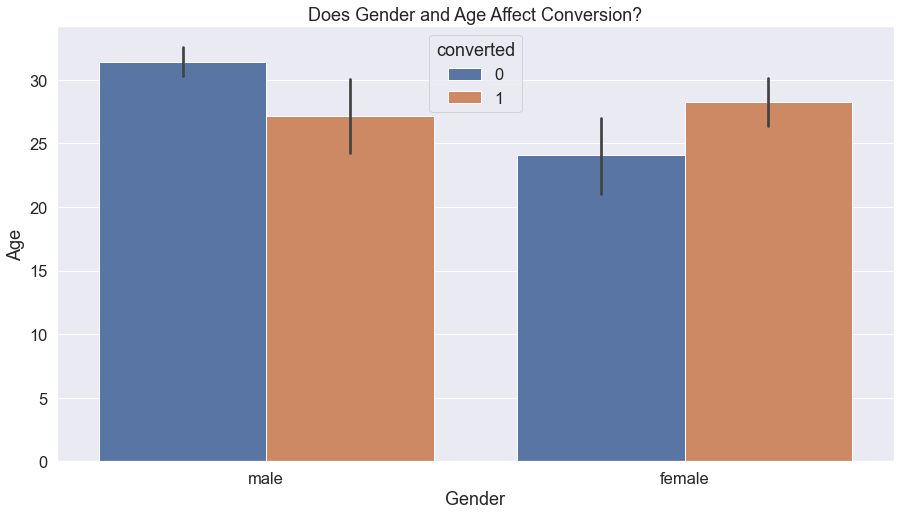

In [234]:
sns.barplot(x=regression_age_df.gender, y=regression_age_df.age, hue=regression_age_df.converted)
plt.xlabel("Gender")
plt.ylabel("Age")
plt.title("Does Gender and Age Affect Conversion?")

# Show the plot
plt.show()

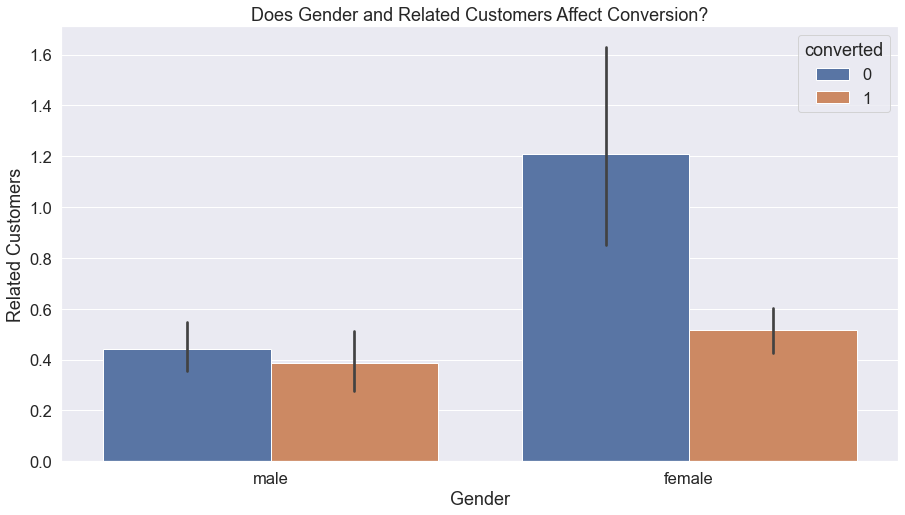

In [235]:
sns.barplot(x=regression_age_df.gender, y=regression_age_df.related_customers, hue=regression_age_df.converted)
plt.xlabel("Gender")
plt.ylabel("Related Customers")
plt.title("Does Gender and Related Customers Affect Conversion?")

# Show the plot
plt.show()

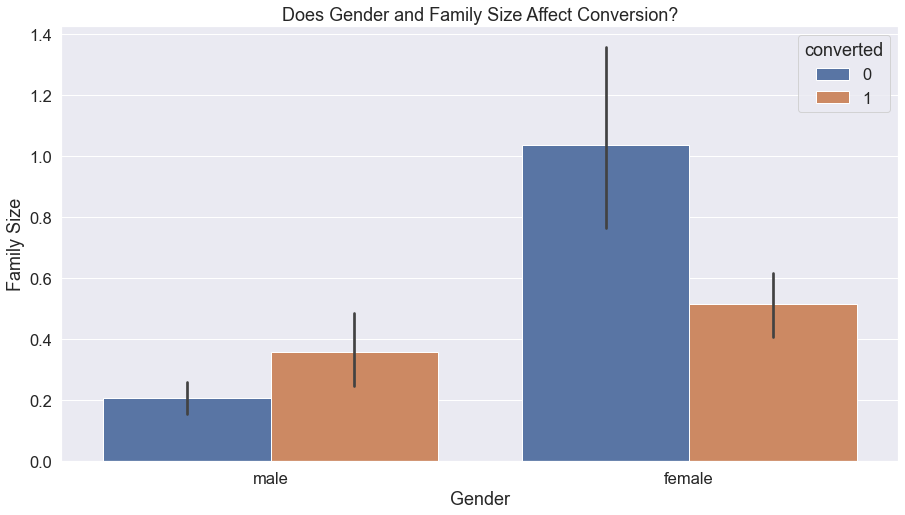

In [236]:
sns.barplot(x=regression_age_df.gender, y=regression_age_df.family_size, hue=regression_age_df.converted)
plt.xlabel("Gender")
plt.ylabel("Family Size")
plt.title("Does Gender and Family Size Affect Conversion?")

# Show the plot
plt.show()

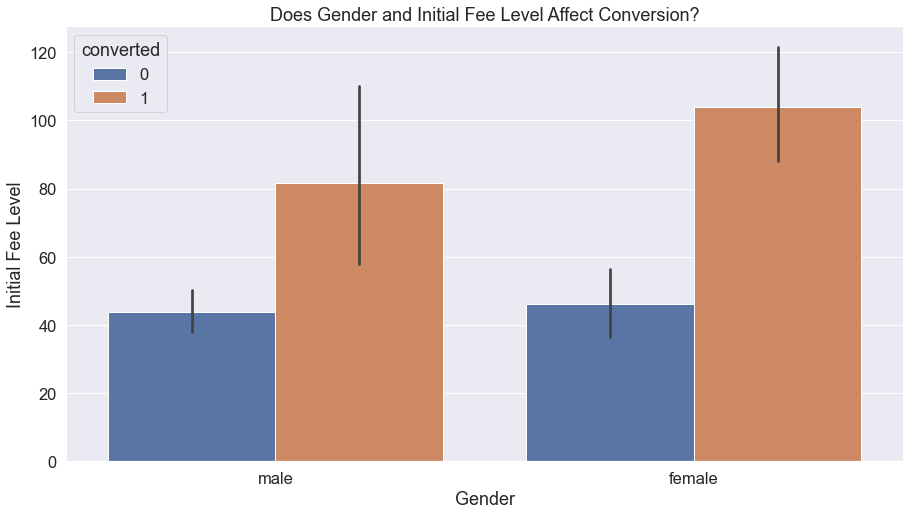

In [237]:
sns.barplot(x=regression_age_df.gender, y=regression_age_df.initial_fee_level, hue=regression_age_df.converted)
plt.xlabel("Gender")
plt.ylabel("Initial Fee Level")
plt.title("Does Gender and Initial Fee Level Affect Conversion?")

# Show the plot
plt.show()

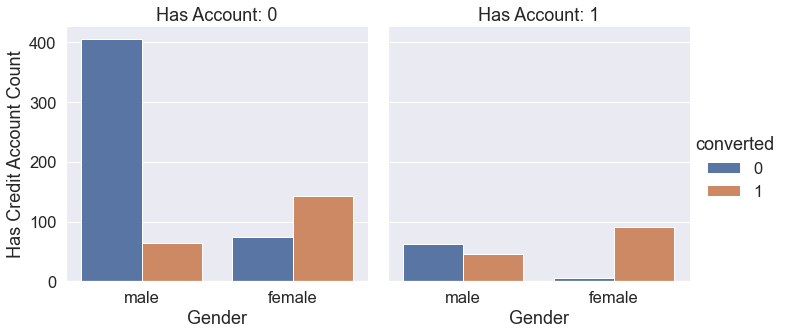

In [238]:
plot = sns.catplot(x='gender', col='credit_account_id', hue='converted', data=regression_age_df, kind='count')

plot.set_axis_labels("Gender", "Has Credit Account Count")
plot.set_titles("Has Account: {col_name}")


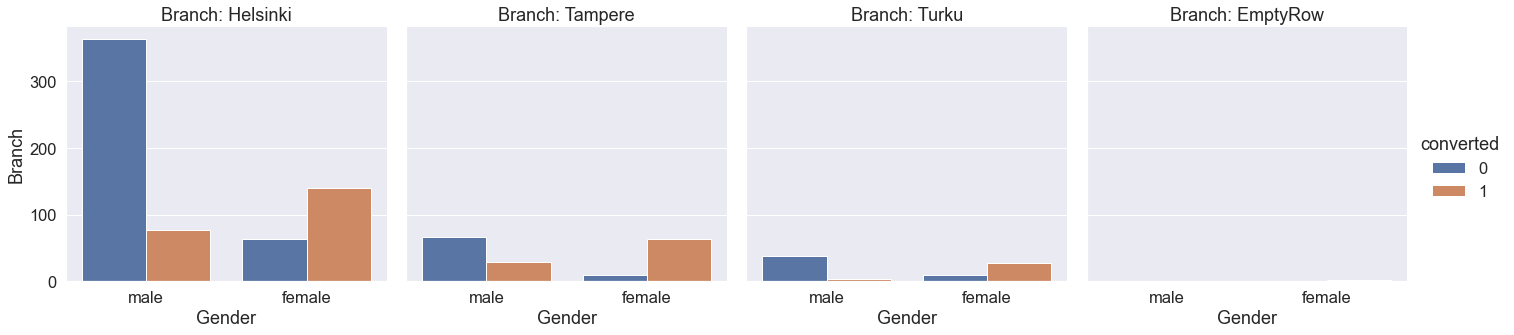

In [239]:
plot = sns.catplot(x='gender', col='branch', hue='converted', data=regression_age_df, kind='count')

plot.set_axis_labels("Gender", "Branch")
plot.set_titles("Branch: {col_name}")

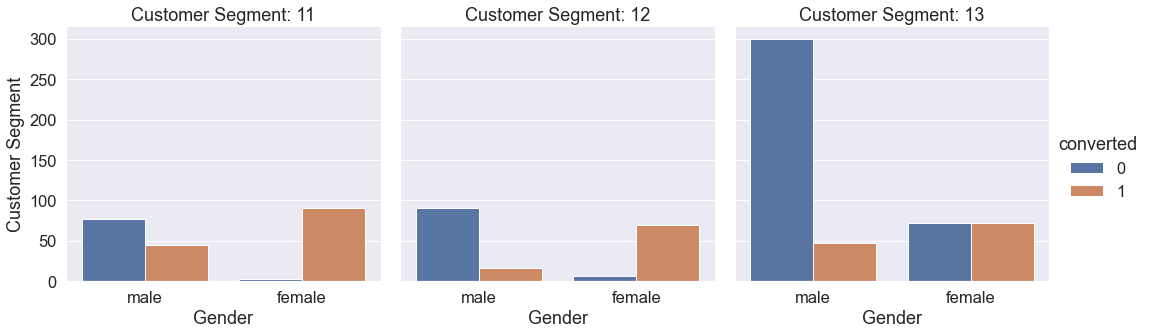

In [240]:
plot = sns.catplot(x='gender', col='customer_segment', hue='converted', data=regression_age_df, kind='count')

plot.set_axis_labels("Gender", "Customer Segment")
plot.set_titles("Customer Segment: {col_name}")

### 2.4. Age Missing Values Conclusion
We can use the regression to impute missing values. I will continue the next steps with this dataset

In [241]:
regression_age_df.to_csv('imputed_age_df.csv',index=False)

In [242]:
regression_age_df.head()

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,credit_account_id,gender,branch
0,0,13,22.0,1,0,14.5000,0,male,Helsinki
1,1,11,38.0,1,0,142.5666,1,female,Tampere
2,1,13,26.0,0,0,15.8500,0,female,Helsinki
3,1,11,35.0,1,0,106.2000,1,female,Helsinki
4,0,13,35.0,0,0,16.1000,0,male,Helsinki


## 3. Gender and Age Group Insights
We want to investigate whether gender and age groups have some indication on conversion. The main premise here is that men and women at a certain age will have different interest, motivation, and dedication to reach their goal

In [243]:
## we read in the dataset that contains predicted ages for the missing age values
data = pd.read_csv("imputed_age_df.csv")

In [244]:
data.head()

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,credit_account_id,gender,branch
0,0,13,22.0,1,0,14.5000,0,male,Helsinki
1,1,11,38.0,1,0,142.5666,1,female,Tampere
2,1,13,26.0,0,0,15.8500,0,female,Helsinki
3,1,11,35.0,1,0,106.2000,1,female,Helsinki
4,0,13,35.0,0,0,16.1000,0,male,Helsinki


In [245]:
corr = data.corr()

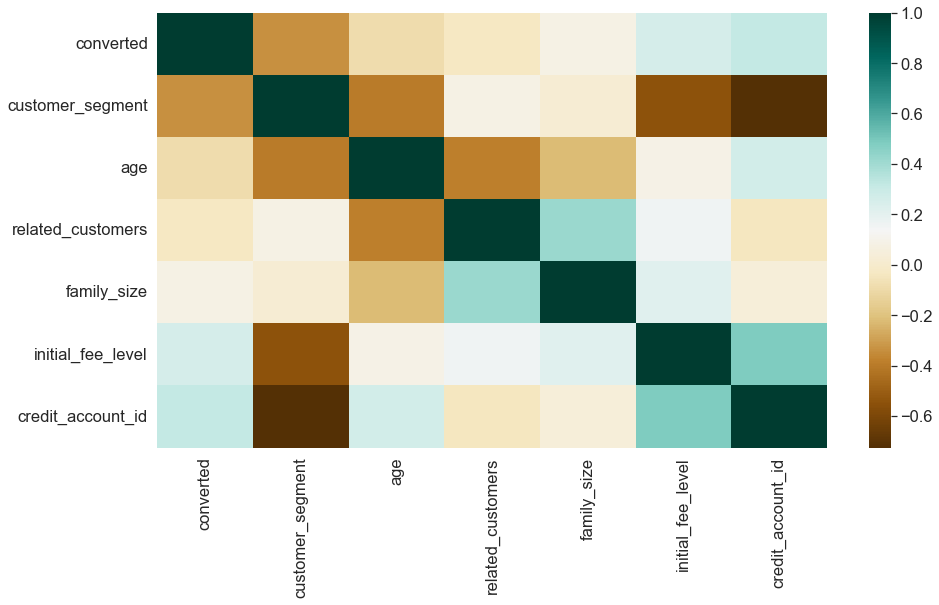

In [246]:
## Let's plot a correlation map to see if some features have some kind of a relationship (initial)
sns.heatmap(corr,cmap='BrBG')

plt.savefig('correlation_matrix.png')

In [247]:
## Initial fee level and credit_account_id seem to be slightly correlated to converted.

In [248]:
## first, let's create the age groups. I will use the following ages:
## < 15, 15-18, 19-29, 30-39, 40-49, 50-59, 60+
## I am making this column a numeric one so I don't have to label-encode it later on

data['age_group'] = np.where(
    data['age'] < 15, 0,
    np.where((data['age'] >= 15) & (data['age'] < 19), 1,
             np.where((data['age'] >= 19) & (data['age'] < 30), 2,
                      np.where((data['age'] >= 30) & (data['age'] < 40), 3,
                               np.where((data['age'] >= 40) & (data['age'] < 50), 4,
                                        np.where((data['age'] >= 50) & (data['age'] < 60), 5,
                                                 np.where(data['age'] >= 60, 6, 'unknown')
                                                 )
                                        )
                               )
                      )
             )
).astype(int)

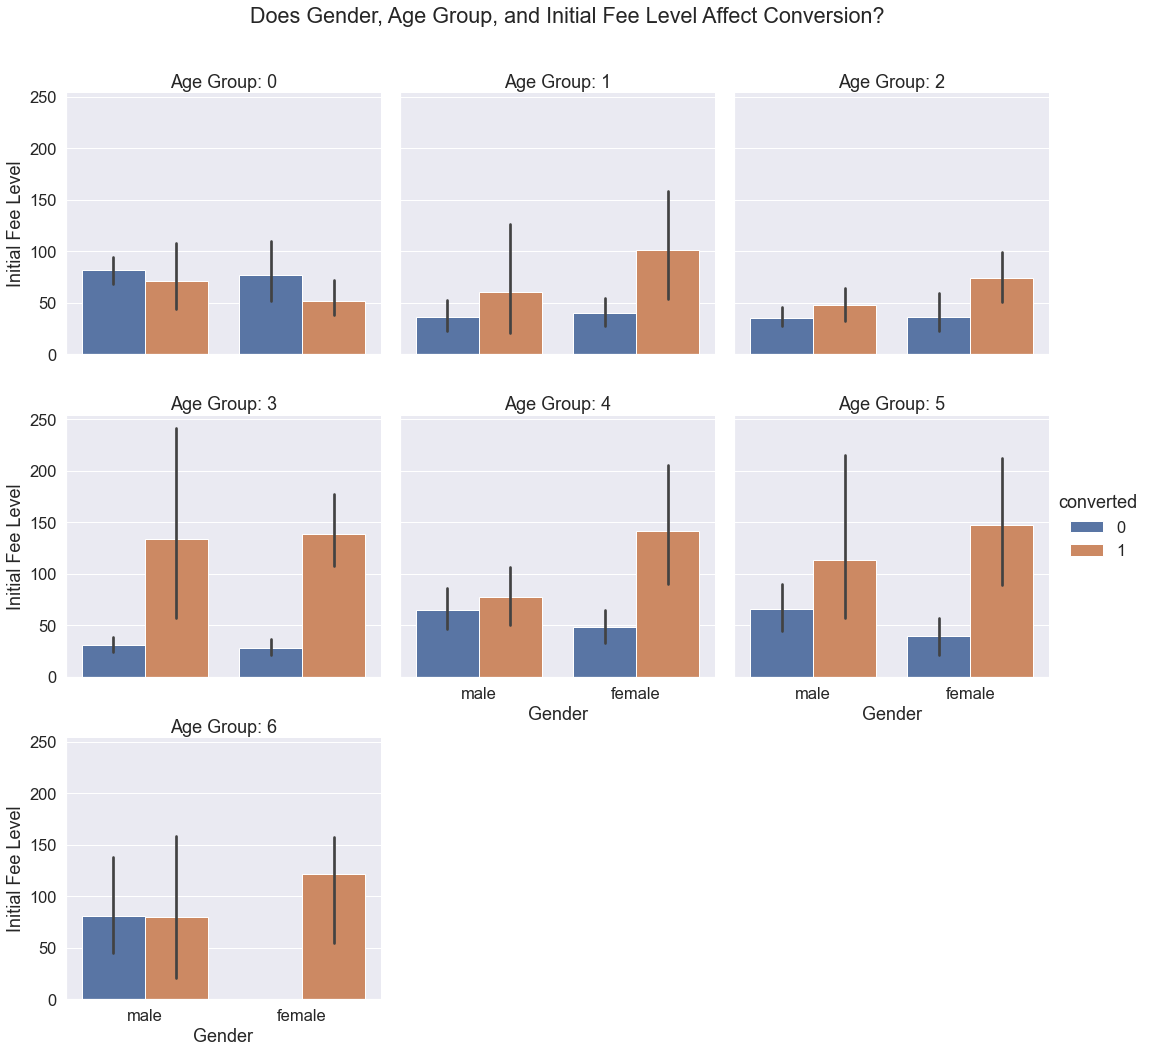

In [249]:
# age_group:
# 0: < 15, 
# 1: 15-18, 
# 2: 19-29, 
# 3: 30-39, 
# 4: 40-49, 
# 5: 50-59, 
# 6: 60+
plot = sns.catplot(x='gender', y='initial_fee_level', hue='converted', col='age_group',
            kind='bar', data=data, col_wrap = 3) ## col_wrap determines how many plots
                                                                    ## there will be per row
plt.subplots_adjust(top=0.9)
plot.set_axis_labels("Gender", "Initial Fee Level")
plot.fig.suptitle("Does Gender, Age Group, and Initial Fee Level Affect Conversion?")
plot.set_titles("Age Group: {col_name}")

In [250]:
## Interesting, women that convert in all but 2 age groups have higher initial fees

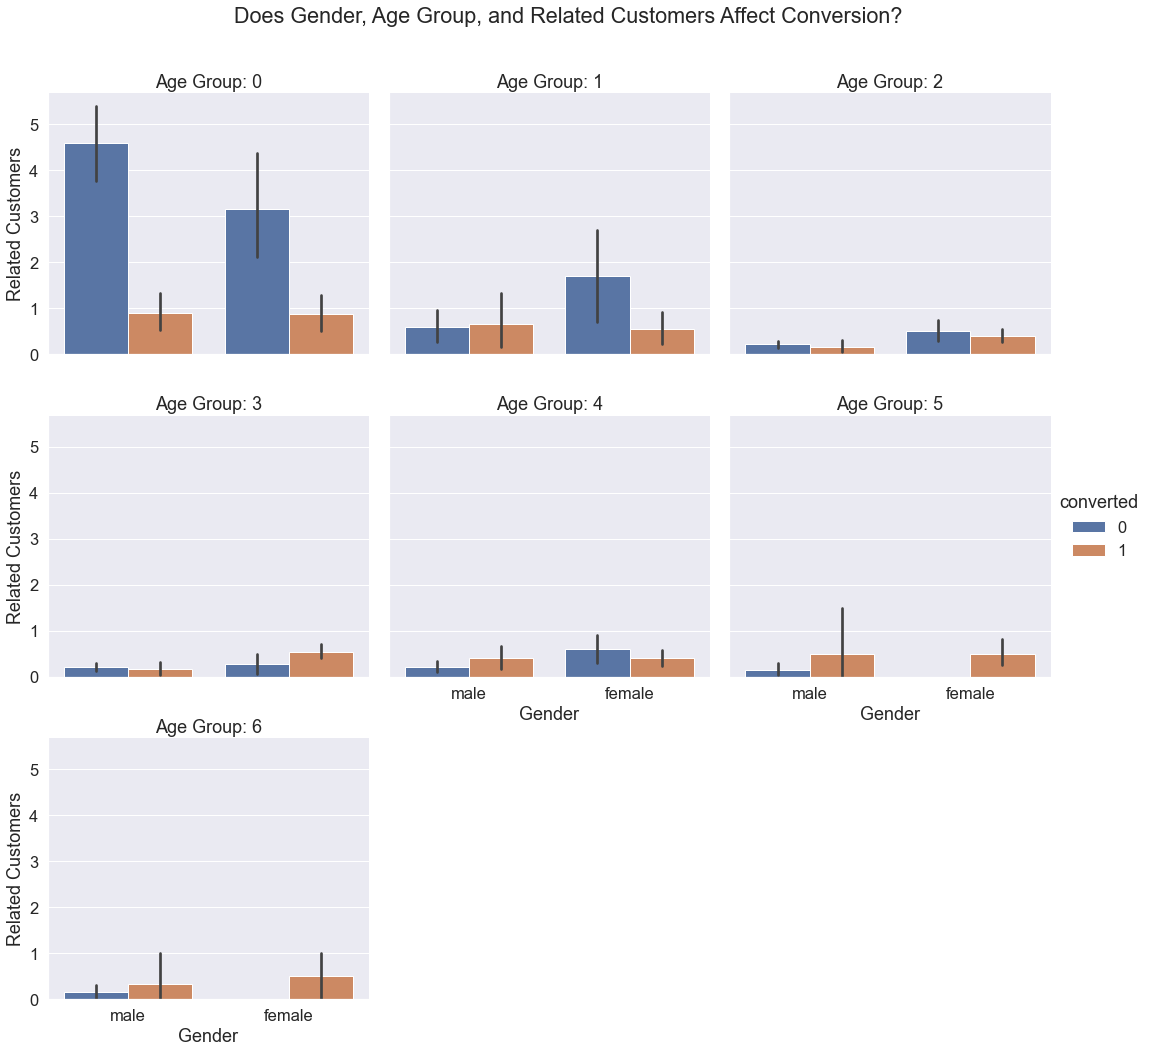

In [251]:
plot = sns.catplot(x='gender', y='related_customers', hue='converted', col='age_group',
            kind='bar', data=data, col_wrap = 3) ## col_wrap determines how many plots
                                                                    ## there will be per row
plt.subplots_adjust(top=0.9)
plot.set_axis_labels("Gender", "Related Customers")
plot.fig.suptitle("Does Gender, Age Group, and Related Customers Affect Conversion?")
plot.set_titles("Age Group: {col_name}")

In [252]:
### The age group of younger than 15 has a higher number of related customers, presumably parents? This age group
### does not convert very often

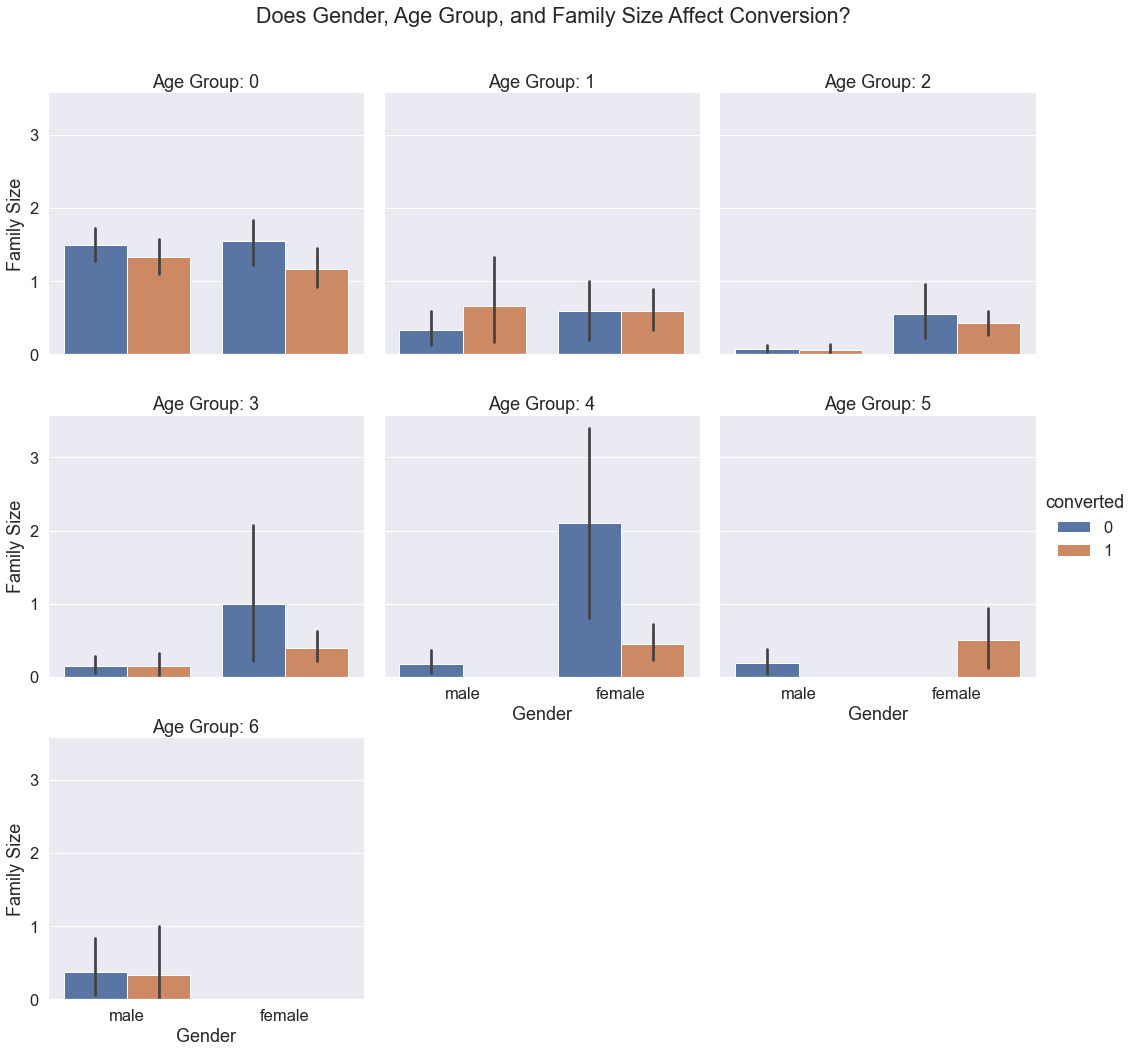

In [253]:
plot = sns.catplot(x='gender', y='family_size', hue='converted', col='age_group',
            kind='bar', data=data, col_wrap = 3) ## col_wrap determines how many plots
                                                                    ## there will be per row
plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Does Gender, Age Group, and Family Size Affect Conversion?")
plot.set_axis_labels("Gender", "Family Size")
plot.set_titles("Age Group: {col_name}")

In [254]:
## Both men and women in the first age group have a slightly increased family size number but they don't convert
## Women in the 40-49 year range have an increased family size but don't convert.

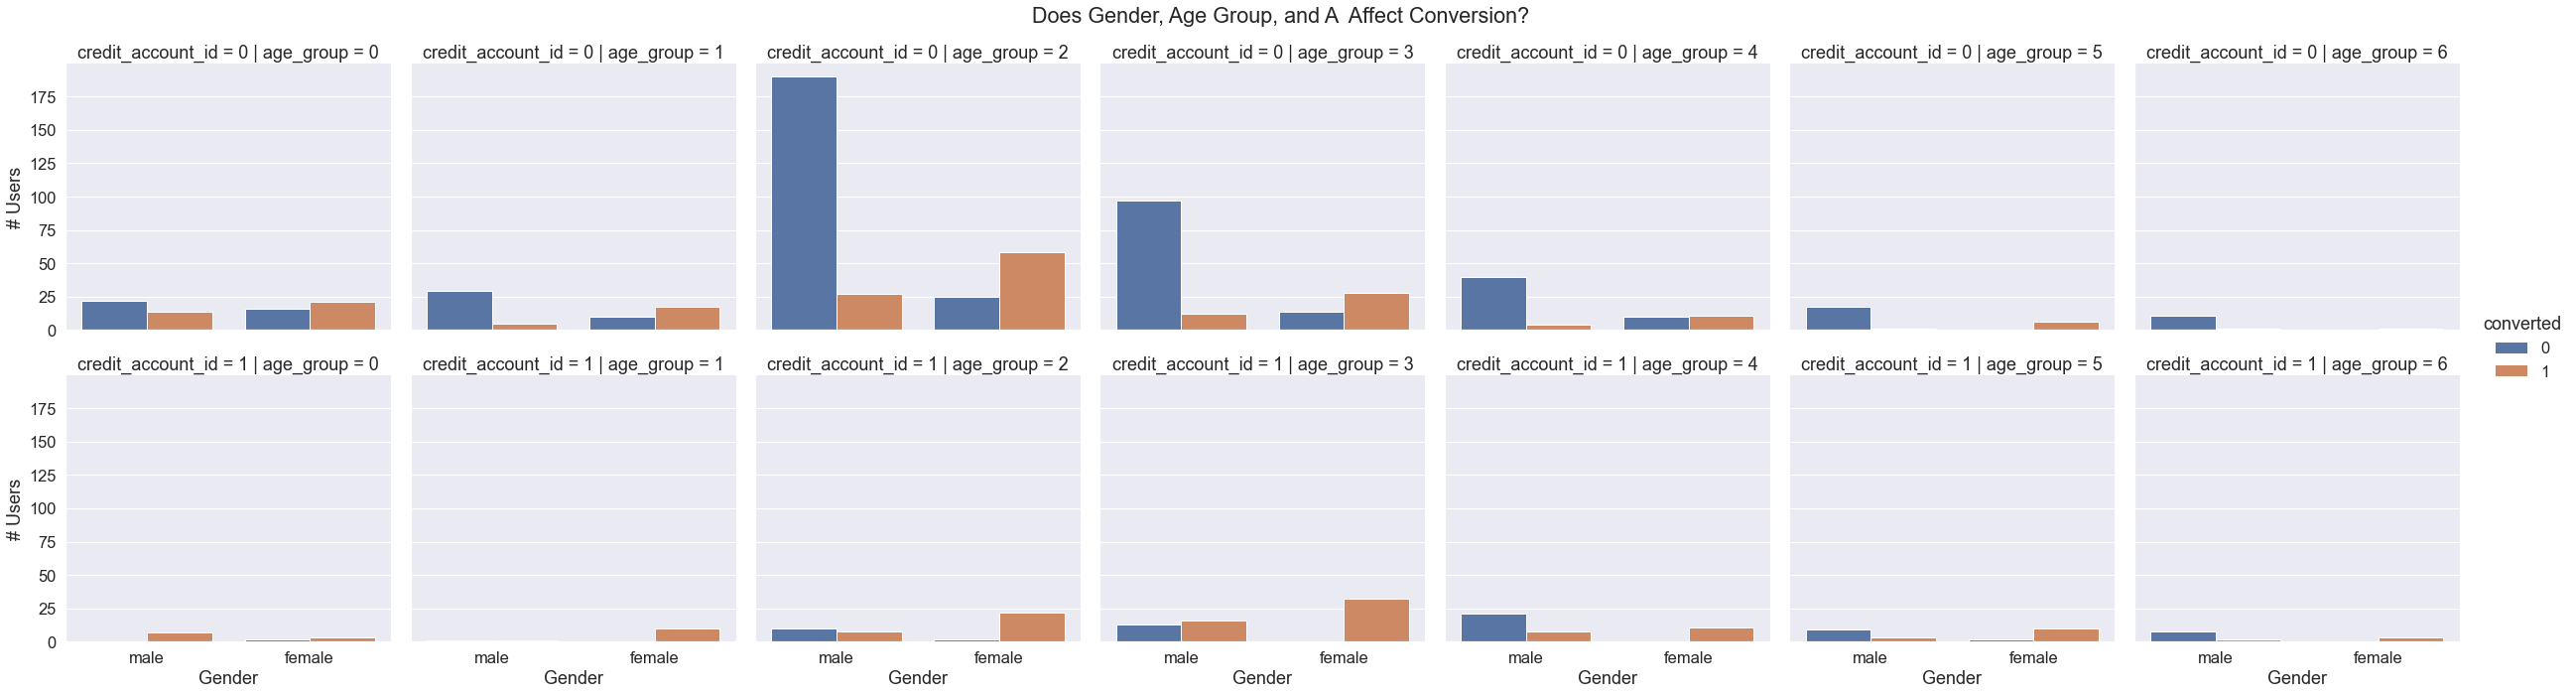

In [255]:
plot = sns.catplot(x='gender', hue='converted', row='credit_account_id', col='age_group',
            kind='count', data=data, ci=None)  

plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Does Gender, Age Group, and A  Affect Conversion?")
plot.set_axis_labels("Gender", "# Users")
#plot.set_titles("Has Account: {row_name}, Age Group: {col_name}")

In [256]:
## The titles for the charts look a bit messy, but the first row is for people who don't have an account
## and the second is for people that have account. Each chart is for a different age group. There is
## a high number of men in the 20-29 age range, as well as the 30-39 age range, who don't have a credit account
## but don't convert. Similar to other insights above, this could be an area of more focus

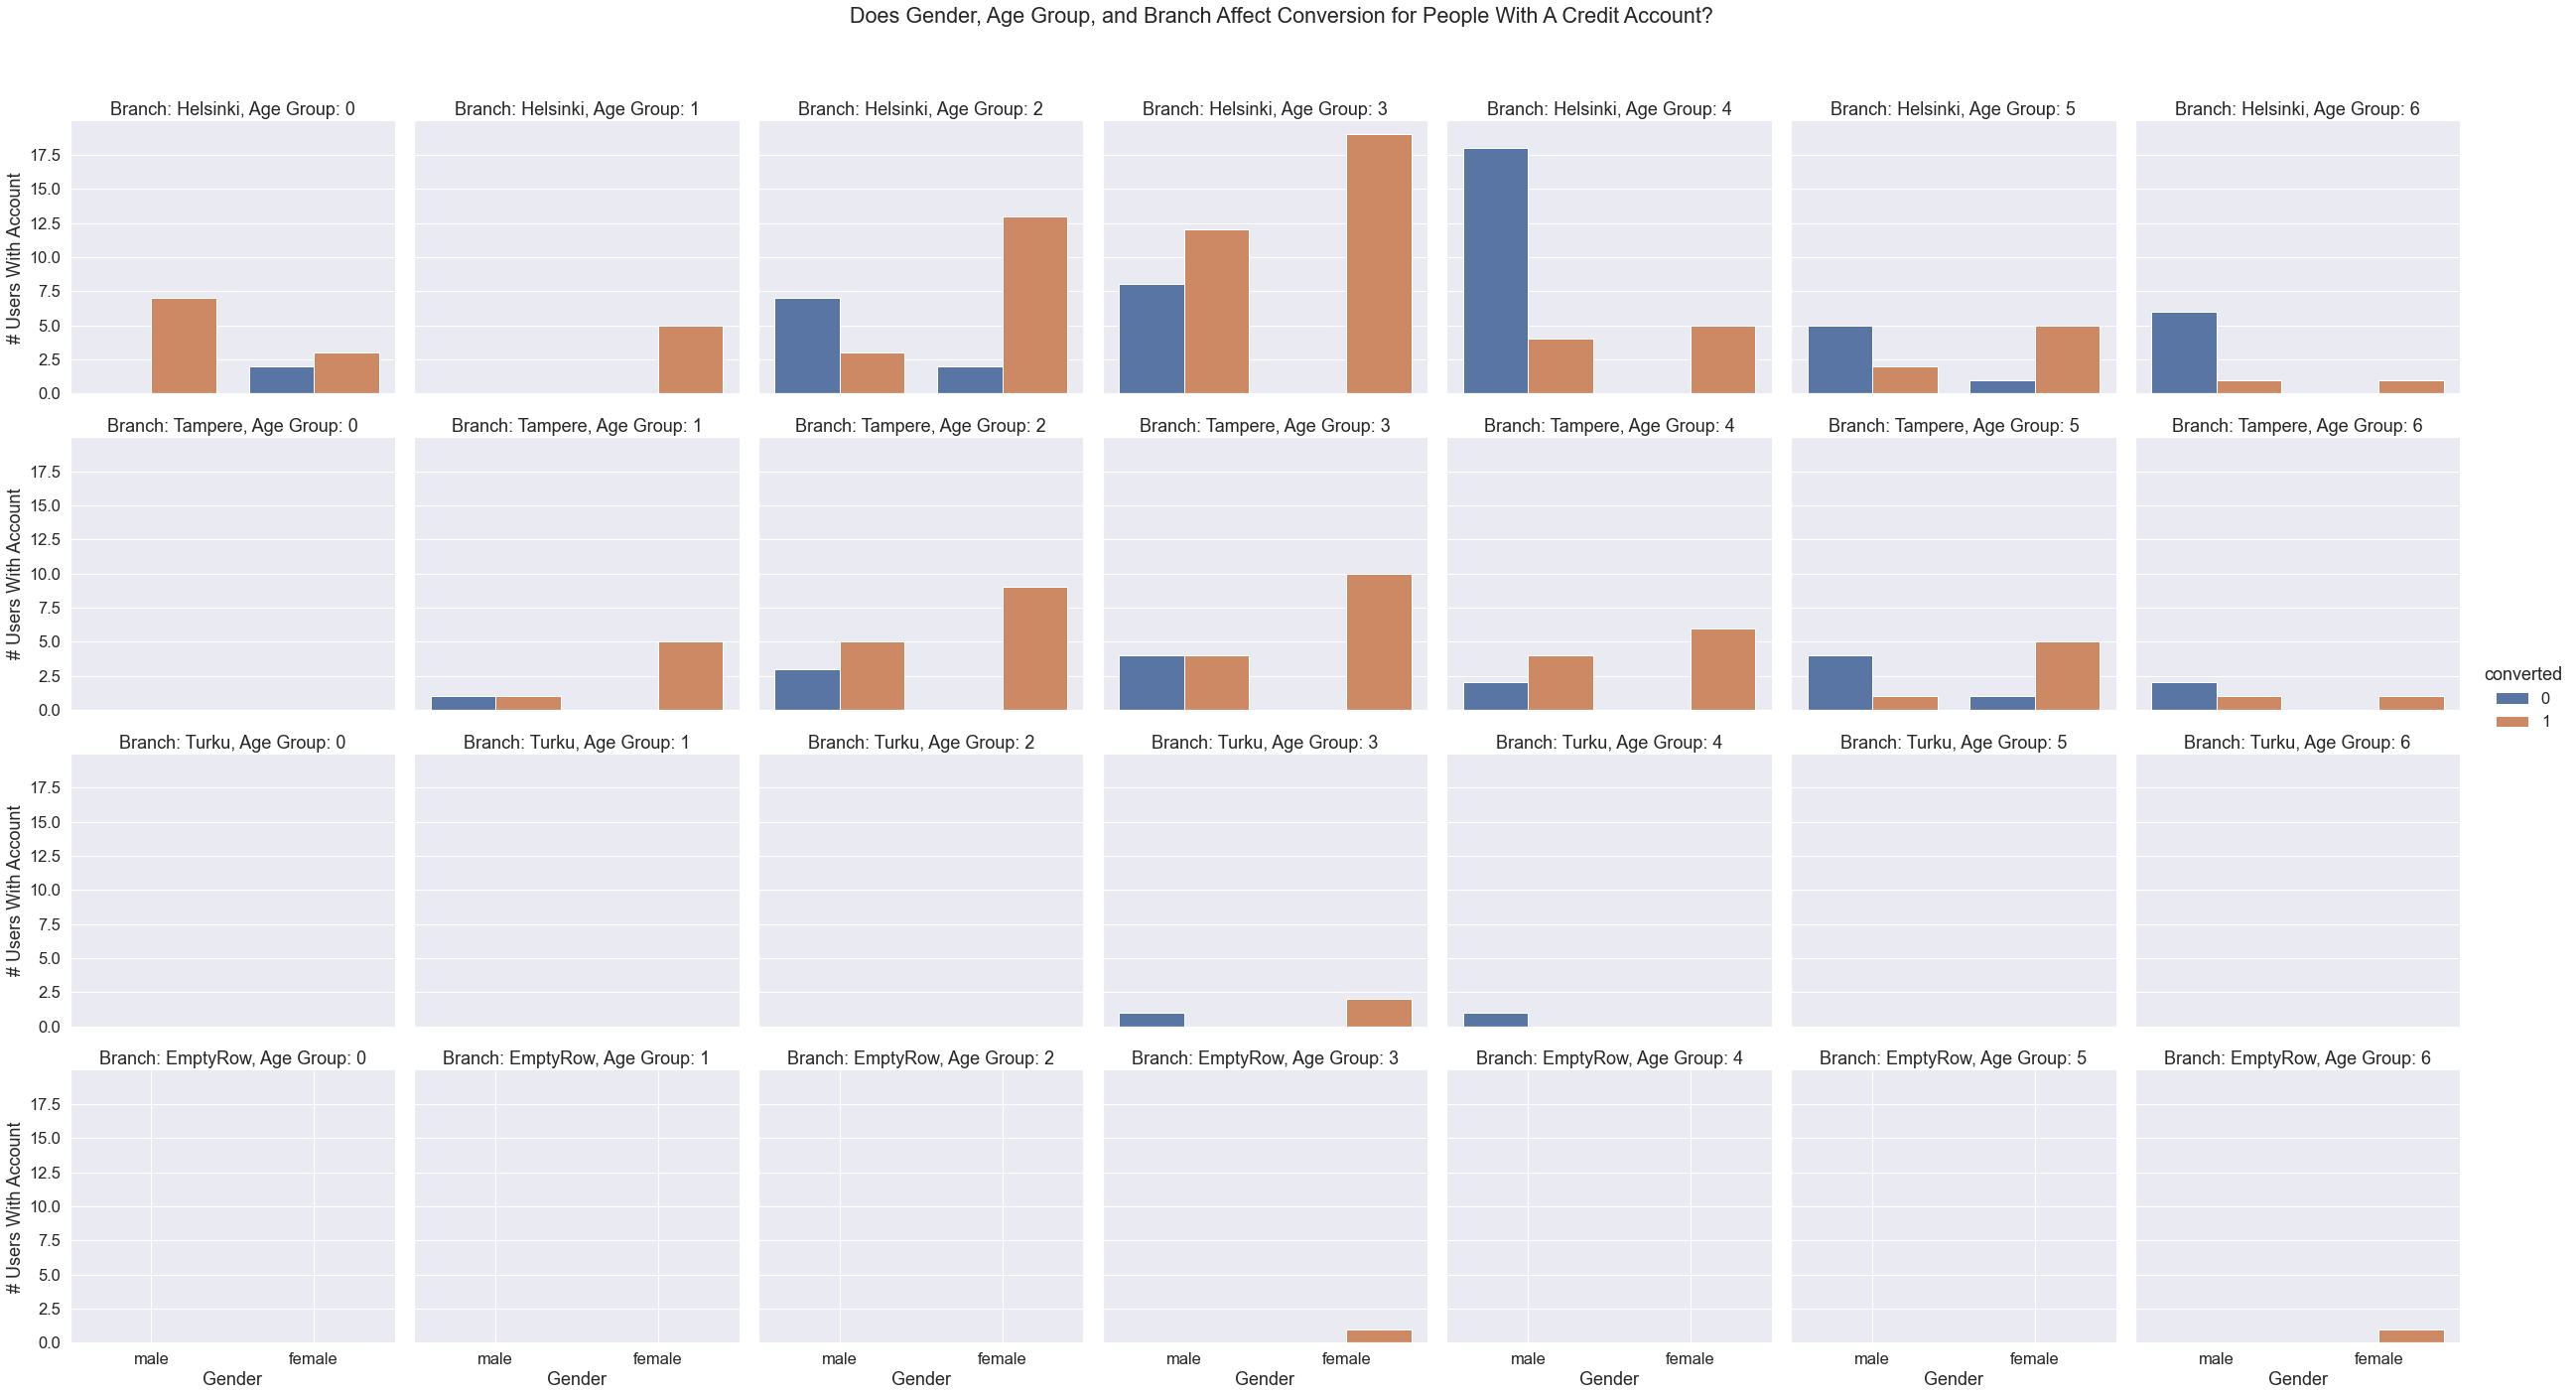

In [257]:
plot = sns.catplot(x='gender', hue='converted', y='credit_account_id', col='age_group', row='branch',
            kind='bar', data=data,  ci=None,
            estimator=lambda x: (x == 1).sum())  # Count occurrences of people with credit account

plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Does Gender, Age Group, and Branch Affect Conversion for People With A Credit Account?")
plot.set_axis_labels("Gender", "# Users With Account")
plot.set_titles("Branch: {row_name}, Age Group: {col_name}")

In [258]:
### Women from Helsinki in the 20-29 and 30-39 age groups who have a credit account
### convert much more than other groups. Similar situation is present in Tampere. 
### There are a lot of men from Helsinki in the 40-49 age group with a credit account that don't convert.

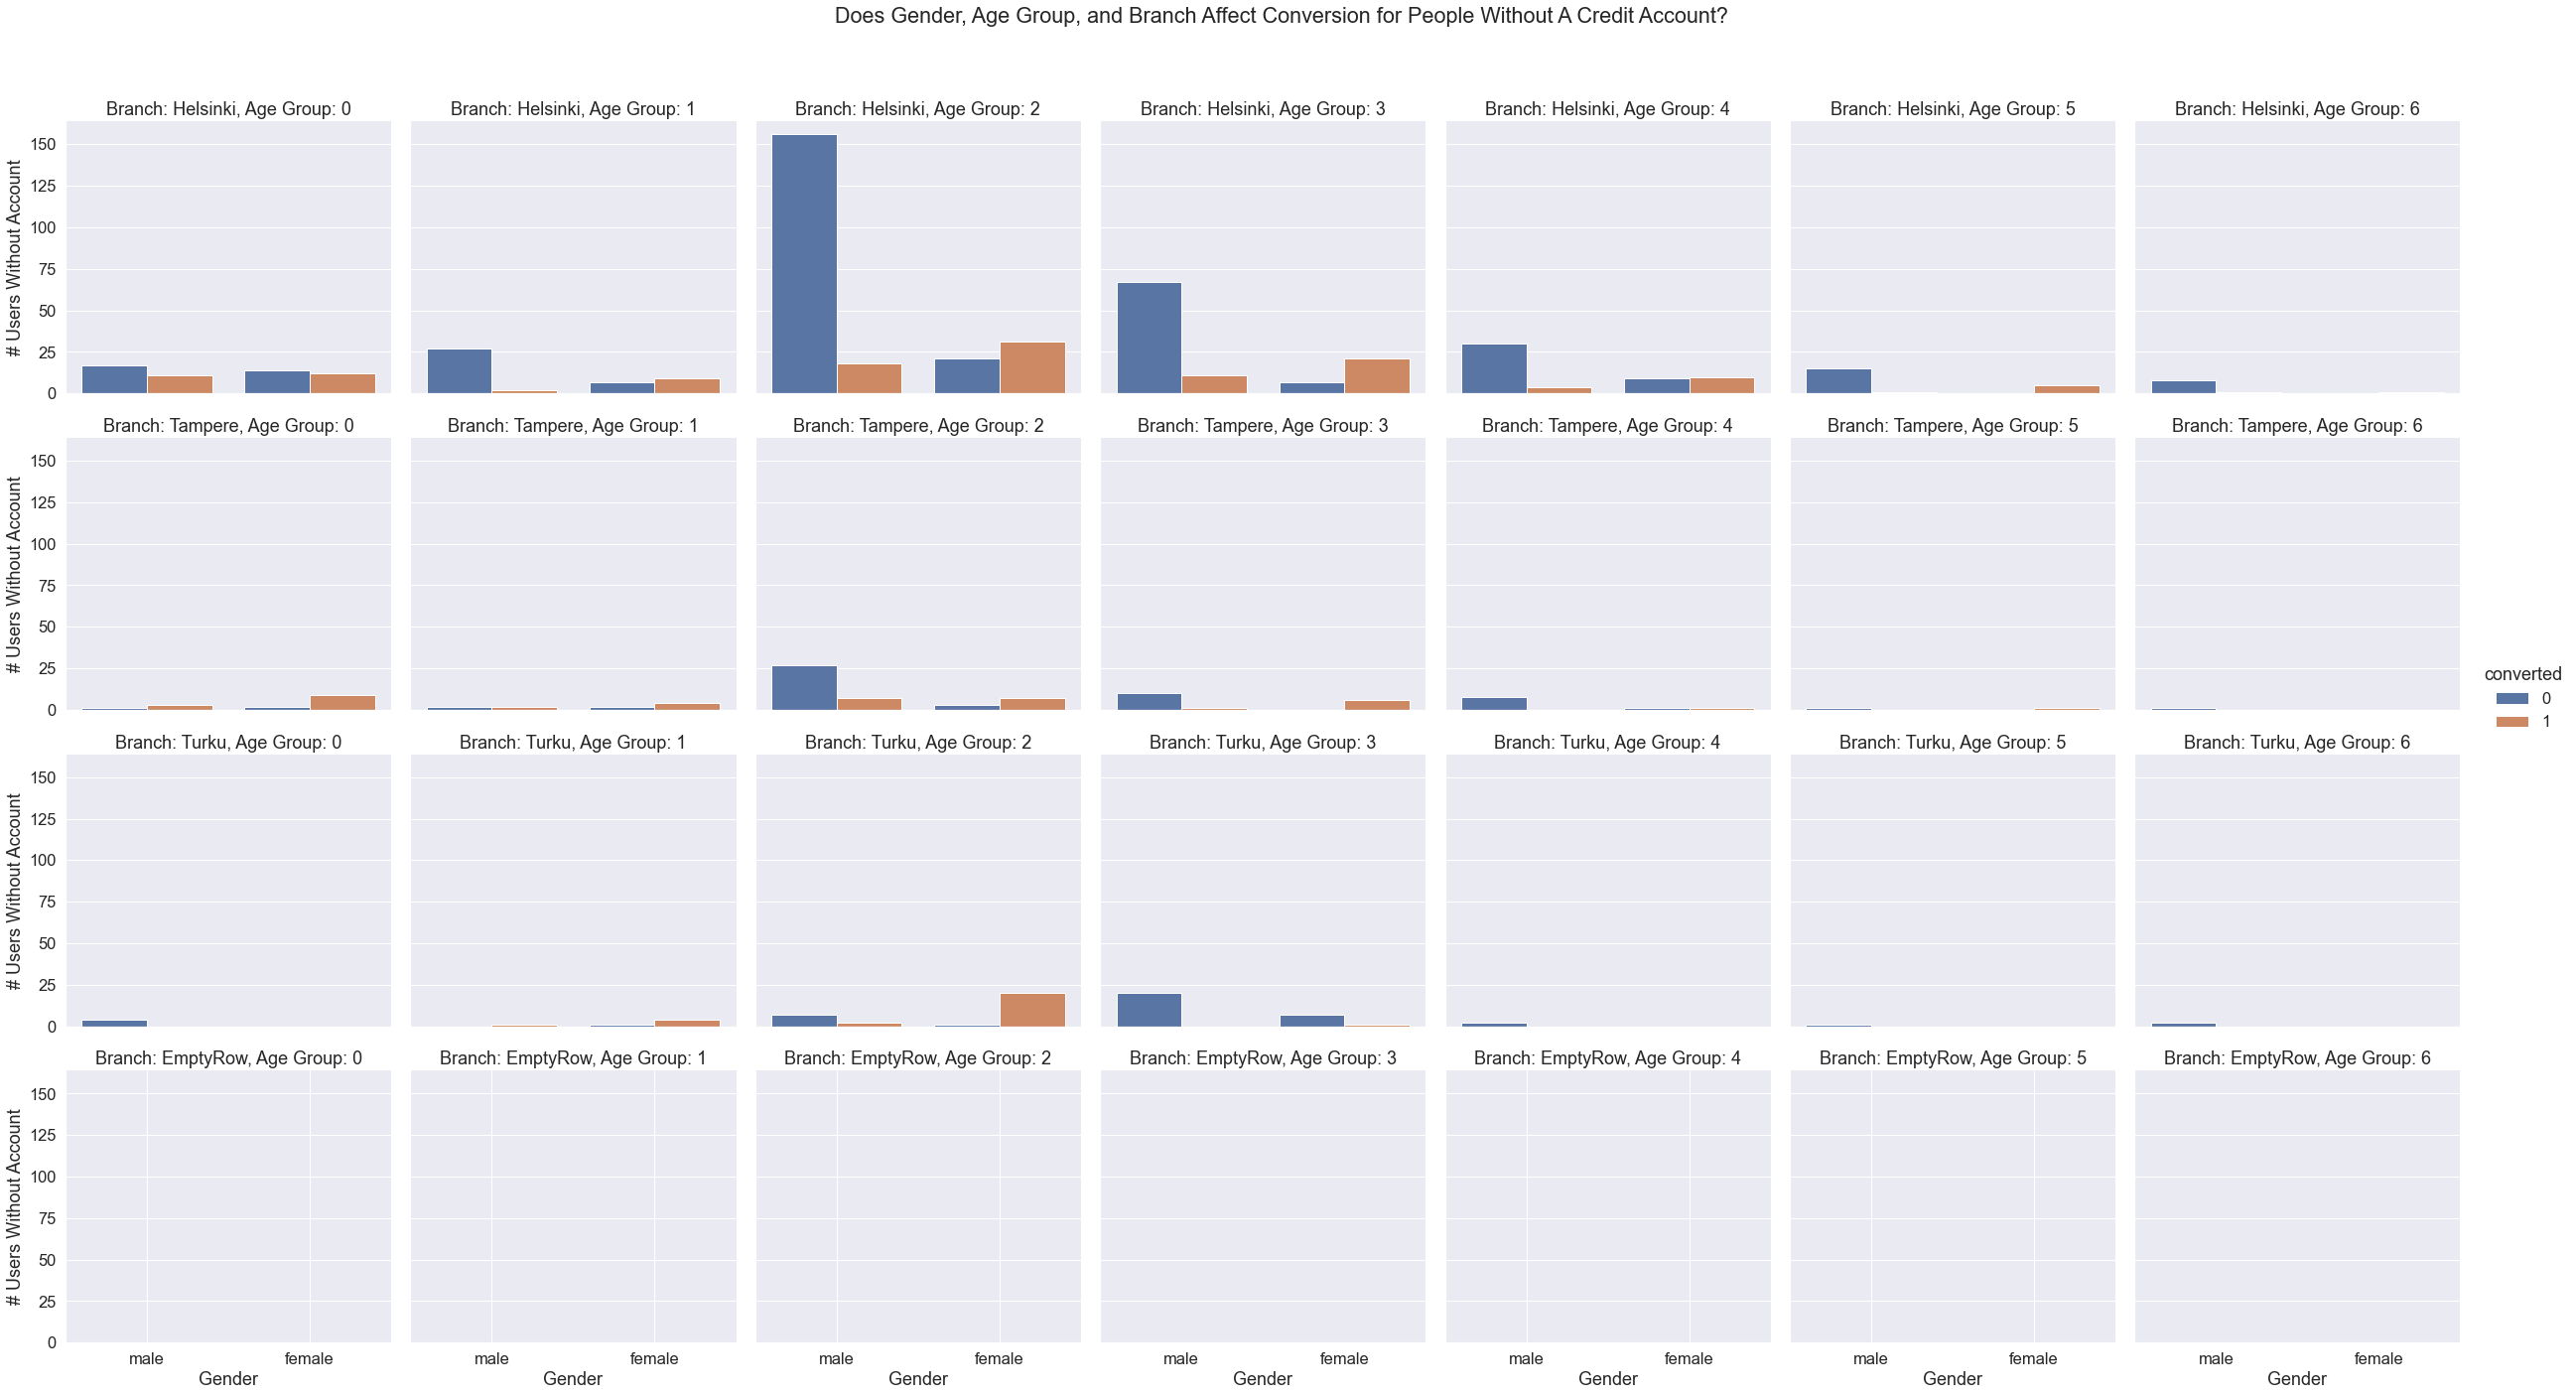

In [259]:
plot = sns.catplot(x='gender', hue='converted', y='credit_account_id', col='age_group', row='branch',
            kind='bar', data=data,  ci=None,
            estimator=lambda x: (x == 0).sum())  # Count occurrences of people without credit account

plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Does Gender, Age Group, and Branch Affect Conversion for People Without A Credit Account?")
plot.set_axis_labels("Gender", "# Users Without Account")
plot.set_titles("Branch: {row_name}, Age Group: {col_name}")

In [260]:
### People with a credit account don't convert often. There is a high number of men from Helsinki 
### without an account who don't convert.

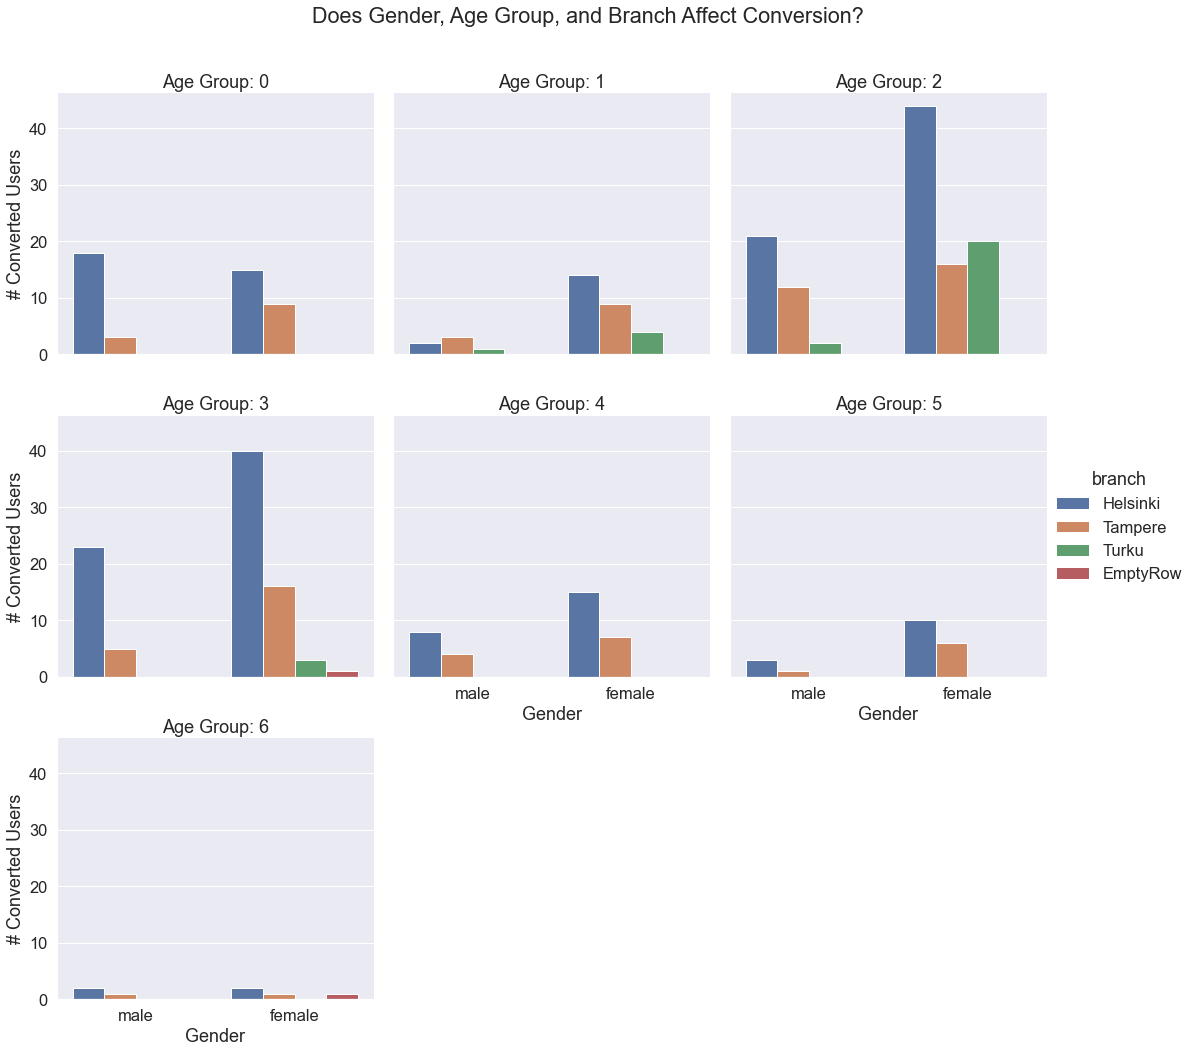

In [261]:
plot = sns.catplot(x='gender', hue='branch', y='converted', col='age_group',
            kind='bar', data=data,  ci=None, estimator=lambda x: (x == 1).sum(),
            col_wrap = 3)  # Count occurrences of converted users

plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Does Gender, Age Group, and Branch Affect Conversion?")
plot.set_axis_labels("Gender", "# Converted Users")
plot.set_titles("Age Group: {col_name}")

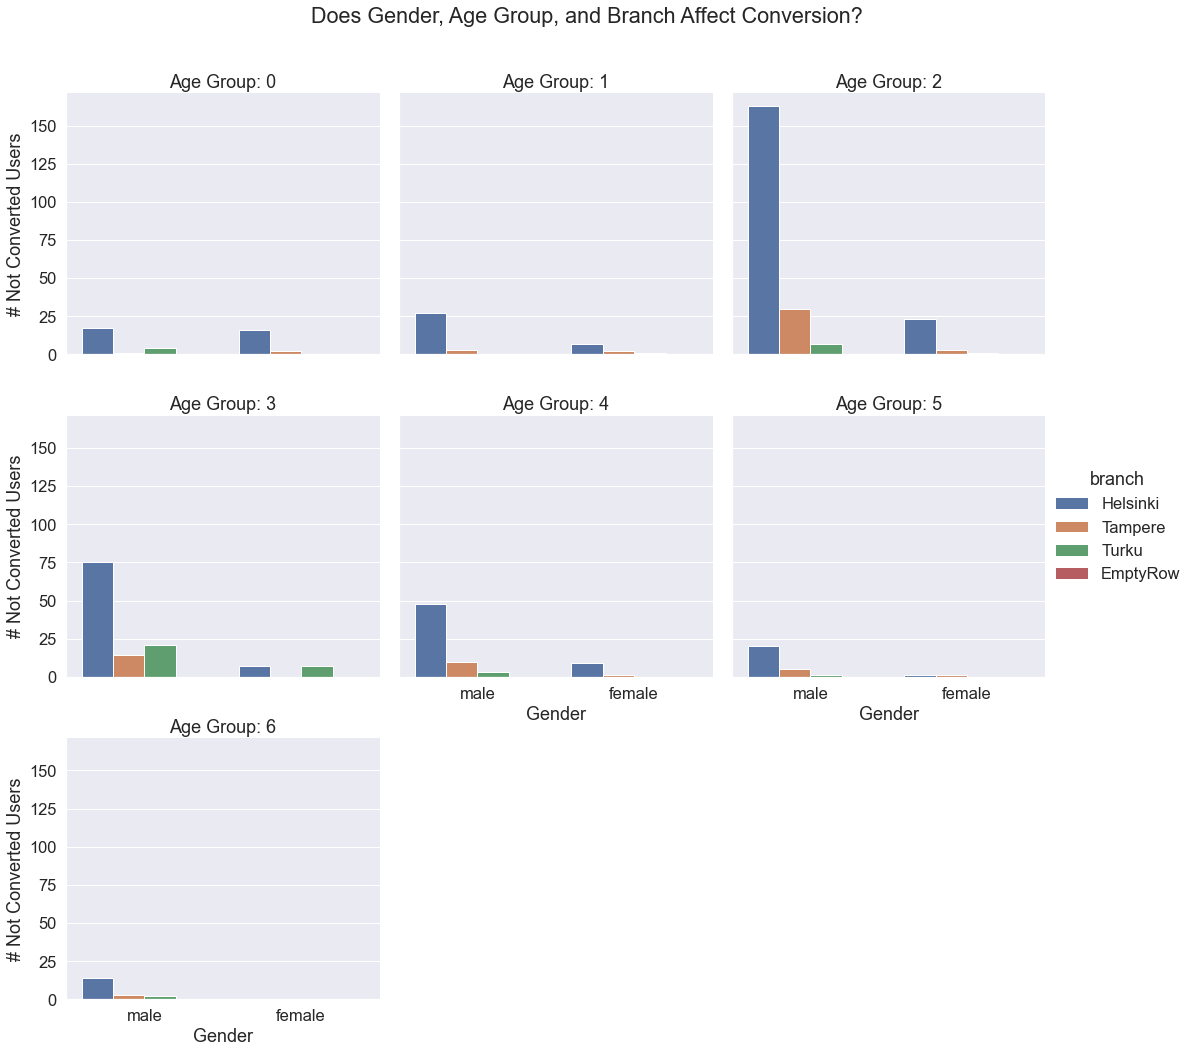

In [262]:
plot = sns.catplot(x='gender', hue='branch', y='converted', col='age_group',
            kind='bar', data=data,  ci=None, estimator=lambda x: (x == 0).sum(),
            col_wrap = 3)  # Count occurrences of not converted users

plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Does Gender, Age Group, and Branch Affect Conversion?")
plot.set_axis_labels("Gender", "# Not Converted Users")
plot.set_titles("Age Group: {col_name}")

In [263]:
## Women from Helsinki in the 20-29 and 30-39 age groups convert more, but there are a lot of men in Helsinki
## in the 20-29 age group who don't convert and should be investigated.

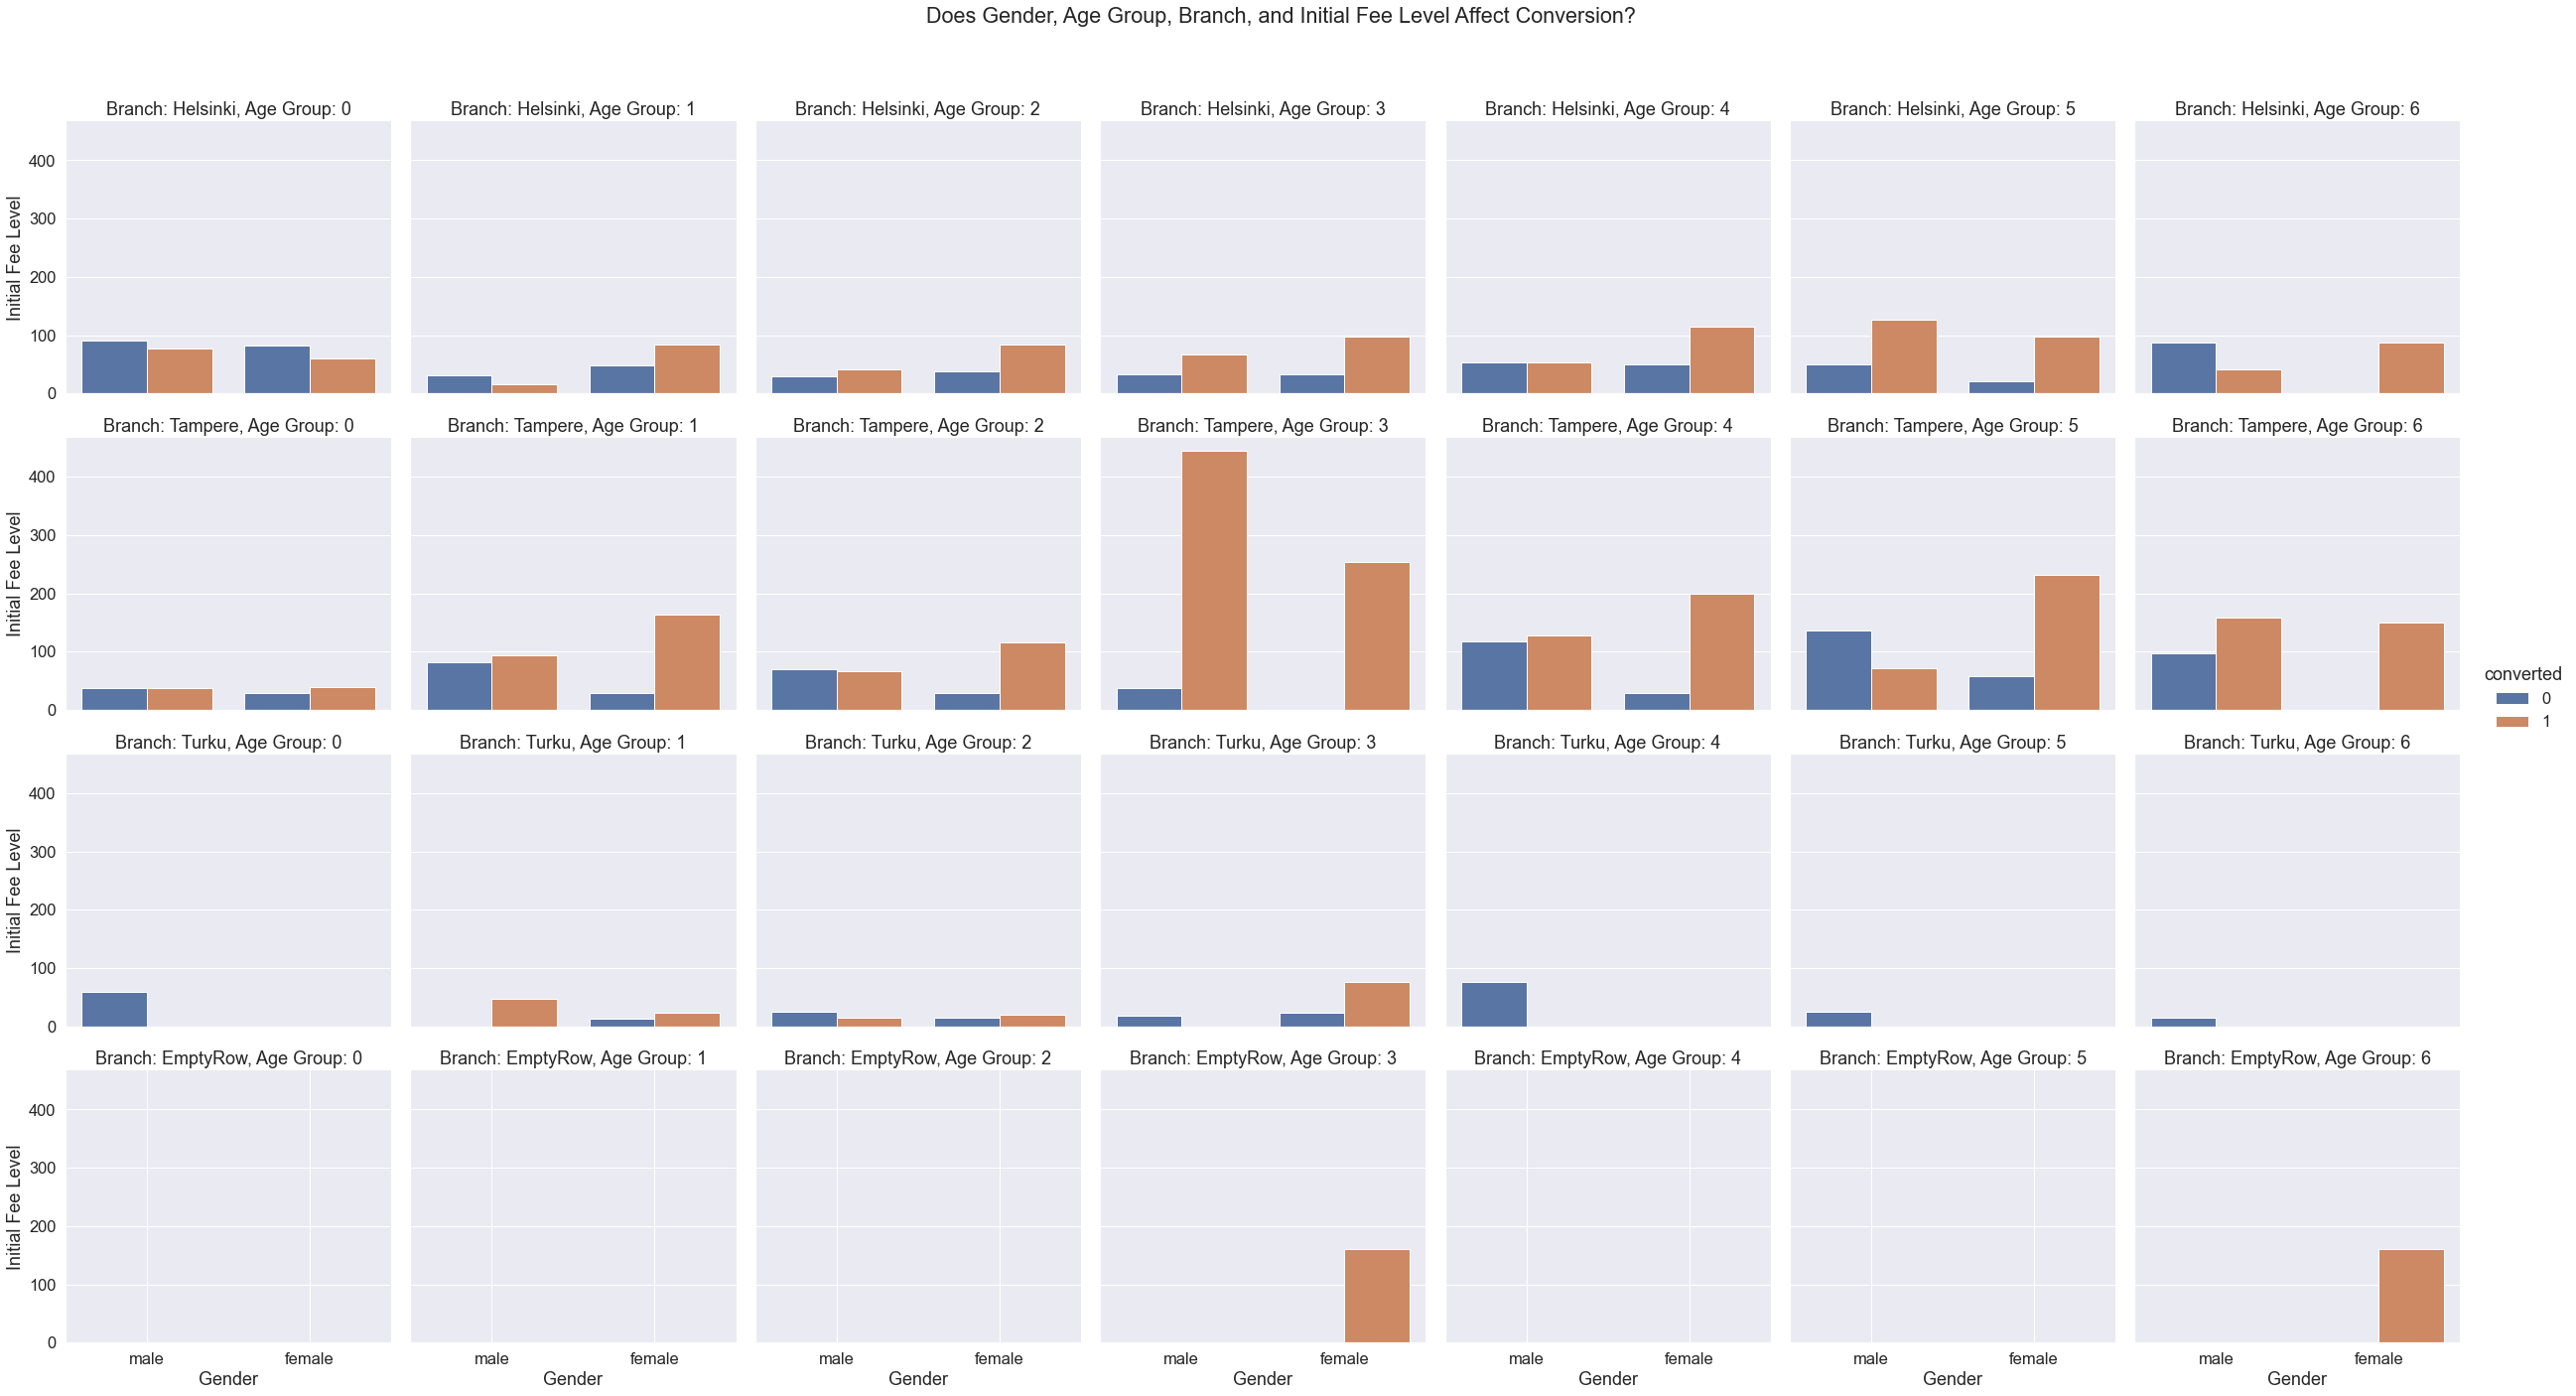

In [264]:
plot = sns.catplot(x='gender', hue='converted', y='initial_fee_level', col='age_group', row='branch',
            kind='bar', data=data,  ci=None) 

plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Does Gender, Age Group, Branch, and Initial Fee Level Affect Conversion?")
plot.set_axis_labels("Gender", "Initial Fee Level")
plot.set_titles("Branch: {row_name}, Age Group: {col_name}")

In [265]:
## Both men and women who converted in Tampere have high initial fees, and men have over 1.5 times higher fees
## than women in this cohort.

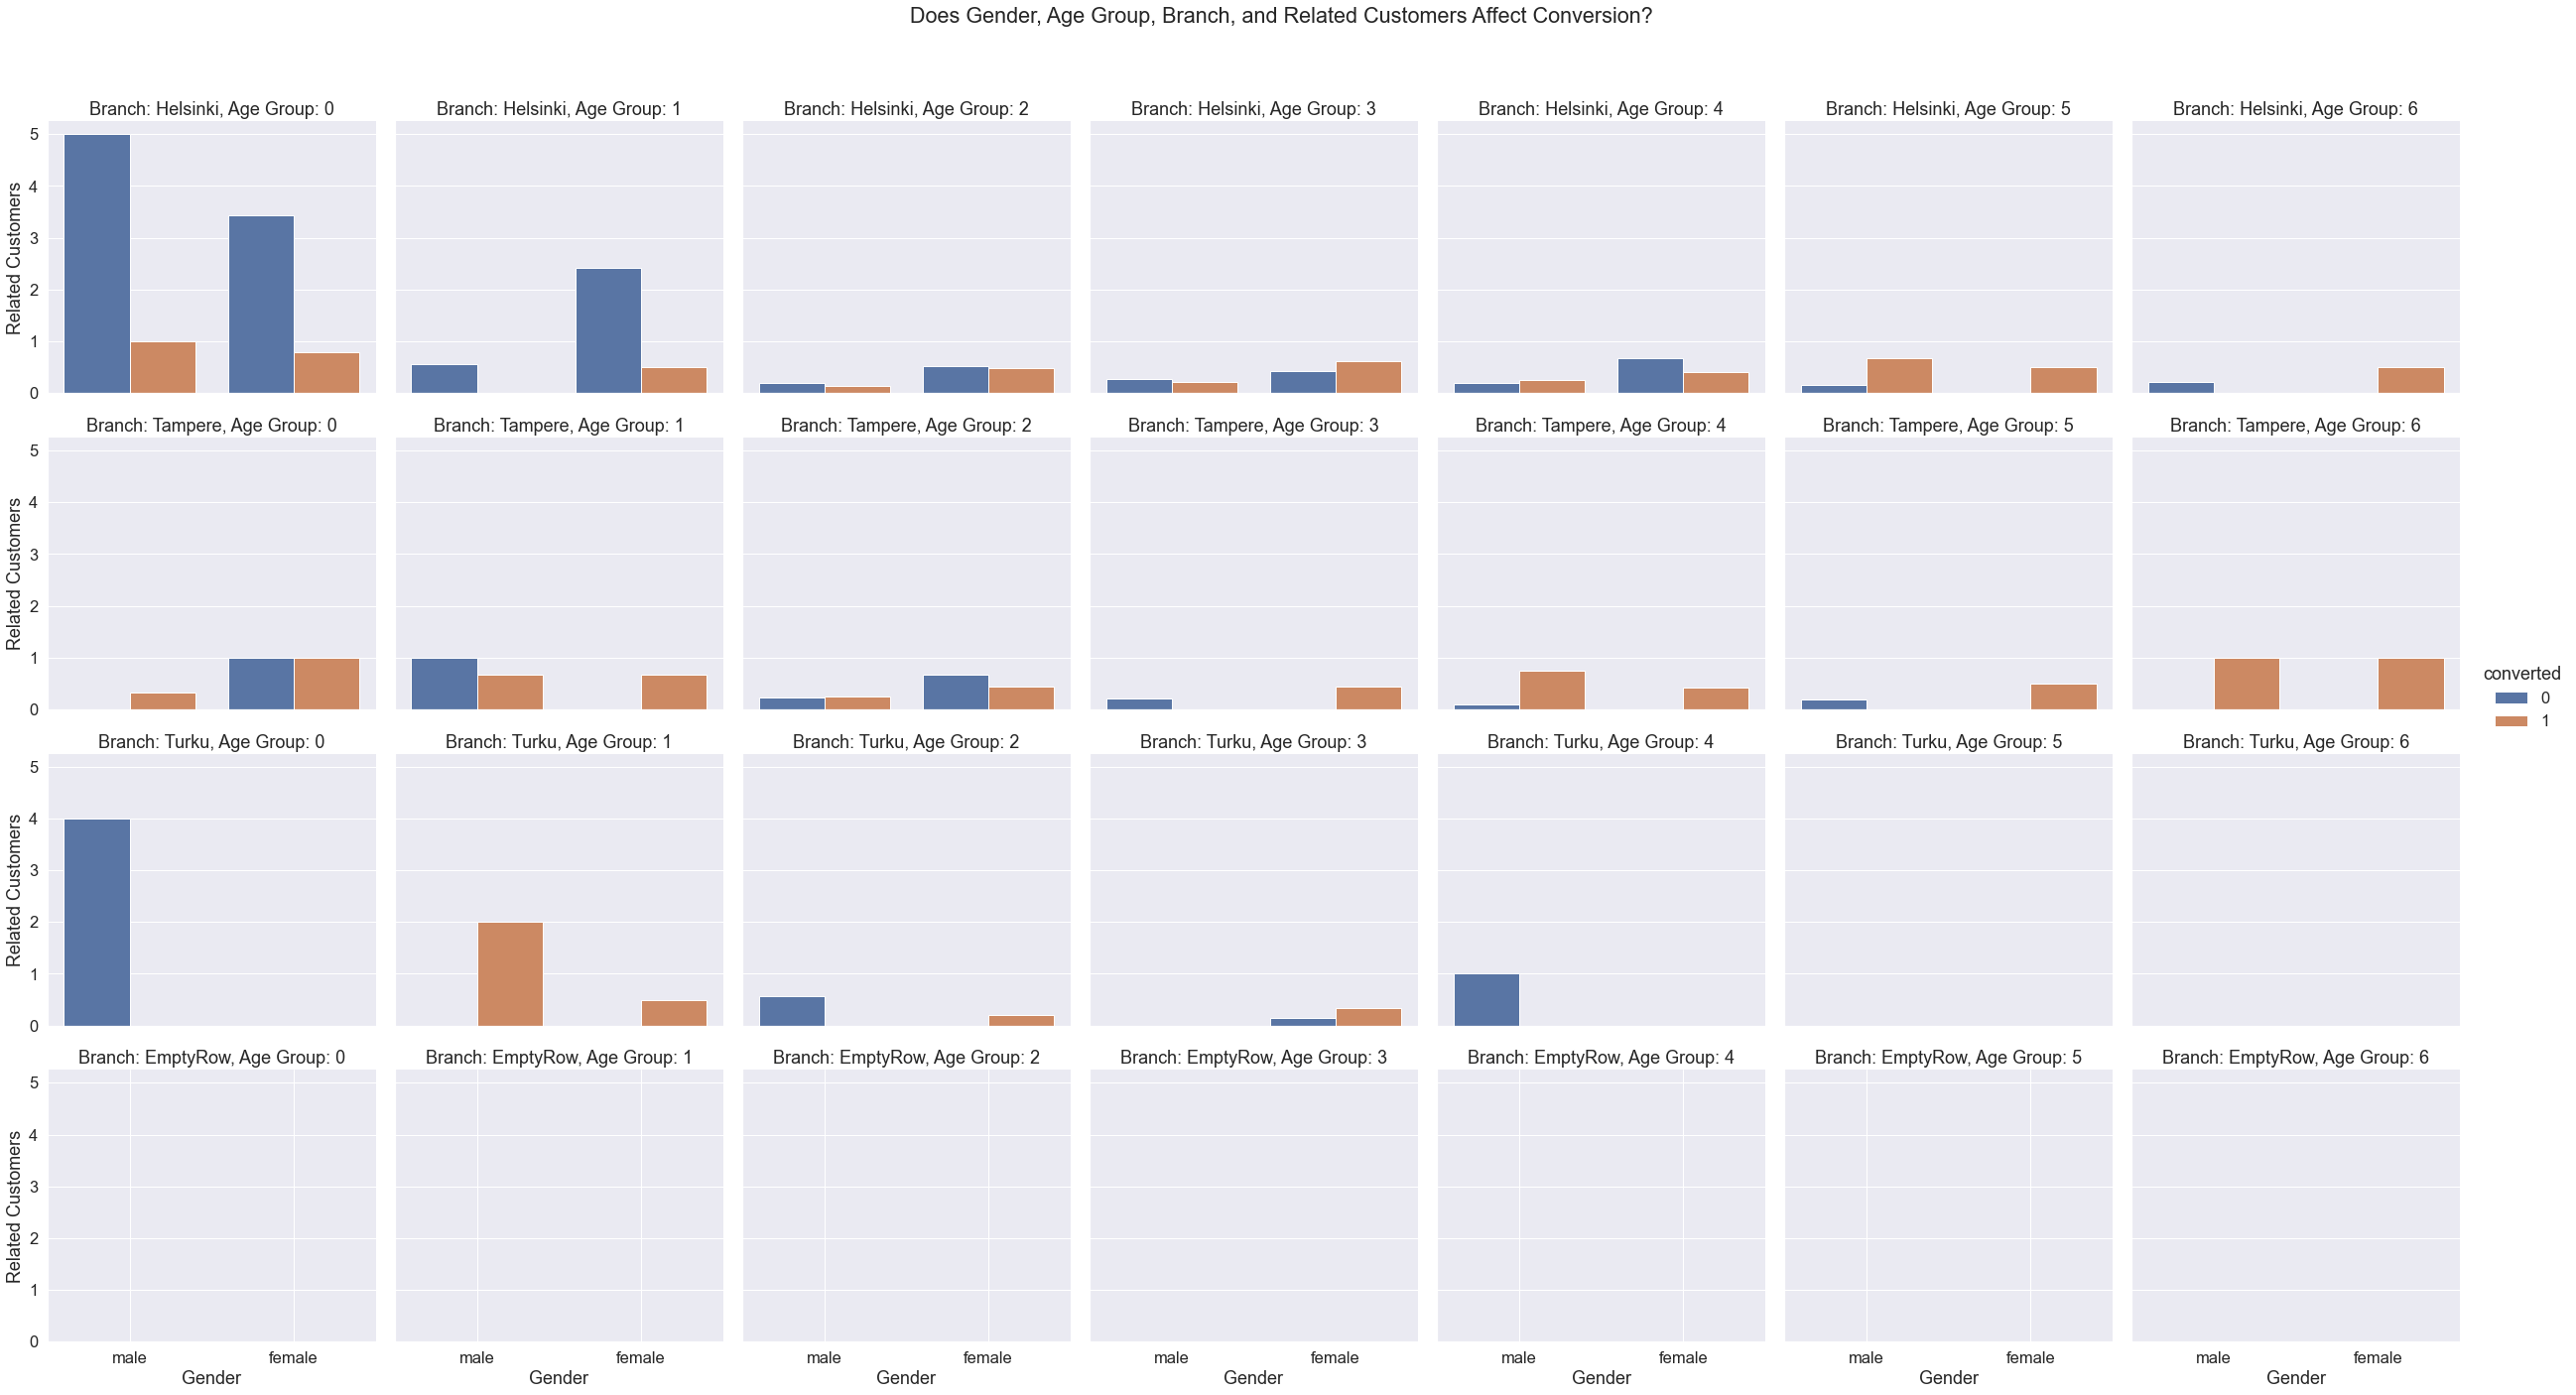

In [266]:
plot = sns.catplot(x='gender', hue='converted', y='related_customers', col='age_group', row='branch',
            kind='bar', data=data,  ci=None) 

plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Does Gender, Age Group, Branch, and Related Customers Affect Conversion?")
plot.set_axis_labels("Gender", "Related Customers")
plot.set_titles("Branch: {row_name}, Age Group: {col_name}")

In [267]:
# Men and women who don't convert and are in Helsinki and Turku have a higher number of related customers

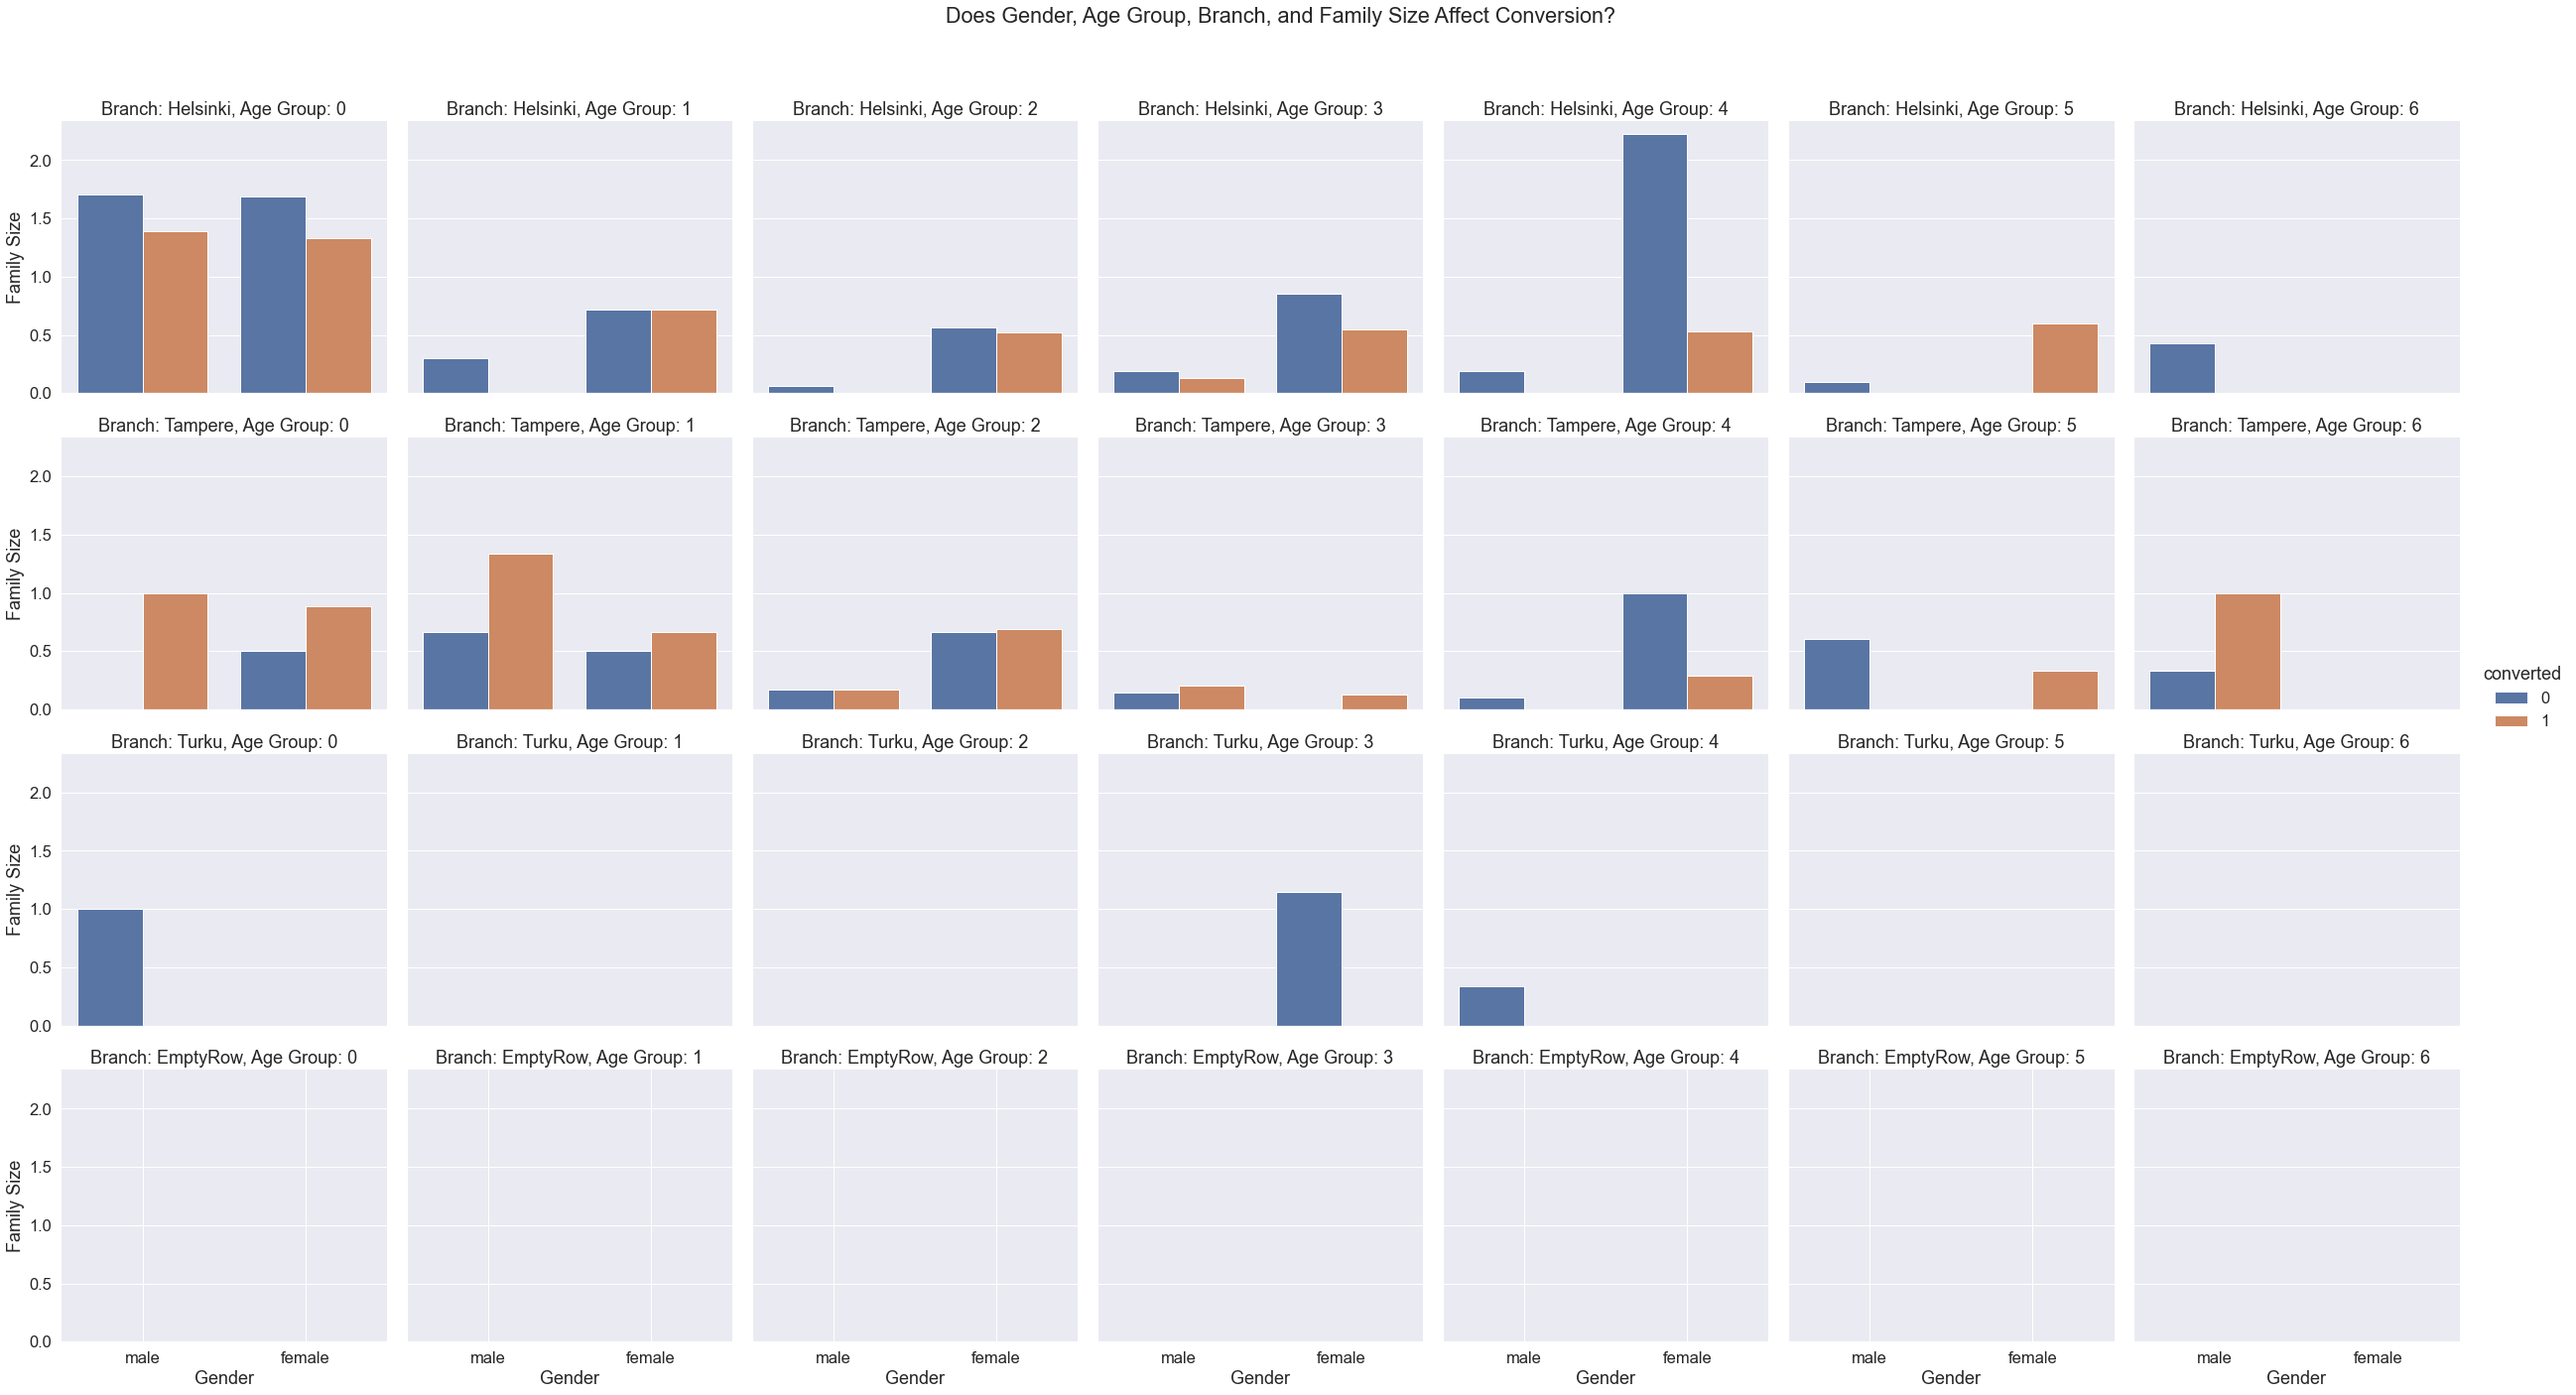

In [268]:
plot = sns.catplot(x='gender', hue='converted', y='family_size', col='age_group', row='branch',
            kind='bar', data=data,  ci=None) 

plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Does Gender, Age Group, Branch, and Family Size Affect Conversion?")
plot.set_axis_labels("Gender", "Family Size")
plot.set_titles("Branch: {row_name}, Age Group: {col_name}")

In [269]:
### There is a high number of women who don't convert from Helsinki in the 40-49 age group and have a higher
### family size. Family size is slightly higher in the <15 age group, but here both men and women have similar
### conversion and non-conversion rates.

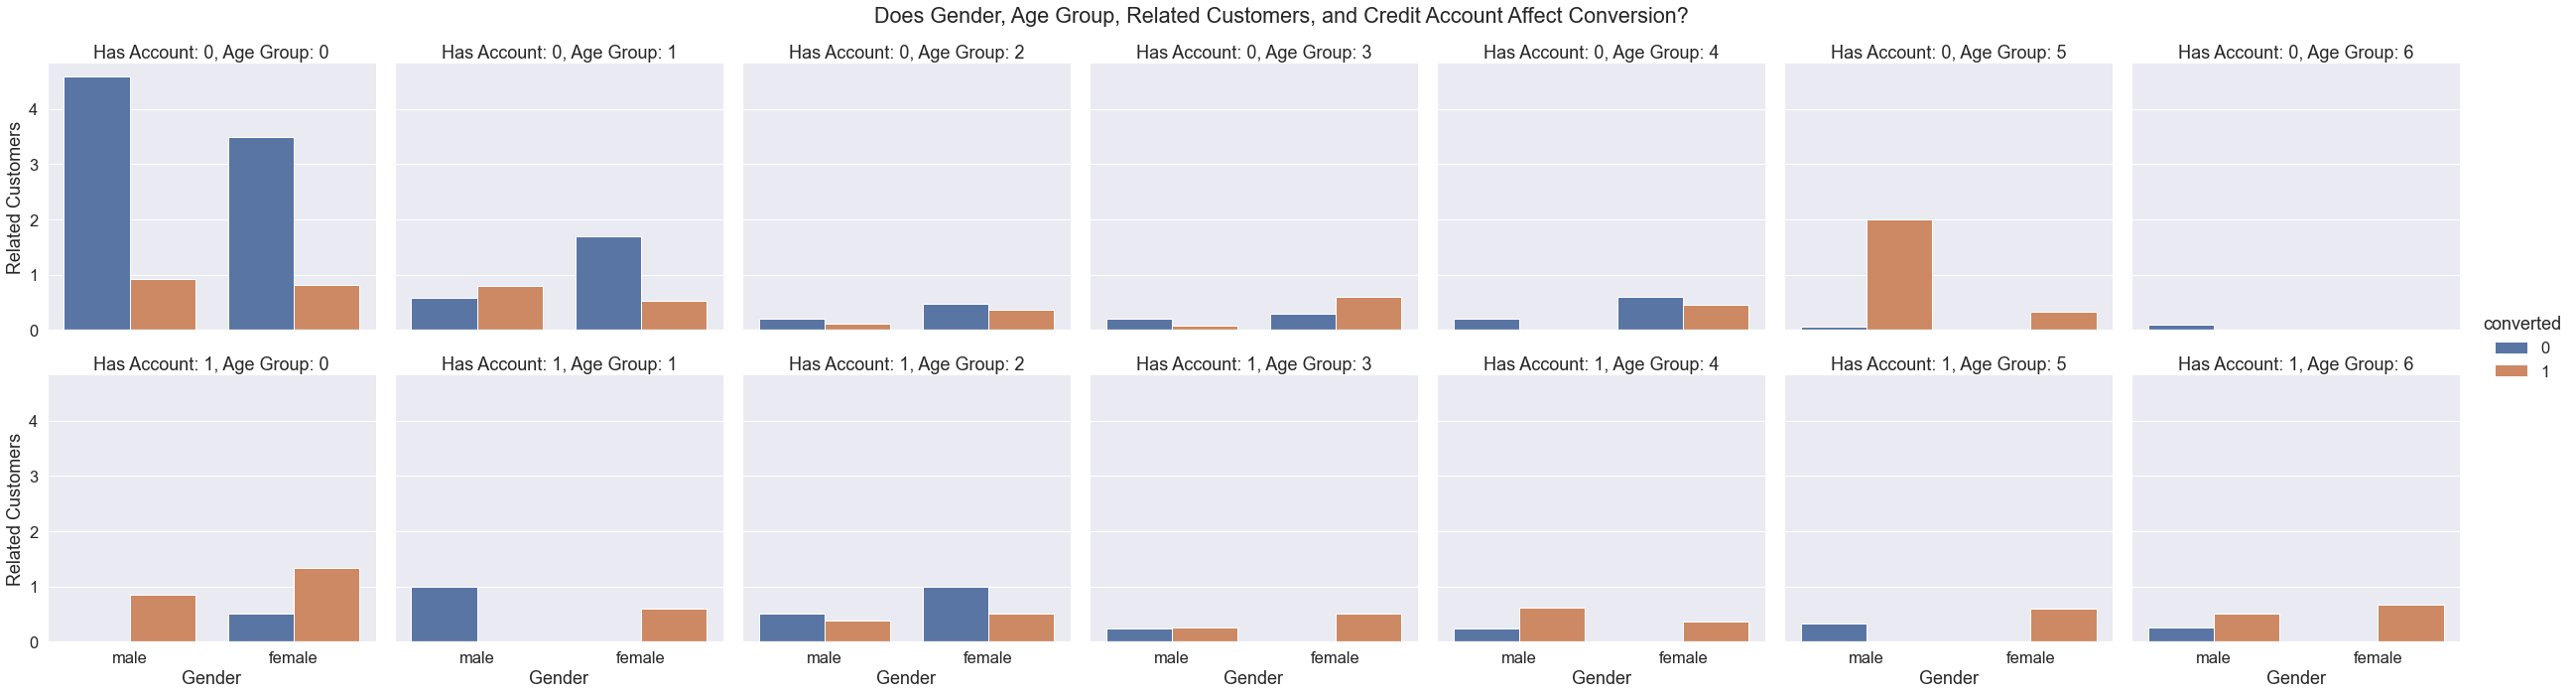

In [270]:
plot = sns.catplot(x='gender', hue='converted', y='related_customers', col='age_group', row='credit_account_id',
            kind='bar', data=data,  ci=None) 

plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Does Gender, Age Group, Related Customers, and Credit Account Affect Conversion?")
plot.set_axis_labels("Gender", "Related Customers")
plot.set_titles("Has Account: {row_name}, Age Group: {col_name}")


In [271]:
## Men and women in the <15 age group have a higher related_customers number but they don't convert.

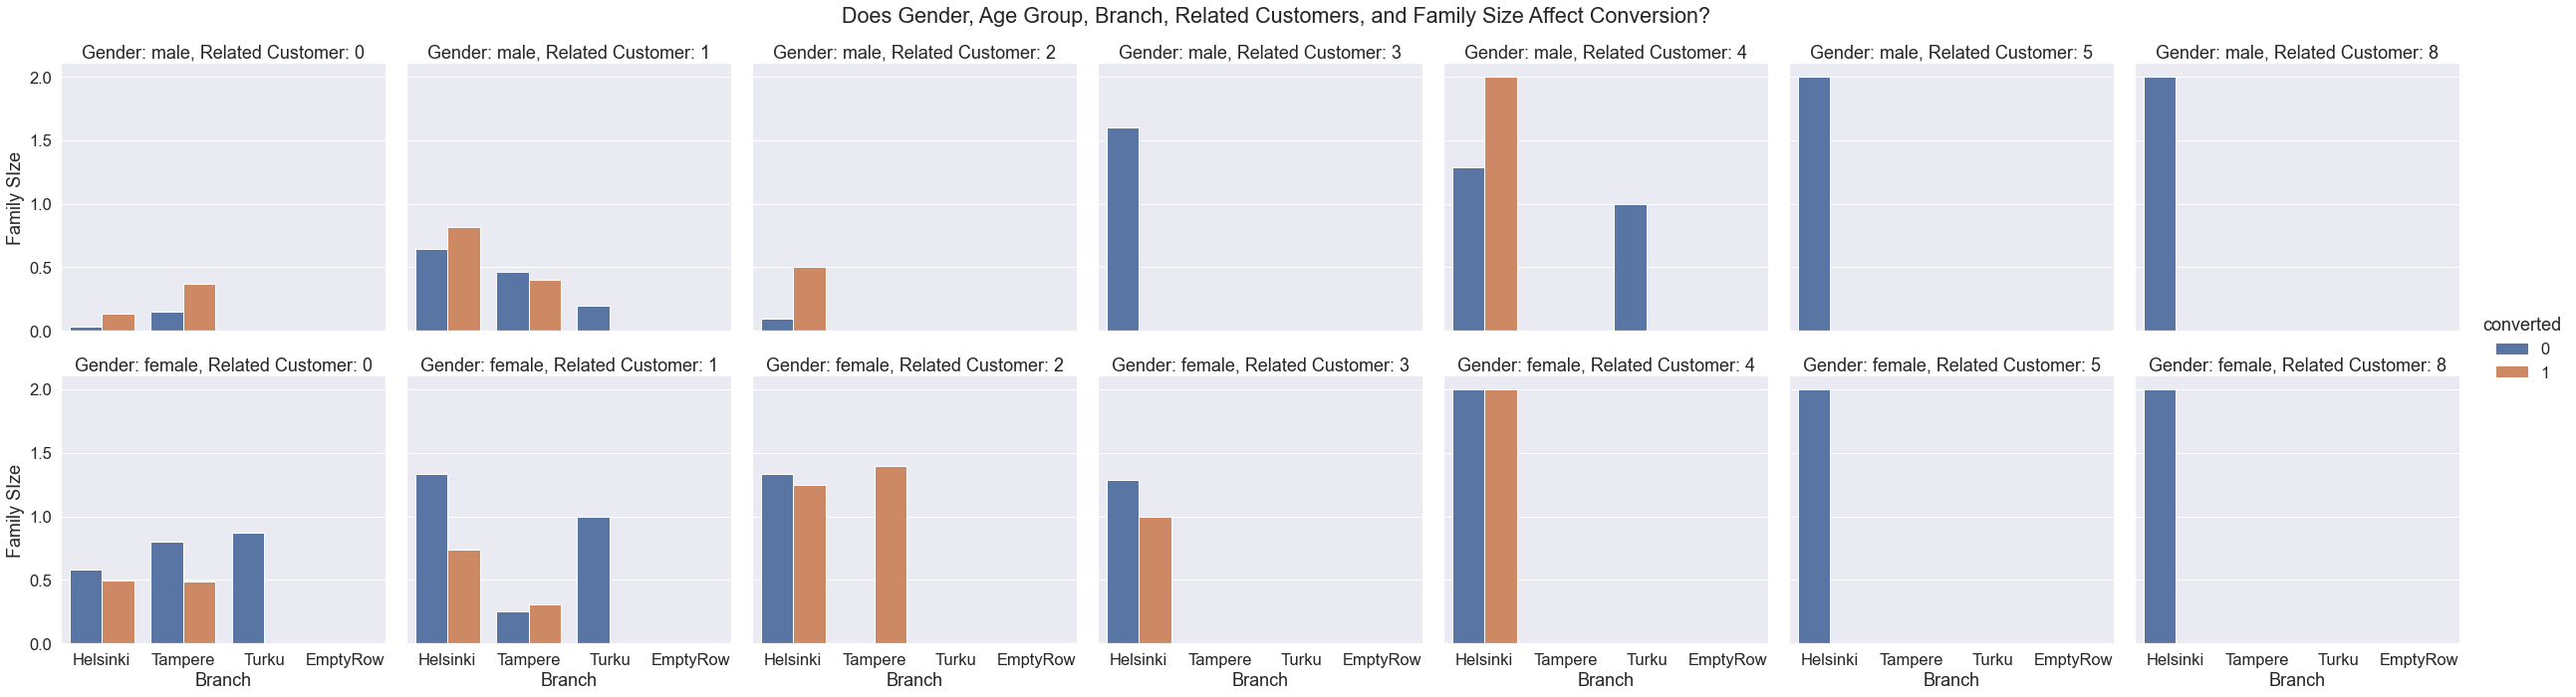

In [272]:
plot = sns.catplot(x='branch', hue='converted', y='family_size', col='related_customers', row = 'gender',
            kind='bar', data=data,  ci=None) 

plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Does Gender, Age Group, Branch, Related Customers, and Family Size Affect Conversion?")
plot.set_axis_labels("Branch", "Family SIze")
plot.set_titles("Gender: {row_name}, Related Customer: {col_name}")


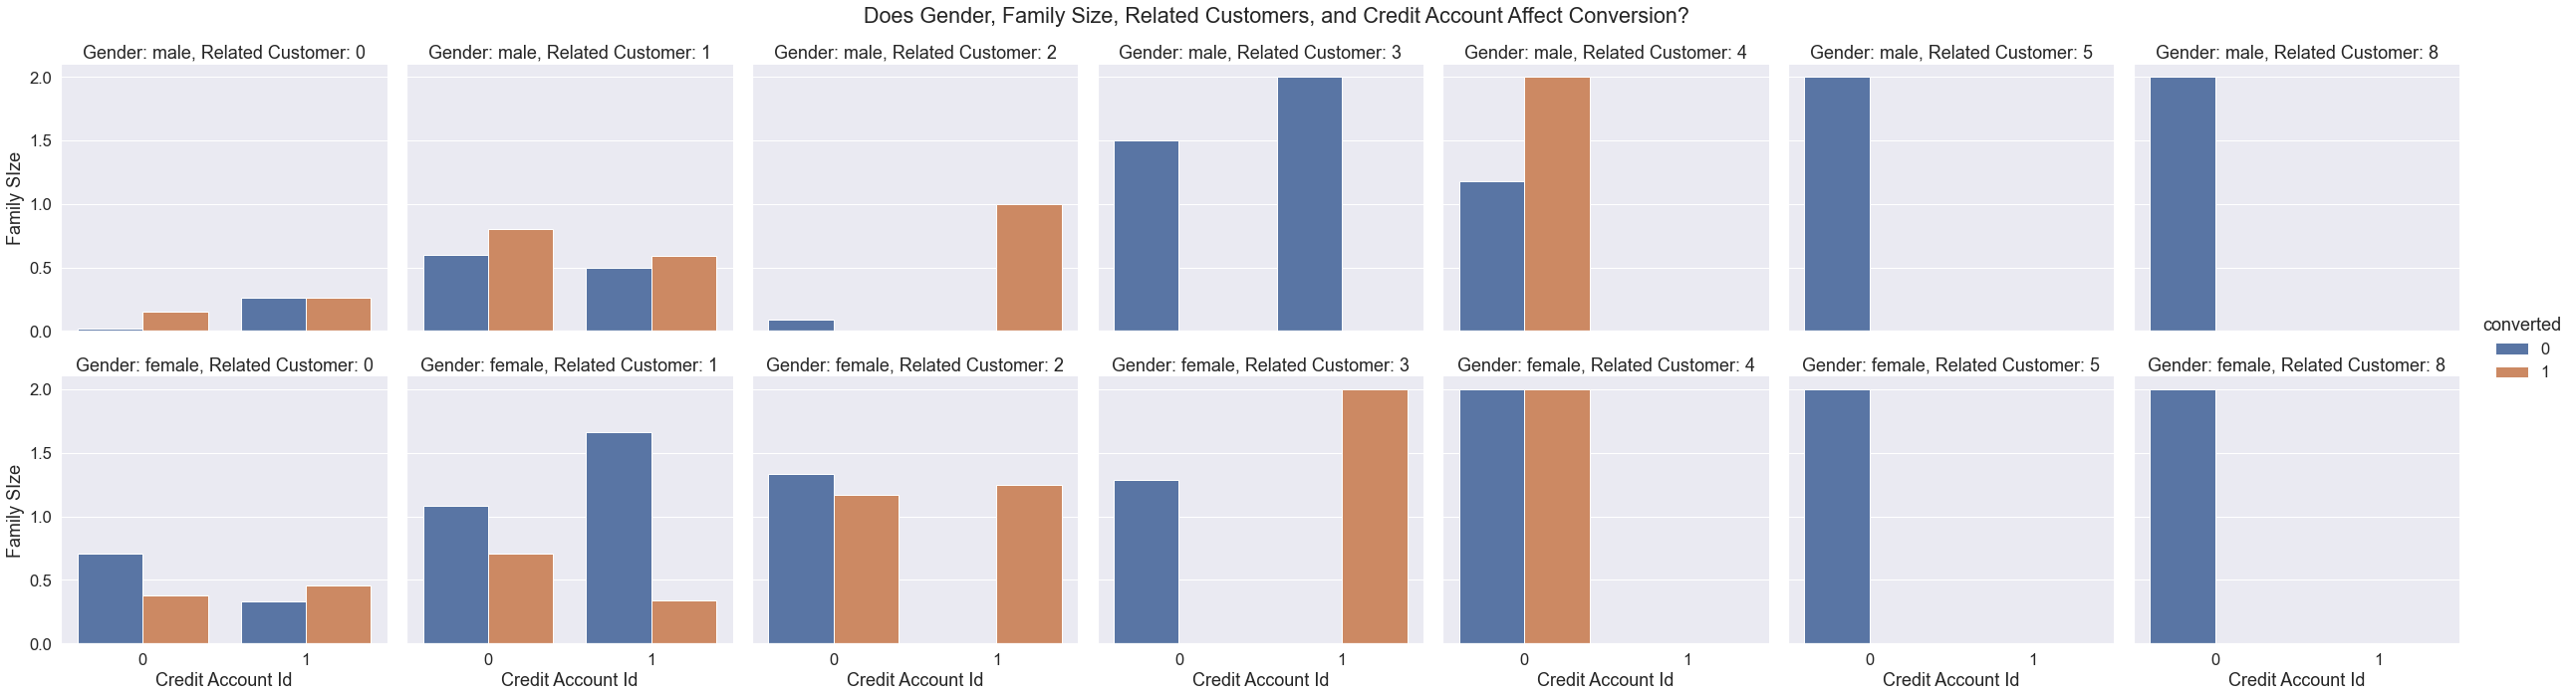

In [273]:
plot = sns.catplot(x='credit_account_id', hue='converted', y='family_size', col='related_customers', row = 'gender',
            kind='bar', data=data,  ci=None)  

plt.subplots_adjust(top=0.9)
plot.fig.suptitle("Does Gender, Family Size, Related Customers, and Credit Account Affect Conversion?")
plot.set_axis_labels("Credit Account Id", "Family SIze")
plot.set_titles("Gender: {row_name}, Related Customer: {col_name}")

In [274]:
### The previous two charts show that related customers is somewhat connected to family size, 
### as the correlation matrix also shows - the more related customers the bigger the family size.
### However, there is no evidence that more related customers and family size matters for conversion.

(0.0, 250.0)

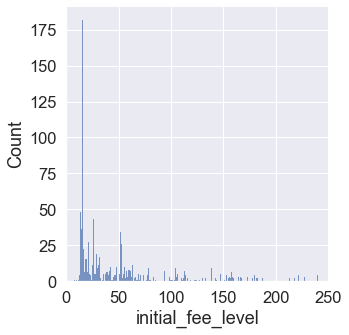

In [275]:
## Let's investigate the initial fee level further, in absence of a product feature
sns.displot(data, x="initial_fee_level", discrete = True)
plt.xlim(0, 250)

(0.0, 150.0)

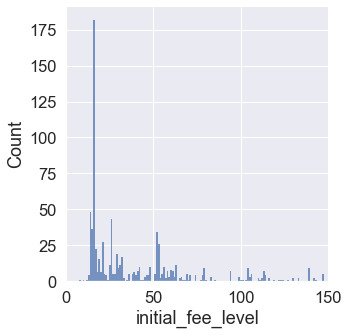

In [276]:
## Let's investigate the initial fee level further, in absence of a product feature
sns.displot(data, x="initial_fee_level", discrete = True)
plt.xlim(0, 150)

In [277]:
data.initial_fee_level.value_counts().head(15)

16.1000    43
26.0000    42
15.7916    38
15.5000    34
52.0000    31
21.0000    24
15.8500    18
15.5500    16
14.4584    15
0.0000     15
53.1000    15
15.7084    13
17.3250    13
14.5000    13
14.4500    12
Name: initial_fee_level, dtype: int64

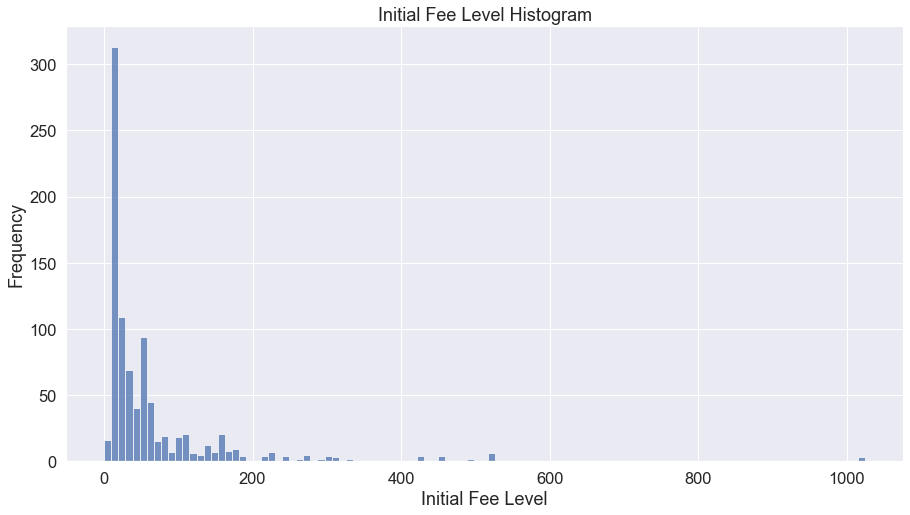

In [278]:
### How will this be binned automatically?

sns.histplot(data.initial_fee_level) # We are going to leave out the 'bins' parameter so seaborn can find the number of bins needed
 
plt.xlabel('Initial Fee Level')
plt.ylabel('Frequency')
plt.title('Initial Fee Level Histogram')

# Show the histogram
plt.show()

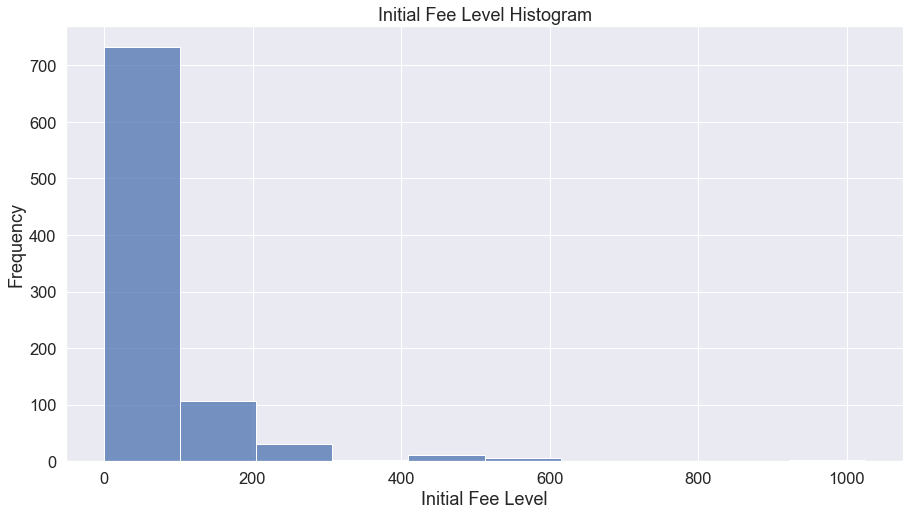

In [279]:
sns.histplot(data.initial_fee_level, bins = 10) # Let's try 10 bins
plt.xlabel('Initial Fee Level')
plt.ylabel('Frequency')
plt.title('Initial Fee Level Histogram')

# Show the histogram
plt.show()

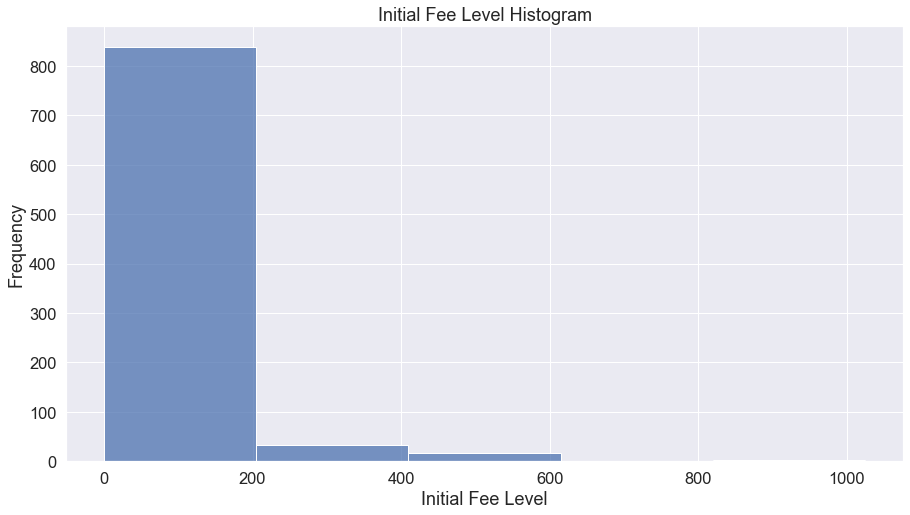

In [280]:
sns.histplot(data.initial_fee_level, bins = 5) # Let's try 5 bins
plt.xlabel('Initial Fee Level')
plt.ylabel('Frequency')
plt.title('Initial Fee Level Histogram')

# Show the histogram
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


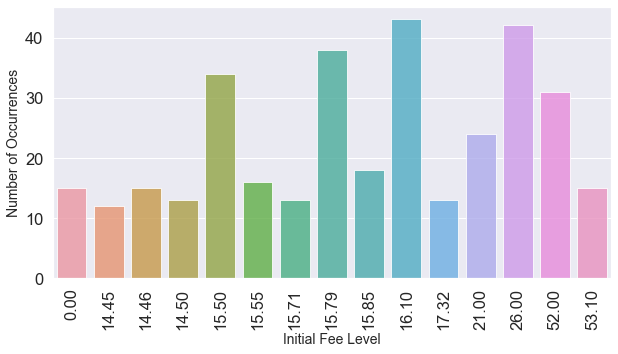

In [281]:
## Let's see how many people there are in the top 15 initial fee levels

fee_count = data['initial_fee_level'].value_counts().head(15)
plt.figure(figsize=(10,5))
ax = sns.barplot(fee_count.index, fee_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Initial Fee Level', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels() ,rotation = 90)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.get_xticklabels()])
plt.show()

In [282]:
## There are indications that initial_fee_level influences conversion. Let's group the fees in buckets and investigate

In [283]:
data['initial_fee_group'] = np.where(
    data['initial_fee_level'] <= 20.00, 0,
    np.where((data['initial_fee_level'] >= 20.01) & (data['initial_fee_level'] <= 50), 1,
             np.where((data['initial_fee_level'] >= 50.01) & (data['initial_fee_level'] <= 100), 2,
                      np.where((data['initial_fee_level'] >= 100.01) & (data['initial_fee_level'] <= 150), 3,
                               np.where((data['initial_fee_level'] >= 150.01) & (data['initial_fee_level'] <= 200), 4,
                                        np.where((data['initial_fee_level'] >= 200.1) & (data['initial_fee_level'] <= 300), 5,
                                                 np.where(data['initial_fee_level'] >= 300.01, 6, 'unknown')
                                                 )
                                        )
                               )
                      )
             )
).astype(int)

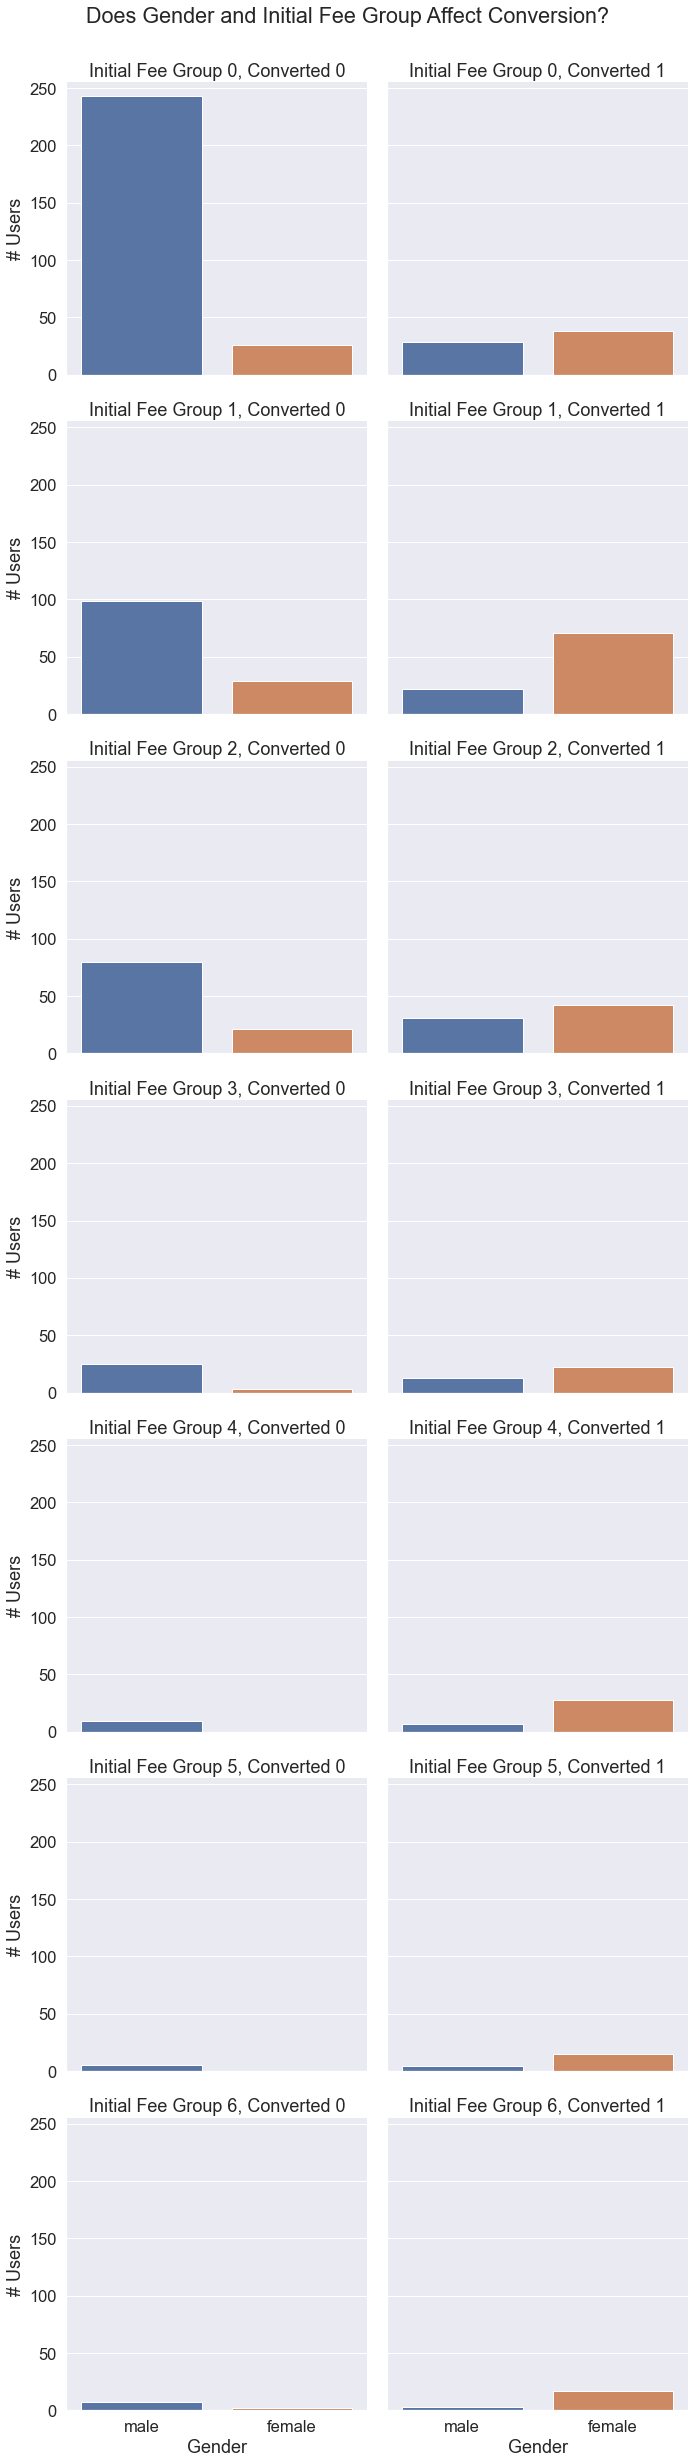

In [284]:
plot = sns.catplot(x='gender', col='converted', data=data, kind='count', row='initial_fee_group')

plt.subplots_adjust(top=0.95)
plot.fig.suptitle("Does Gender and Initial Fee Group Affect Conversion?")
plot.set_axis_labels("Gender", "# Users")
plot.set_titles("Initial Fee Group {row_name}, Converted {col_name}")

In [285]:
### there is little indication that fee groups affect conversion, however, there is a high number of men in the
### <20 fee group who don't convert.

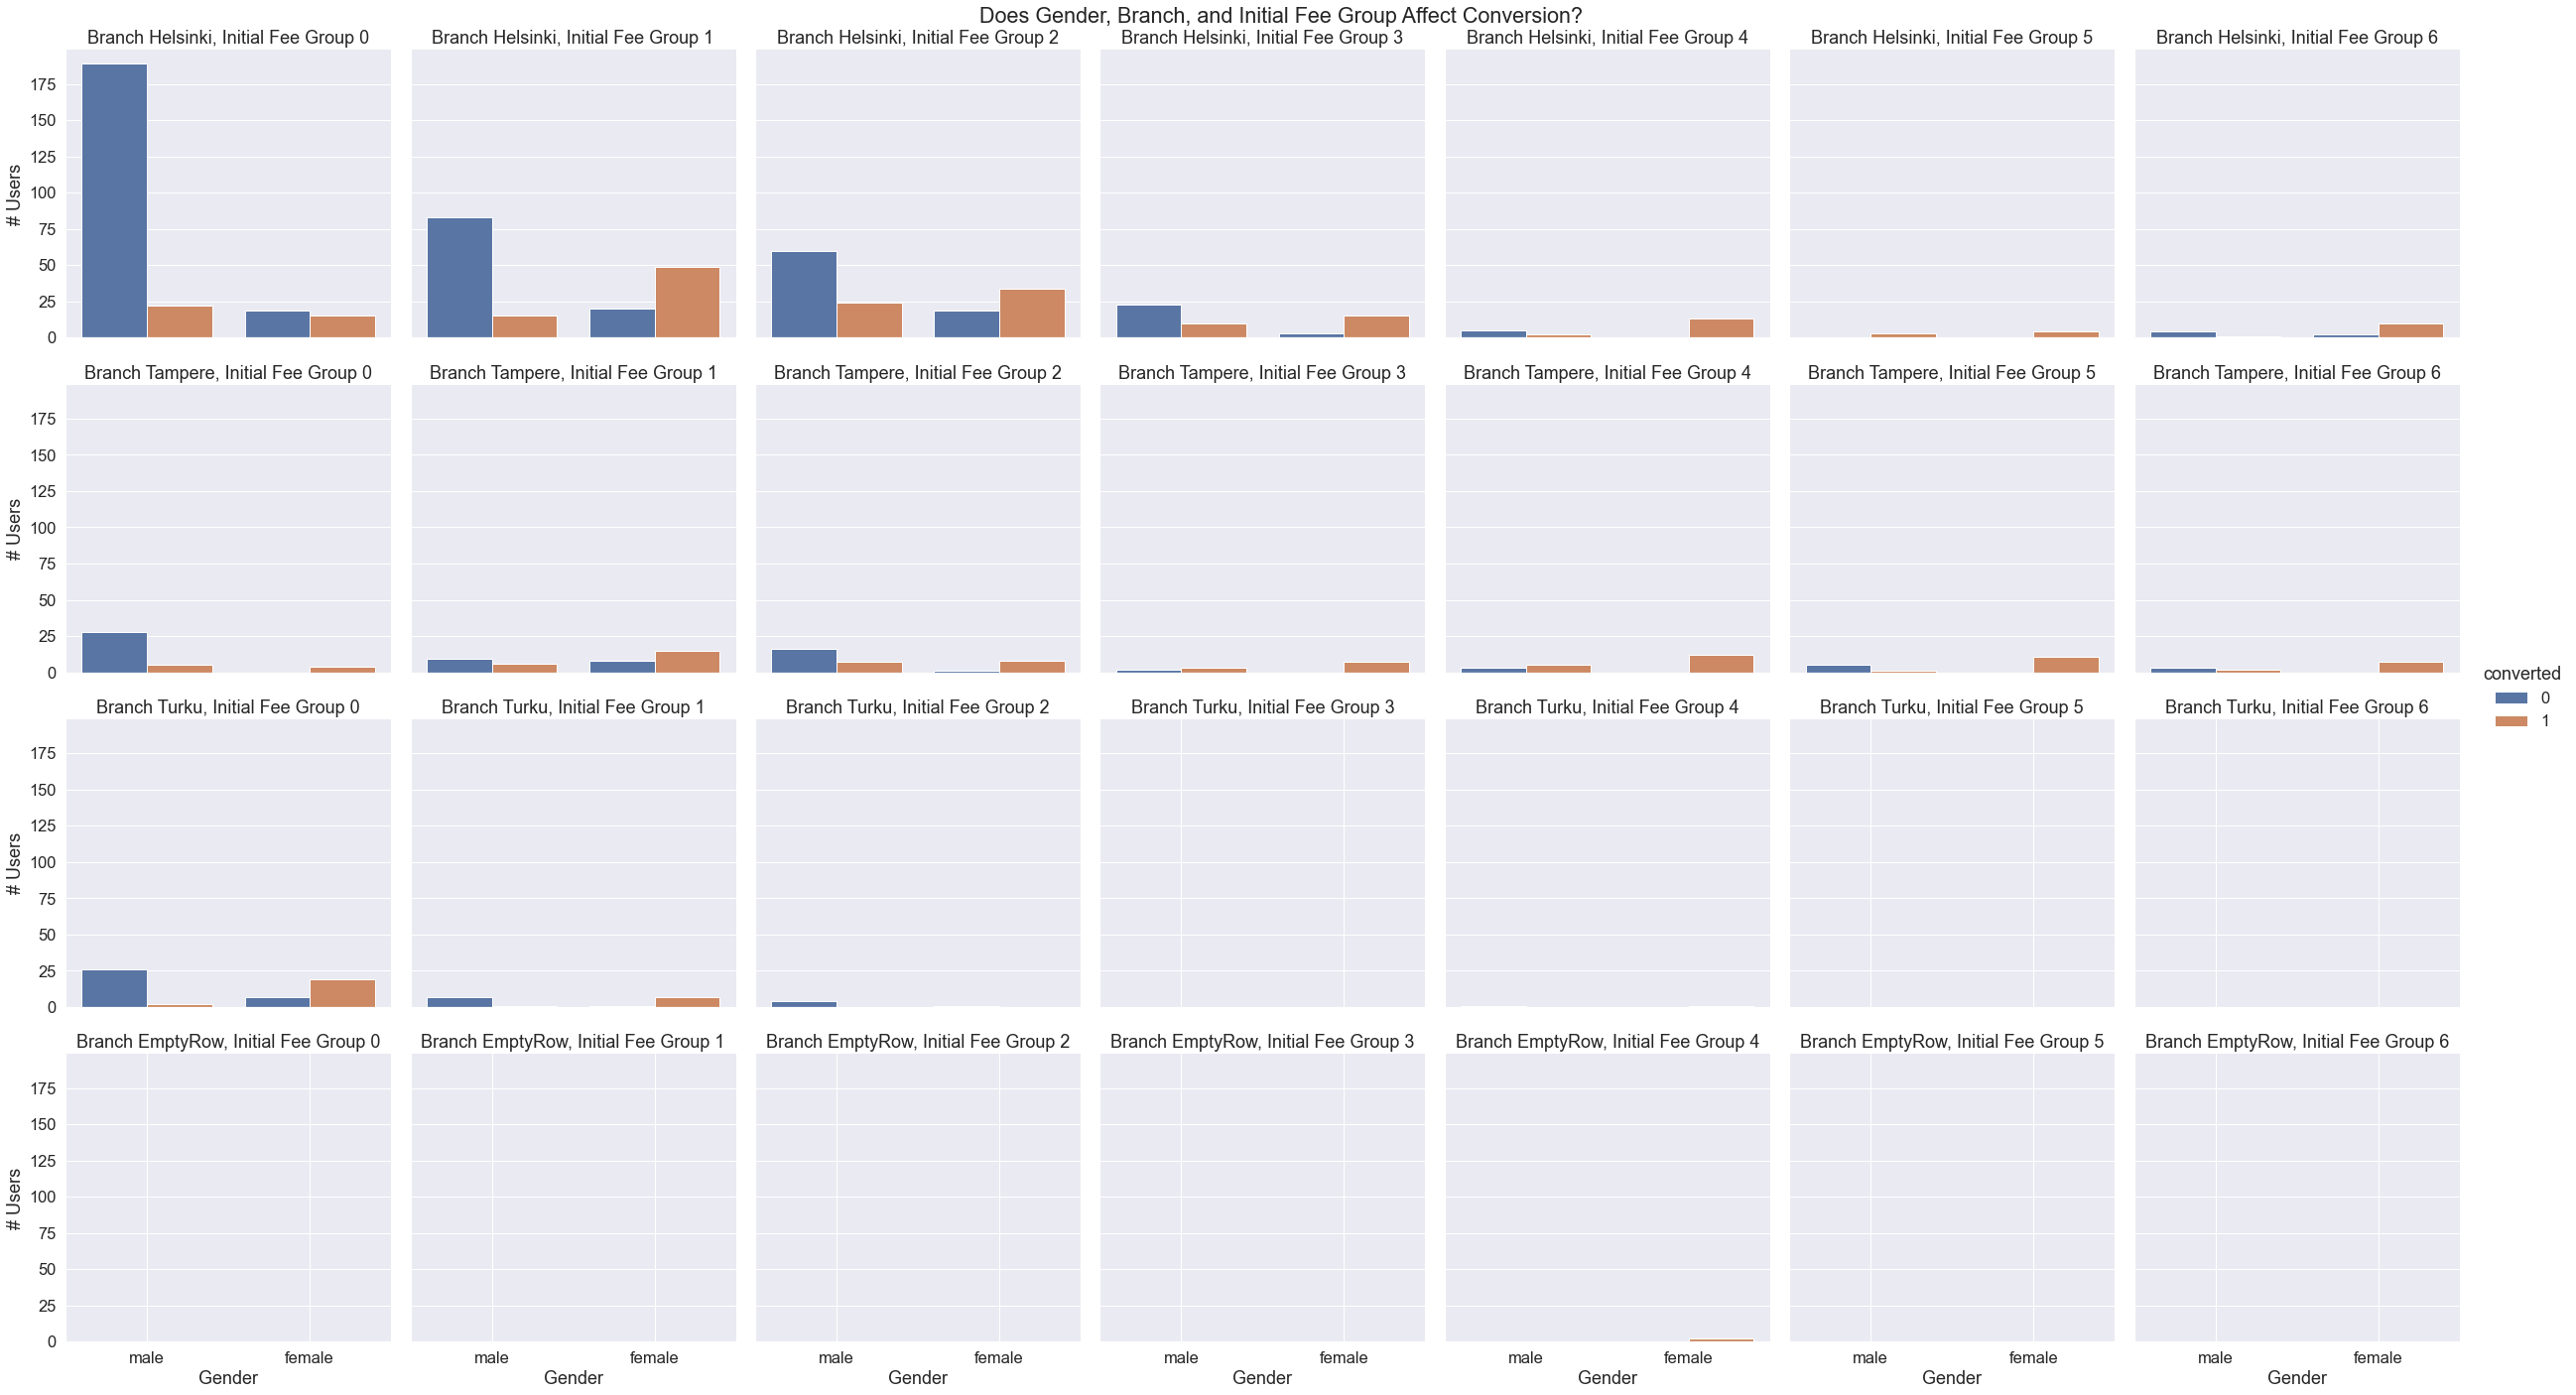

In [286]:
plot = sns.catplot(x='gender', hue='converted', row='branch', col='initial_fee_group',
                  kind='count', data=data, ci=None)  

plt.subplots_adjust(top=0.95)
plot.fig.suptitle("Does Gender, Branch, and Initial Fee Group Affect Conversion?")
plot.set_axis_labels("Gender", "# Users")
plot.set_titles("Branch {row_name}, Initial Fee Group {col_name}")

In [287]:
### there is little indication that fee groups affect conversion, however, there is a high number of men in the
### <20 fee group in Helsinki who don't convert.

In [288]:
data.head()

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,credit_account_id,gender,branch,age_group,initial_fee_group
0,0,13,22.0,1,0,14.5000,0,male,Helsinki,2,0
1,1,11,38.0,1,0,142.5666,1,female,Tampere,3,3
2,1,13,26.0,0,0,15.8500,0,female,Helsinki,2,0
3,1,11,35.0,1,0,106.2000,1,female,Helsinki,3,3
4,0,13,35.0,0,0,16.1000,0,male,Helsinki,3,0


## 4. PCA 
Next we are going to do 2 PCAs: a one-component PCA to see the variability caught by the first principal component and see which features explain the variance the most; and 2) a two-component PCA to see whether there is a boundary line between converted and non-converted users, and see if we can analyse what separates them. At the end we are going to use the Elbow Method for PCA, to see how many PCAs are optimal

## 4.1.1. One-Component PCA With Age Group/Fee Group and No Age/Initial Fee

In [289]:
from sklearn.preprocessing import StandardScaler

In [290]:
data.head()

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,credit_account_id,gender,branch,age_group,initial_fee_group
0,0,13,22.0,1,0,14.5000,0,male,Helsinki,2,0
1,1,11,38.0,1,0,142.5666,1,female,Tampere,3,3
2,1,13,26.0,0,0,15.8500,0,female,Helsinki,2,0
3,1,11,35.0,1,0,106.2000,1,female,Helsinki,3,3
4,0,13,35.0,0,0,16.1000,0,male,Helsinki,3,0


In [291]:
categorical_columns = ['gender', 'branch']
# We need to one-hot encode gender and branch again. We are using age group and initial fee group but no age and initial fee level.
for col in categorical_columns:
    one_hot_encoded = pd.get_dummies(data[col], prefix=col)
    
    # Concatenating the one-hot encoded columns to the original DataFrame
    data = pd.concat([data, one_hot_encoded], axis=1)

In [292]:
data.head()

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,credit_account_id,gender,branch,age_group,initial_fee_group,gender_female,gender_male,branch_EmptyRow,branch_Helsinki,branch_Tampere,branch_Turku
0,0,13,22.0,1,0,14.5000,0,male,Helsinki,2,0,0,1,0,1,0,0
1,1,11,38.0,1,0,142.5666,1,female,Tampere,3,3,1,0,0,0,1,0
2,1,13,26.0,0,0,15.8500,0,female,Helsinki,2,0,1,0,0,1,0,0
3,1,11,35.0,1,0,106.2000,1,female,Helsinki,3,3,1,0,0,1,0,0
4,0,13,35.0,0,0,16.1000,0,male,Helsinki,3,0,0,1,0,1,0,0


In [293]:
columns_to_drop = ['gender', 'branch', 'age', 'initial_fee_level']
oc_pca = data.drop(columns=columns_to_drop)

In [294]:
oc_pca.head()

,converted,customer_segment,related_customers,family_size,credit_account_id,age_group,initial_fee_group,gender_female,gender_male,branch_EmptyRow,branch_Helsinki,branch_Tampere,branch_Turku
0,0,13,1,0,0,2,0,0,1,0,1,0,0
1,1,11,1,0,1,3,3,1,0,0,0,1,0
2,1,13,0,0,0,2,0,1,0,0,1,0,0
3,1,11,1,0,1,3,3,1,0,0,1,0,0
4,0,13,0,0,0,3,0,0,1,0,1,0,0


In [295]:
oc_pca.columns

Index(['converted', 'customer_segment', 'related_customers', 'family_size',
       'credit_account_id', 'age_group', 'initial_fee_group', 'gender_female',
       'gender_male', 'branch_EmptyRow', 'branch_Helsinki', 'branch_Tampere',
       'branch_Turku'],
      dtype='object')

In [296]:
features_oc = ['converted', 'customer_segment', 'related_customers', 'family_size',
       'credit_account_id', 'age_group', 'initial_fee_group', 'gender_female',
       'gender_male', 'branch_EmptyRow', 'branch_Helsinki', 'branch_Tampere',
       'branch_Turku']

In [297]:
x_oc_pca = oc_pca.loc[:, features_oc].values
x_oc_pca = StandardScaler().fit_transform(x_oc_pca) # normalizing the features

In [298]:
normalised_df_oc = pd.DataFrame(x_oc_pca, columns = features_oc)

In [299]:
normalised_df_oc['converted'] = oc_pca.converted

In [300]:
features_norm_values_oc = normalised_df_oc.loc[:,['converted', 'customer_segment', 'related_customers', 'family_size',
       'credit_account_id', 'age_group', 'initial_fee_group', 'gender_female',
       'gender_male', 'branch_EmptyRow', 'branch_Helsinki', 'branch_Tampere',
       'branch_Turku']].values

In [301]:
from sklearn.decomposition import PCA

In [302]:
pca_df_oc = PCA(n_components=1)
principal_components_df_oc = pca_df_oc.fit_transform(features_norm_values_oc)

In [303]:
final_dataset_oc = pd.DataFrame(principal_components_df_oc, columns = ['principal_component_1'])

In [304]:
features_oc

['converted',
 'customer_segment',
 'related_customers',
 'family_size',
 'credit_account_id',
 'age_group',
 'initial_fee_group',
 'gender_female',
 'gender_male',
 'branch_EmptyRow',
 'branch_Helsinki',
 'branch_Tampere',
 'branch_Turku']

In [305]:
components_oc = pca_df_oc.components_
print(components_oc)

[[ 0.15239871 -0.44271423  0.06624256  0.14930843  0.41552573  0.11135968
   0.47594501  0.33453827 -0.33453827  0.08098188 -0.19355069  0.26353697
  -0.07216661]]


In [306]:
# Create a DataFrame for better visualization
components_dict = pd.DataFrame(components_oc, columns=features_oc).to_dict(orient='index')

In [307]:
components_dict = {inner_key: round(value, 3) for inner_key, value in components_dict[0].items()}

In [308]:
components_dict = dict(sorted(components_dict.items(), key=lambda item: item[1], reverse=True))

In [309]:
components_dict

{'initial_fee_group': 0.476,
 'credit_account_id': 0.416,
 'gender_female': 0.335,
 'branch_Tampere': 0.264,
 'converted': 0.152,
 'family_size': 0.149,
 'age_group': 0.111,
 'branch_EmptyRow': 0.081,
 'related_customers': 0.066,
 'branch_Turku': -0.072,
 'branch_Helsinki': -0.194,
 'gender_male': -0.335,
 'customer_segment': -0.443}

In [310]:
pca_df_oc.explained_variance_ 

array([3.07156695])

In [311]:
# Proportion of Variance (for PC1)
pca_df_oc.explained_variance_ratio_

array([0.25073493])

In [312]:
### It seems like this only explains 25% of the variance, which isn't very good

### 4.2.1 Two-Component PCA With Age Group/Fee Group and No Age/Initial Fee

In [313]:
pca_df_tc = PCA(n_components=2)
principal_components_df_tc = pca_df_tc.fit_transform(features_norm_values_oc) #we can use the same features as before

In [314]:
final_dataset_tc = pd.DataFrame(principal_components_df_tc, columns = ['principal_component_1', 'principal_component_2'])

In [315]:
final_dataset_tc.head()

,principal_component_1,principal_component_2
0,-1.877472,-0.028940
1,3.832536,-0.335858
2,-0.384621,1.541538
3,2.726396,0.061595
4,-1.856680,-0.648006


In [316]:
final_dataset_tc['converted'] = normalised_df_oc.converted

<AxesSubplot:xlabel='principal_component_1', ylabel='principal_component_2'>

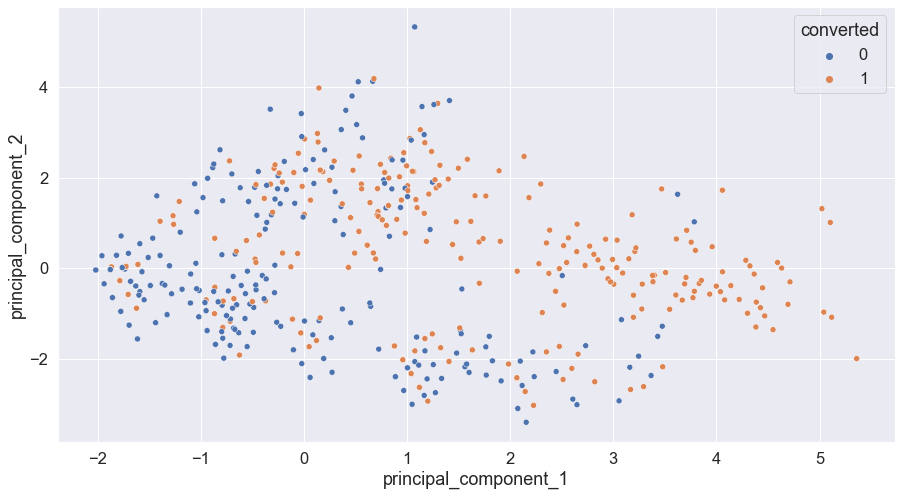

In [317]:
sns.scatterplot(data=final_dataset_tc
             , x='principal_component_1', y='principal_component_2', hue='converted')

In [318]:
### There is slightly less evidence that there might be some differences between converted and non-converted users

In [319]:
pca_df_tc.explained_variance_ 

array([3.07156695, 2.20135878])

In [320]:
# Proportion of Variance (for PC1 and PC2)
pca_df_tc.explained_variance_ratio_

array([0.25073493, 0.17969901])

In [321]:
### The additional component explains about 18 additional percent

### 4.3.1. Elbow Method PCA With Age Group/Fee Group and No Age/Initial Fee

In [323]:
pca = PCA()

pca.fit(x_oc_pca) 

PCA()

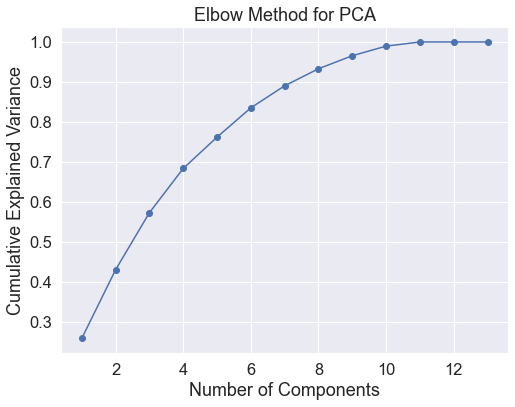

In [324]:
# Calculate the explained variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance and see how many components are optimal
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for PCA')
plt.grid(True)
plt.show()

##### About 7 principal components explain about 90% of the variance. This may not help us reduce dimensionality

In [325]:
pca.explained_variance_.round(3)

array([3.359, 2.236, 1.859, 1.441, 1.02 , 0.955, 0.718, 0.554, 0.425,
       0.313, 0.135, 0.   , 0.   ])

In [326]:
# Proportion of Variance (from PC1 to PC12)
pca.explained_variance_ratio_.round(3)

array([0.258, 0.172, 0.143, 0.111, 0.078, 0.073, 0.055, 0.043, 0.033,
       0.024, 0.01 , 0.   , 0.   ])

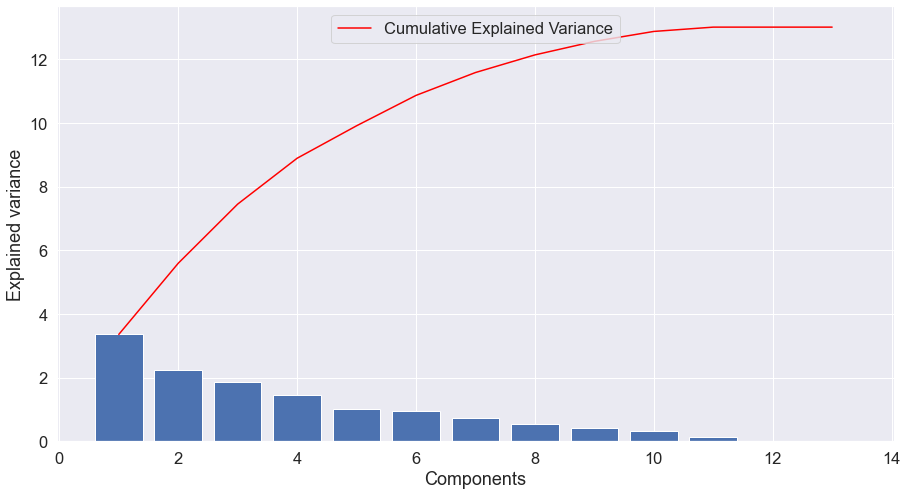

In [327]:
plt.bar(range(1,len(pca.explained_variance_ )+1),pca.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ )+1),
         np.cumsum(pca.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper center')

## 5 Binary Clasification

### 5.1. Binary Classification With Age Group/Fee Group and No Age/Initial Fee

### 5.1. 1. XGBoost

In [328]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

In [329]:
data.head()

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,credit_account_id,gender,branch,age_group,initial_fee_group,gender_female,gender_male,branch_EmptyRow,branch_Helsinki,branch_Tampere,branch_Turku
0,0,13,22.0,1,0,14.5000,0,male,Helsinki,2,0,0,1,0,1,0,0
1,1,11,38.0,1,0,142.5666,1,female,Tampere,3,3,1,0,0,0,1,0
2,1,13,26.0,0,0,15.8500,0,female,Helsinki,2,0,1,0,0,1,0,0
3,1,11,35.0,1,0,106.2000,1,female,Helsinki,3,3,1,0,0,1,0,0
4,0,13,35.0,0,0,16.1000,0,male,Helsinki,3,0,0,1,0,1,0,0


In [330]:
columns_to_drop = ['gender', 'branch', 'age', 'initial_fee_level']
data = data.drop(columns=columns_to_drop)

In [331]:
X = data.drop('converted', axis=1)
y = df['converted']

In [332]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [333]:
# Define the XGBoost classifier
xgb_model = XGBClassifier()

In [334]:
# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}

In [335]:
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy')

In [336]:
# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [337]:
# Train the model with the best hyperparameters
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [338]:
# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

In [339]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [340]:
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.8097014925373134
Confusion Matrix:
 [[144  13]
 [ 38  73]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       157
           1       0.85      0.66      0.74       111

    accuracy                           0.81       268
   macro avg       0.82      0.79      0.80       268
weighted avg       0.82      0.81      0.80       268



In [341]:
# Extract and print feature importance
feature_importance = best_xgb_model.feature_importances_

In [342]:
# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [343]:
# Print the feature importance
print("Feature Importance:\n", feature_importance_df)

Feature Importance:
               Feature  Importance
6       gender_female    0.512607
0    customer_segment    0.162327
3   credit_account_id    0.076257
1   related_customers    0.068148
4           age_group    0.056727
9     branch_Helsinki    0.055083
10     branch_Tampere    0.040405
5   initial_fee_group    0.025787
2         family_size    0.002660
7         gender_male    0.000000
8     branch_EmptyRow    0.000000
11       branch_Turku    0.000000


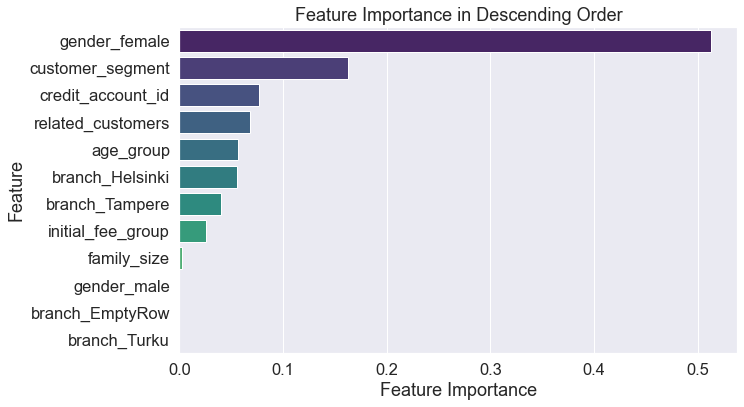

In [344]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Descending Order')
plt.show()

In [345]:
### It looks like the XGBoost model also thinks gender_female is important for conversion. 

### 5.1.2. Logistic Regression

In [346]:
from sklearn.linear_model import LogisticRegression

In [347]:
log_reg = LogisticRegression(max_iter=1000) # if we omit the max_iter parameter, the model throws an error
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [348]:
# Make predictions on the test set
y_pred = log_reg.predict(X_test)

In [349]:
# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.82


In [350]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       157
           1       0.81      0.74      0.77       111

    accuracy                           0.82       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



In [351]:
# Plot feature importance
coefficients = log_reg.coef_[0]
feature_names = X.columns
sorted_indices = np.argsort(coefficients)

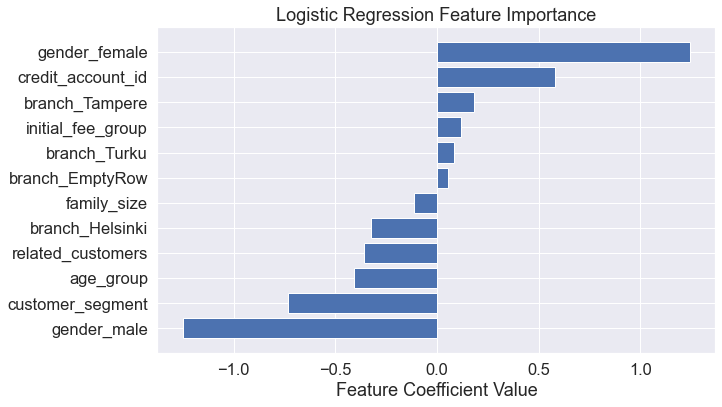

In [352]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), coefficients[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Feature Coefficient Value')
plt.title('Logistic Regression Feature Importance')
plt.show()

In [353]:
### The logistic regression also sees gender_female as an important factor for conversion.

### 4.1.2. One-Component PCA No Age Group + Fee Group

In [354]:
### We now use age and initial fee level and we omit age_group and initial_fee_group, to see if using
### continuous features is preferred over using ordinal values

In [355]:
data = pd.read_csv("imputed_age_df.csv")

In [356]:
data.head()

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,credit_account_id,gender,branch
0,0,13,22.0,1,0,14.5000,0,male,Helsinki
1,1,11,38.0,1,0,142.5666,1,female,Tampere
2,1,13,26.0,0,0,15.8500,0,female,Helsinki
3,1,11,35.0,1,0,106.2000,1,female,Helsinki
4,0,13,35.0,0,0,16.1000,0,male,Helsinki


In [357]:
categorical_columns = ['gender', 'branch']

In [358]:
# Perform one-hot encoding for each categorical column
for col in categorical_columns:
    one_hot_encoded = pd.get_dummies(data[col], prefix=col)
    
    # Concatenate the one-hot encoded columns to the original DataFrame
    data = pd.concat([data, one_hot_encoded], axis=1)

In [359]:
columns_to_drop = categorical_columns
oc_pca = data.drop(columns=columns_to_drop)

In [360]:
oc_pca.head()

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,credit_account_id,gender_female,gender_male,branch_EmptyRow,branch_Helsinki,branch_Tampere,branch_Turku
0,0,13,22.0,1,0,14.5000,0,0,1,0,1,0,0
1,1,11,38.0,1,0,142.5666,1,1,0,0,0,1,0
2,1,13,26.0,0,0,15.8500,0,1,0,0,1,0,0
3,1,11,35.0,1,0,106.2000,1,1,0,0,1,0,0
4,0,13,35.0,0,0,16.1000,0,0,1,0,1,0,0


In [361]:
oc_pca.columns

Index(['converted', 'customer_segment', 'age', 'related_customers',
       'family_size', 'initial_fee_level', 'credit_account_id',
       'gender_female', 'gender_male', 'branch_EmptyRow', 'branch_Helsinki',
       'branch_Tampere', 'branch_Turku'],
      dtype='object')

In [362]:
features_oc = ['customer_segment', 'age', 'related_customers',
       'family_size', 'initial_fee_level', 'credit_account_id',
       'gender_female', 'gender_male', 'branch_EmptyRow', 'branch_Helsinki',
       'branch_Tampere', 'branch_Turku']

In [363]:
x_oc_pca = oc_pca.loc[:, features_oc].values
x_oc_pca = StandardScaler().fit_transform(x_oc_pca) # normalizing the features

In [364]:
normalised_df_oc = pd.DataFrame(x_oc_pca, columns = features_oc)

In [365]:
normalised_df_oc['converted'] = oc_pca.converted

In [366]:
features_norm_values_oc = normalised_df_oc.loc[:,['customer_segment', 'age', 'related_customers',
       'family_size', 'initial_fee_level', 'credit_account_id',
       'gender_female', 'gender_male', 'branch_EmptyRow', 'branch_Helsinki',
       'branch_Tampere', 'branch_Turku']].values

In [367]:
from sklearn.decomposition import PCA

In [368]:
pca_df_oc = PCA(n_components=1)
principal_components_df_oc = pca_df_oc.fit_transform(features_norm_values_oc)

In [369]:
final_dataset_oc = pd.DataFrame(principal_components_df_oc, columns = ['principal_component_1'])

In [370]:
features_oc

['customer_segment',
 'age',
 'related_customers',
 'family_size',
 'initial_fee_level',
 'credit_account_id',
 'gender_female',
 'gender_male',
 'branch_EmptyRow',
 'branch_Helsinki',
 'branch_Tampere',
 'branch_Turku']

In [371]:
components_oc = pca_df_oc.components_
print(components_oc)

[[-0.43933953  0.12270746  0.0351907   0.13267213  0.42030893  0.42451973
   0.34668563 -0.34668563  0.08422077 -0.255704    0.31770443 -0.04910358]]


In [372]:
# Create a DataFrame for better visualization
components_dict = pd.DataFrame(components_oc, columns=features_oc).to_dict(orient='index')

In [373]:
components_dict = {inner_key: round(value, 3) for inner_key, value in components_dict[0].items()}

In [374]:
components_dict = dict(sorted(components_dict.items(), key=lambda item: item[1], reverse=True))

In [375]:
components_dict

{'credit_account_id': 0.425,
 'initial_fee_level': 0.42,
 'gender_female': 0.347,
 'branch_Tampere': 0.318,
 'family_size': 0.133,
 'age': 0.123,
 'branch_EmptyRow': 0.084,
 'related_customers': 0.035,
 'branch_Turku': -0.049,
 'branch_Helsinki': -0.256,
 'gender_male': -0.347,
 'customer_segment': -0.439}

In [376]:
pca_df_oc.explained_variance_ 

array([2.80020145])

In [377]:
# Proportion of Variance (for PC1)
pca_df_oc.explained_variance_ratio_

array([0.23308822])

In [378]:
### This version of the one-component PCA explains slightly less variance than before: 23% vs 25%. 

### 4.2.2 Two-Component PCA No Age Group + Fee Group

In [379]:
pca_df_tc = PCA(n_components=2)
principal_components_df_tc = pca_df_tc.fit_transform(features_norm_values_oc) #we can use the same features as before

In [380]:
final_dataset_tc = pd.DataFrame(principal_components_df_tc, columns = ['principal_component_1', 'principal_component_2'])

In [381]:
final_dataset_tc.head()

,principal_component_1,principal_component_2
0,-1.731556,0.022718
1,3.850110,-0.382808
2,-0.270623,1.376392
3,2.285951,0.115195
4,-1.640566,-0.717401


In [382]:
final_dataset_tc['converted'] = normalised_df_oc.converted

<AxesSubplot:xlabel='principal_component_1', ylabel='principal_component_2'>

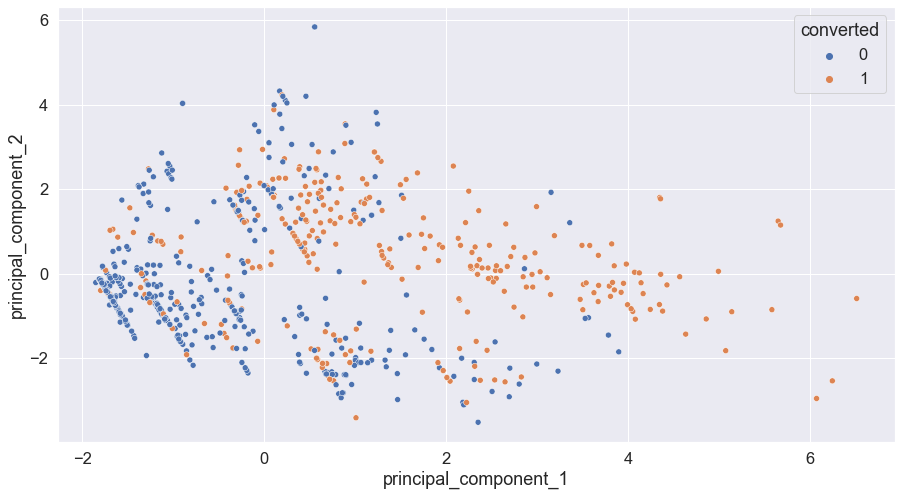

In [383]:
sns.scatterplot(data=final_dataset_tc
             , x='principal_component_1', y='principal_component_2', hue='converted')

In [384]:
### There is some evidence that there might be some differences between converted and non-converted users

In [385]:
pca_df_tc.explained_variance_ 

array([2.80020145, 2.21693782])

In [386]:
# Proportion of Variance (for PC1)
pca_df_tc.explained_variance_ratio_

array([0.23308822, 0.18453747])

In [387]:
### the two components from this version explain similar variance to the previous version: 41.7% vs 43%

### 4.3.2. Elbow Method PCA No Age Group + Fee Group

In [388]:
pca = PCA()

pca.fit(x_oc_pca) 

PCA()

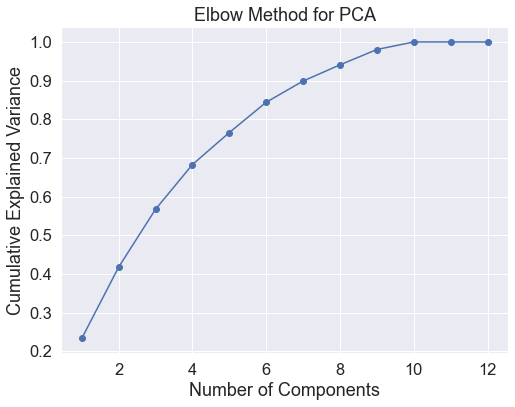

In [389]:
# Calculate the explained variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance and see how many components are optimal
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for PCA')
plt.grid(True)
plt.show()

##### About 7 principal components explain about 90% of the variance

In [390]:
pca.explained_variance_.round(3)

array([2.8  , 2.217, 1.797, 1.389, 0.995, 0.942, 0.659, 0.503, 0.476,
       0.234, 0.   , 0.   ])

In [391]:
# Proportion of Variance (from PC1 to PC12)
pca.explained_variance_ratio_.round(3)

array([0.233, 0.185, 0.15 , 0.116, 0.083, 0.078, 0.055, 0.042, 0.04 ,
       0.02 , 0.   , 0.   ])

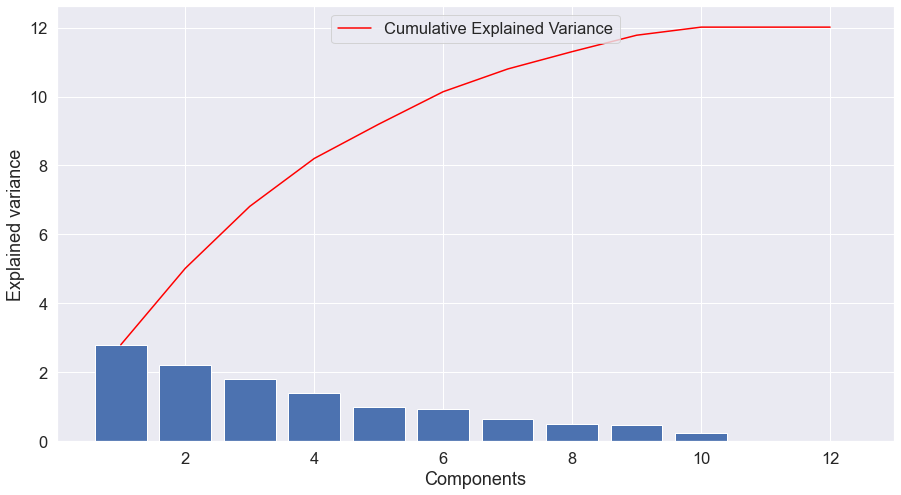

In [392]:
plt.bar(range(1,len(pca.explained_variance_ )+1),pca.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ )+1),
         np.cumsum(pca.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper center')

### 5.2 Binary Classification No Age Group + Fee Group

### 5.2.1 XGBoost

In [393]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

In [394]:
data = pd.read_csv("imputed_age_df.csv")

In [395]:
data.head()

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,credit_account_id,gender,branch
0,0,13,22.0,1,0,14.5000,0,male,Helsinki
1,1,11,38.0,1,0,142.5666,1,female,Tampere
2,1,13,26.0,0,0,15.8500,0,female,Helsinki
3,1,11,35.0,1,0,106.2000,1,female,Helsinki
4,0,13,35.0,0,0,16.1000,0,male,Helsinki


In [396]:
# Perform one-hot encoding for each categorical column
for col in categorical_columns:
    one_hot_encoded = pd.get_dummies(data[col], prefix=col)
    
    # Concatenate the one-hot encoded columns to the original DataFrame
    data = pd.concat([data, one_hot_encoded], axis=1)

In [397]:
columns_to_drop = ['gender', 'branch']
data = data.drop(columns=columns_to_drop)

In [398]:
X = data.drop('converted', axis=1)
y = df['converted']

In [399]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [400]:
# Define the XGBoost classifier
xgb_model = XGBClassifier()

In [401]:
# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}

In [402]:
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy')

In [403]:
# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


In [404]:
# Train the model with the best hyperparameters
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [405]:
# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

In [406]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [407]:
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.8432835820895522
Confusion Matrix:
 [[144  13]
 [ 29  82]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       157
           1       0.86      0.74      0.80       111

    accuracy                           0.84       268
   macro avg       0.85      0.83      0.83       268
weighted avg       0.85      0.84      0.84       268



In [408]:
### The second version of the XGBoost model has higher F1-scores for both converted and non converted users,
### lower precision for non-converted users but higher recall. The accuracy is also higher than the first version
### If we look at the confusion matrix for both XGBoost versions, the second version misclassified converted
### users - they were non-converted in reality.

In [409]:
# Extract and print feature importance
feature_importance = best_xgb_model.feature_importances_

In [410]:
# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [411]:
# Print the feature importance
print("Feature Importance:\n", feature_importance_df)

Feature Importance:
               Feature  Importance
6       gender_female    0.483421
0    customer_segment    0.191103
5   credit_account_id    0.065122
10     branch_Tampere    0.058848
2   related_customers    0.055750
9     branch_Helsinki    0.055258
1                 age    0.045528
4   initial_fee_level    0.034002
3         family_size    0.010968
7         gender_male    0.000000
8     branch_EmptyRow    0.000000
11       branch_Turku    0.000000


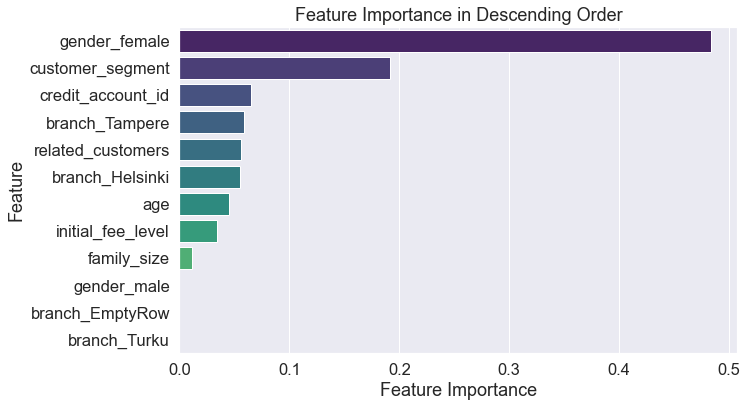

In [412]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Descending Order')
plt.show()

### 5.2.2. Logistic Regression

In [413]:
from sklearn.linear_model import LogisticRegression

In [414]:
log_reg = LogisticRegression(max_iter=1000) # if we omit the max_iter parameter, the model throws an error
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [415]:
# Make predictions on the test set
y_pred = log_reg.predict(X_test)

In [416]:
# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.83


In [417]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       157
           1       0.83      0.75      0.79       111

    accuracy                           0.83       268
   macro avg       0.83      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268



In [418]:
# Plot feature importance
coefficients = log_reg.coef_[0]
feature_names = X.columns
sorted_indices = np.argsort(coefficients)

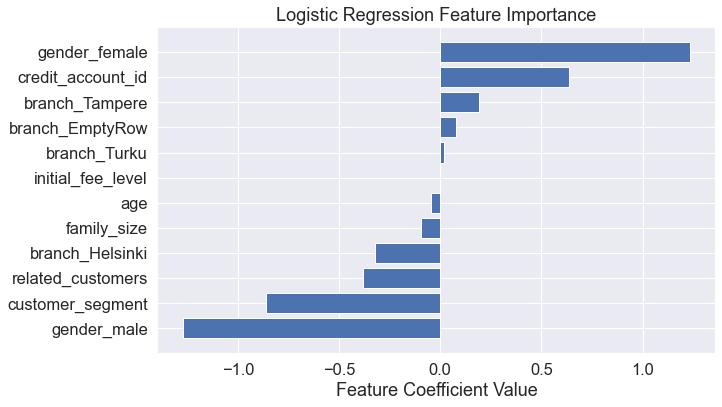

In [419]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), coefficients[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Feature Coefficient Value')
plt.title('Logistic Regression Feature Importance')
plt.show()